In [2]:
import os
import sys
import itertools
from glob import glob
import numpy as np
import nibabel as ni
import pandas
from copy import deepcopy
from sklearn import preprocessing, linear_model
from sklearn.model_selection import KFold
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.utils import check_array
import time
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.sandbox.stats.multicomp import fdrcorrection0 as FDR
sys.path.insert(0, '/Users/jakevogel/git/hack_projects/')
import kfold_learning as kfl



In [3]:
def balance_cohorts(df,col,ratio=2):
    train_ids,test_ids = [],[]
    subs = df.sort_values(col).index
    x = 0
    for i,sub in enumerate(subs):
        if i - x < ratio:
            train_ids.append(sub)
        else:
            test_ids.append(sub)
            x = i+1
    
    return train_ids,test_ids
            

In [365]:
def kfold_feature_learning(train, test, y, t_y, folds = 10, p_cutoff = None, 
                           out_dir = None, clf = linear_model.LassoCV(cv=10), 
                           output='light', scale=False, regcols = None, regdf = None,
                          keep_cols = None, save_int = True):
    
    # train is a subjects x variables dataframe
    # y is a pandas series with the same index as train. y should not be in train
    # train and test indices should just be a range
    # Reg cols are names of columns in regdf to regress out during the p_cutoff feature
    #    removal
    # Keep cols is a list of columns numbers you wish to keep in lasso no matter what
    
    #feature_matrix = pandas.DataFrame(np.zeros_like(train))
    predicted = []
    all_weights = pandas.DataFrame(np.zeros((folds,len(train.columns))))
    if save_int:
        ints = []
    start = 0

    if scale:
        master_scl = preprocessing.StandardScaler().fit(train)
        train = pandas.DataFrame(master_scl.transform(train),
                                 index=train.index,columns=train.columns)
        test = pandas.DataFrame(master_scl.transform(test),
                                 index=test.index,columns=test.columns)
        
    #for sub,row in train.loc[train.index[start:]].iterrows():
    fold = 1
    for tr_ix, te_ix in KFold(n_splits=folds).split(train):
        #i = train.index.tolist().index(sub)
        tmp_mtx = train.loc[train.index[tr_ix]]
        if regcols != None:
            ref = deepcopy(tmp_mtx)
            tmp_mtx.columns = ['x_%s'%x for x in tmp_mtx.columns]
            tmp_mtx['y'] = y.loc[tmp_mtx.index]
            stmnt = 'y ~'
            for z,col in enumerate(regcols):
                cov = 'cov_%s'%z
                tmp_mtx[cov] = regdf.loc[tmp_mtx.index][col]
                if z == 0:
                    stmnt += ' %s'%cov
                else:
                    stmnt += ' + %s'%cov
        else:
            regcols = []
        ps = []
        print('running correlation for fold %s of %s'%(fold,folds))
        if p_cutoff != None:
            if len(regcols) > 0:
                for x in range(tmp_mtx.shape[1] - (len(regcols) + 1)):
                    n_stmnt = '%s + x_%s'%(stmnt,x)
                    ps.append(smf.ols(stmnt,data=temp_mtx).fit().pvalues[-1])
                sig_mtx = ref.loc[ref.index[:]]
            else:
                for x in range(tmp_mtx.shape[1]):
                    ps.append(stats.pearsonr(
                            y[tmp_mtx.index].values,tmp_mtx.values[:,x])[1]
                         )
            ps_s = pandas.Series(ps)
            sig = ps_s[ps_s < p_cutoff]
            if len(sig) == 0:
                fold += 1
                continue
            sig_mtx = tmp_mtx[sig.index]
        else:
            sig_mtx = tmp_mtx[tmp_mtx.columns[:]]
        print('running lasso for fold %s of %s'%(fold,folds))
        if type(keep_cols) == list:
            for col in keep_cols:
                sig_mtx[col] = tmp_mtx.ix[:,col]
        lasso = clf.fit(sig_mtx,y[sig_mtx.index])
        all_weights.loc[(fold-1)][sig_mtx.columns] = lasso.coef_
        #feature_matrix.loc[fold][sig_mtx.columns] = lasso.coef_
        [predicted.append(x) for x in lasso.predict(train.loc[train.index[te_ix]][
                                                    sig_mtx.columns].values)]
        #predicted += jnk
        if save_int:
            ints.append(lasso.intercept_)
            print('intercept:',lasso.intercept_)
        fold += 1
        if len(regcols) == 0:
            regcols = None
        if out_dir != None and type(out_dir) == str:
            print('saving matrix for fold %s of %s'%(fold,folds))
            if not os.path.isdir(out_dir):
                os.mkdir(out_dir)
            feature_matrix.to_csv(os.path.join(out_dir,'lasso_weights.csv'))
            pandas.DataFrame(pandas.Series(predicted)).to_csv(
                                                    os.path.join(out_dir,'lasso_predicted.csv'))
        
    #final_weights = feature_matrix.mean(axis=0)
    final_weights = all_weights.mean(axis=0)
    print(len([i for i in final_weights.index if abs(final_weights[i]) > 0 ]),
          'features selected')
    r,p = stats.pearsonr(y[train.index],predicted)
    print('validation prediction accuracy is %s percent \n p = %s \n r = %s'%((r**2)*100,p,r))
    
    ## A LITTLE EXPERIMENT ##
    predicted2 = (train * np.array(final_weights)).sum(axis=1)
    if save_int:
        all_ints = np.mean(ints)
        t_predicted += all_ints
    else:
        all_ints = []
    r,p = stats.pearsonr(t_y[test.index],predicted2)
    print('testing prediction accuracy2 is %s percent \n p = %s \n r = %s'%((r**2)*100,p,r))
    
    t_predicted = (test * np.array(final_weights)).sum(axis=1)
    if save_int:
        all_ints = np.mean(ints)
        t_predicted += all_ints
    else:
        all_ints = []
    r,p = stats.pearsonr(t_y[test.index],t_predicted)
    print('testing prediction accuracy is %s percent \n p = %s \n r = %s'%((r**2)*100,p,r))
    
    if output == 'light':
        return final_weights, predicted, t_predicted, all_ints
    else:
        return final_weights, predicted, t_predicted, all_weights, lasso 
    

# Original Analyses

In [4]:
ld_05 = pandas.read_csv(
    '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/fmri/LD_analyses/sc444_link_densities.dat')
ld_05.head()

Column 1  Unnamed: 0 Unnamed: 0.1  Gender  Age     FD  ApoE4_status  tPSO  \
0         0  s108583NAP   s108583NAP       0   67  0.256             0   -11   
1         1  s113451NAP   s113451NAP       0   63  0.240             0   -22   
2         2  s115095PRE   s115095PRE       1   64  0.183             1     4   
3         3  s122650PRE   s122650PRE       0   72  0.289             0    -8   
4         4  s139940PRE   s139940PRE       0   56  0.248             0   -16   

   p0_dens  p1_dens          ...           network6_density  network7_density  \
0       11       10          ...                   0.099394          0.083539   
1       13       24          ...                   0.115960          0.105935   
2       11       20          ...                   0.084242          0.088914   
3       17       19          ...                   0.082222          0.090705   
4       40       54          ...                   0.064040          0.114670   

   participation_coefficient_hippocampus  Predicted p220_dens  \
0                               0.660494            22.955600   
1                               0.718226            19.801915   
2                               0.666667            30.860591   
3                               0.197531            22.216377   
4                               0.627219            24.205445   

   Residual p220_dens  Predicted tPSO  Residual tPSO  \
0           -5.537332       -9.601491      -1.398509   
1           18.906619      -11.683144     -10.316856   
2           13.842439       -9.710314      13.710314   
3          -13.674899       -6.897696      -1.102304   
4          -11.602974      -15.044325      -0.955675   

   Residual network5_density  Residual participation_coefficient_hippocampus  \
0                  -0.029140                                        0.107467   
1                   0.096039                                        0.151842   
2                  -0.035617                                        0.074754   
3                  -0.010514                                       -0.336075   
4                  -0.000218                                        0.045005   

   Residual p220_dens 2  
0             -4.955600  
1             23.198085  
2              8.139409  
3            -13.216377  
4            -11.205445  

[5 rows x 467 columns]

In [5]:
ld_05.index = ld_05[ld_05.columns[1]]

In [6]:
jnk = pandas.ExcelFile('/Users/jakevogel/Dropbox/Team 1/all_ids.xlsx')
jnk = pandas.ExcelFile('/Users/jakevogel/Dropbox/Team 1/all_ids.xlsx').parse(jnk.sheet_names[0])
jnk.index = jnk.CandID

In [7]:
nids = []
for sid in ld_05.index:
    nids.append(jnk.loc[int(sid[1:7])][jnk.columns[0]])
ld_05.index = nids

In [8]:
ld_subs = ld_05[ld_05.columns[8:459].tolist() + ld_05.columns[3:6].tolist()]

In [9]:
ld_train_ids,ld_test_ids = balance_cohorts(ld_05,'tPSO',2)

In [10]:
ld_train = ld_subs.loc[ld_train_ids]
ld_train.columns = range(len(ld_train.columns))
ld_test = ld_subs.loc[ld_test_ids]
ld_train.columns = range(len(ld_train.columns))

In [11]:
### Cool!! Now lets put GM into the picture as well! (We'll do alone after, maybe?)
gm_df = pandas.read_csv(
    '/Users/jakevogel/Science/Prevent_AD/prevent_ad_gm/gm_sc444_regs_allsubs.csv')
gm_df.index = gm_df[gm_df.columns[0]]
gm_df.drop(gm_df.columns[0],axis=1,inplace=True)
gm_df.columns = ['gm_'+str(x) for x in gm_df.columns]

In [12]:
nids = []
for sid in gm_df.index:
    nids.append(jnk.loc[int(sid)][jnk.columns[0]])
gm_df.index = nids

In [13]:
mm_train = pandas.concat([ld_train,gm_df.loc[ld_train.index]],axis=1)
mm_test = pandas.concat([ld_test,gm_df.loc[ld_test.index]],axis=1)

mm_train.columns = range(len(mm_train.columns))
mm_test.columns = range(len(mm_test.columns))

In [15]:
gm_train = gm_df.loc[ld_train.index]
gm_test = gm_df.loc[ld_test.index]


In [16]:
gm2_train = deepcopy(gm_train)
gm2_test = deepcopy(gm_test)
gm2_train.ix[:,'Age'] = ld_05.loc[gm2_train.index].Age
gm2_train.ix[:,"Gender"] = ld_05.loc[gm2_train.index].Gender
gm2_test.ix[:,'Age'] = ld_05.loc[gm2_test.index].Age
gm2_test.ix[:,"Gender"] = ld_05.loc[gm2_test.index].Gender
gm2_train.columns = range(len(gm2_train.columns))
gm2_test.columns = range(len(gm2_test.columns))

In [17]:
ld2_train = ld_train[ld_train.columns[:-9]]
ld2_test = ld_test[ld_test.columns[:-9]]

In [18]:
jnk = deepcopy(gm2_train)
jnk.columns = ['gm_'+str(x) for x in jnk.columns]
jnk2 = deepcopy(ld2_train)
jnk2.columns = ['ld_'+str(x) for x in jnk2.columns]
mm_train = pandas.concat([jnk,jnk2],axis=1)
mm_train.columns = range(len(mm_train.columns))
jnk = deepcopy(gm2_test)
jnk.columns = ['gm_'+str(x) for x in jnk.columns]
jnk2 = deepcopy(ld2_test)
jnk2.columns = ['ld_'+str(x) for x in jnk2.columns]
mm_test = pandas.concat([jnk,ld2_test],axis=1)
mm_test.columns = range(len(mm_test.columns))

In [19]:
xmm_train = pandas.DataFrame(mm_train,copy=True)
agend = mm_train[mm_train.columns[444:446]]
for i in range(2):
    xmm_train.drop(xmm_train.columns[444],axis=1,inplace=True)
xmm_train.loc[:,'Age'] = agend[agend.columns[0]].values
xmm_train.loc[:,'Gender'] = agend[agend.columns[1]].values

xmm_test = pandas.DataFrame(mm_test,copy=True)
agend = mm_test[mm_test.columns[444:446]]
for i in range(2):
    xmm_test.drop(xmm_test.columns[444],axis=1,inplace=True)
xmm_test.loc[:,'Age'] = agend[agend.columns[0]].values
xmm_test.loc[:,'Gender'] = agend[agend.columns[1]].values

In [20]:
ldy = ld_05.loc[ld_train.index].tPSO
ldt_y = ld_05.loc[ld_test.index].tPSO
p_cutoff = 0.05
folds = 3
#out_dir = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/rsfmri_lasso/kfold10_gm_0p001/'
kmxoutput = kfl.kfold_feature_learning(xmm_train,xmm_test,ldy,ldt_y, folds = folds,
                                    p_cutoff = p_cutoff, output='light', scale=True)


running correlation for fold 1 of 3
running model for fold 1 of 3


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 2 of 3
running model for fold 2 of 3


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 3 of 3
running model for fold 3 of 3
53 features selected
validation prediction accuracy is 30.7954286139 percent 
 p = 1.63111781281e-12 
 r = -0.554936290162
testing prediction accuracy2 is 40.3398259837 percent 
 p = 5.93628485386e-17 
 r = 0.635136410417
testing prediction accuracy is 20.8734124893 percent 
 p = 8.99057548909e-05 
 r = 0.456874298788


In [ ]:
## AGE ANALYSIS

In [2514]:
ldy = ld_05.loc[ld_train.index].tPSO
ldt_y = ld_05.loc[ld_test.index].tPSO
p_cutoff = 0.05
folds = 3
#out_dir = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/rsfmri_lasso/kfold10_gm_0p001/'
kmmoutput = kfl.kfold_feature_learning(mm_train,mm_test,ldy,ldt_y, folds = folds,
                                    p_cutoff = p_cutoff, output='light', scale=True)




running correlation for fold 1 of 3
running model for fold 1 of 3


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 2 of 3
running model for fold 2 of 3


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 3 of 3
running model for fold 3 of 3
53 features selected
validation prediction accuracy is 30.7951582585 percent 
 p = 1.63155802435e-12 
 r = -0.554933854243
testing prediction accuracy2 is 40.3398922246 percent 
 p = 5.9358319699e-17 
 r = 0.635136931887
testing prediction accuracy is 20.8732967161 percent 
 p = 8.99103171172e-05 
 r = 0.456873031773


In [107]:
#nixtiv_train = pandas.DataFrame(nmmx_train,copy=True)
#nixtiv_train.loc[:,'TIV'] = super_train.loc[nixtiv_train.index].TIV.values
#for col in ['Age', 'Gender']:
#    nixtiv_train.drop(col,axis=1,inplace=True)
#nixtiv_test = pandas.DataFrame(nmmx_test,copy=True)
##nixtiv_test.loc[:,'TIV'] = super_test.loc[nixtiv_test.index].TIV.values
#for col in ['Age', 'Gender']:
#    nixtiv_test.drop(col,axis=1,inplace=True)
#nixtiv_train.dropna(inplace=True)
#nixtiv_test.dropna(inplace=True)


ldy = ld_05.loc[ld_train.index].tPSO
ldt_y = ld_05.loc[ld_test.index].tPSO
p_cutoff = 0.05
folds = 3
ci = 0.05
nixtiv_output = kfl.kfold_feature_learning(nixtiv_train, nixtiv_test, ldy, ldt_y, folds = folds,
                                    p_cutoff = p_cutoff, ci=ci, output='heavy', scale=True)

running correlation for fold 1 of 3
running model for fold 1 of 3


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 2 of 3
running model for fold 2 of 3


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 3 of 3
running model for fold 3 of 3
64 features selected
validation prediction accuracy is 25.6607623463 percent (0.184167468365, 0.340613855446, mean=0.260695466977) 
 p = 2.6903410572e-10 
 r = -0.506564530404
testing prediction accuracy2 is 44.1939475799 percent 
 p = 8.1350343026e-19 
 r = 0.664785285486
testing prediction accuracy is 22.1198023832 percent (0.0789848459586, 0.3956867078, mean=0.230587666253) 
 p = 5.92026466573e-05 
 r = 0.470316939768


In [109]:
output = nixtiv_output
fm = output[-2]

In [110]:
kmm_weights = output[0]
kmm_predicted = output[1]
kmmtest_predicted = output[2]
kmm_int = output[3]

In [2705]:
ldt_y = ldt_y.loc[kmmtest_predicted.index]

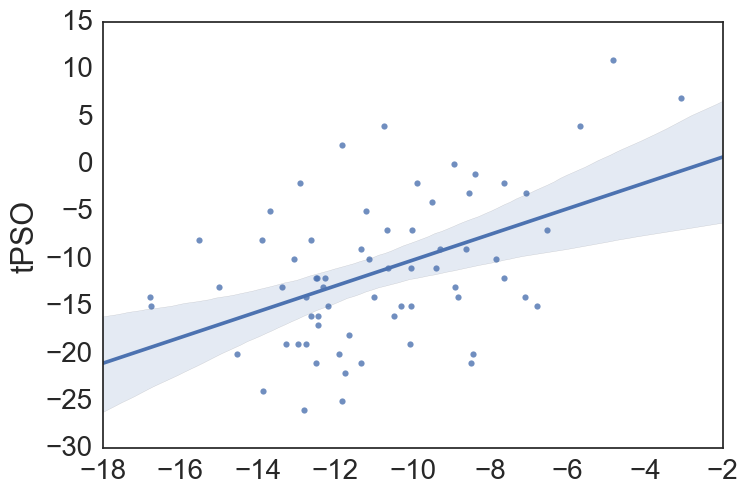

In [2706]:
plt.close()
sns.regplot(np.array(kmmtest_predicted),ldt_y)
plt.show()

In [2707]:
resdf = pandas.concat([kmmtest_predicted,ldt_y],axis=1)
resdf.columns = ['Predicted spEYO','Observed spEYO']

In [2740]:
plt.xlabel?

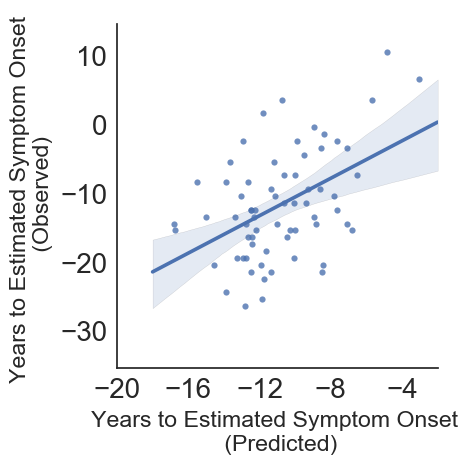

In [2743]:
plt.close()
sns.set(font='Arial')
sns.set(font_scale=2)
sns.set_style('white')
fig = sns.lmplot('Predicted spEYO','Observed spEYO',data=resdf)
sns.plt.ylim(-35,15)
sns.plt.xticks([-20, -16, -12, -8, -4])
sns.plt.xlabel('Years to Estimated Symptom Onset \n (Predicted)',fontsize='x-small')
sns.plt.ylabel('Years to Estimated Symptom Onset \n (Observed)',fontsize='x-small')
#fig.savefig('/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/tPSO_Manuscript/Prediction/Revisions/data/test_acc.pdf')
plt.show()

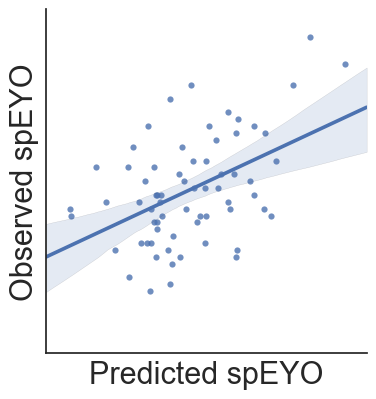

In [2709]:
plt.close()
sns.set_style('white')
fig = sns.lmplot('Predicted spEYO','Observed spEYO',data=resdf)
sns.plt.ylim(-35,15)
sns.plt.xticks([])
sns.plt.yticks([])
#sns.plt.xlabel('Predicted spEYO')
#sns.plt.ylabel('Year to Clinical Conversion')
#fig.savefig('/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/fake_test.pdf')
plt.show()

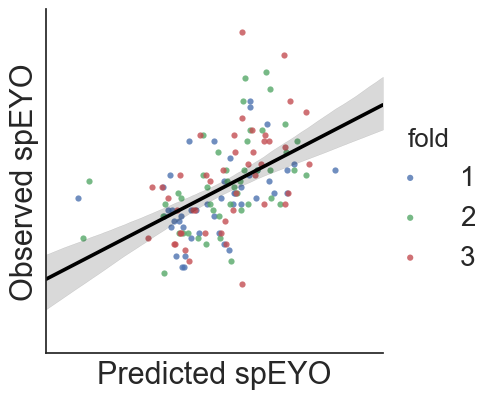

In [2683]:
ldy = ldy.loc[nixtiv_train.index]
vresdf = pandas.concat([(pandas.Series(kmm_predicted,index=nixtiv_train.index)*-1),ldy],axis=1)
vresdf.columns = ['Predicted spEYO','Observed spEYO']
vresdf['fold'] = np.random.permutation(list('1'*46) + list('2'*46) + list('3'*45))
plt.close()
sns.set_style('white')
sns.lmplot('Predicted spEYO','Observed spEYO',data=vresdf,hue='fold',fit_reg=False)
sns.regplot(vresdf['Predicted spEYO'],vresdf['Observed spEYO'],marker=None,color='K')
#sns.plt.ylim(-35,15)
sns.plt.xticks([])
sns.plt.yticks([])
#sns.plt.xlabel('Predicted spEYO')
#sns.plt.ylabel('Year to Clinical Conversion')
#fig.savefig('/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/PAD_predicted_test_inverted.pdf')
plt.show()

In [ ]:
## FULL MATRIX

sns.set(font_scale=2)
jnk = deepcopy(pandas.concat([train,test]))
jnk.index = range(len(jnk))
jnk.columns = range(len(jnk.columns))
plt.close()
heat = sns.heatmap(jnk,xticklabels=100,yticklabels=50,vmin=-3.5,vmax=3.5)
#sns.plt.ylim(-35,15)
#sns.plt.xticks([0, 100, 200, 300, 400])
sns.plt.xlabel('Features')
sns.plt.ylabel('Subjects')
fig = heat.get_figure()
#fig.savefig(
#        '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/mm_full_matrix.pdf')
plt.show()



In [ ]:
## TRAINING MATRIX
sns.set(font_scale=2)
jnk = deepcopy(train)
jnk.index = range(len(jnk))
jnk.columns = range(len(jnk.columns))
plt.close()
heat = sns.heatmap(jnk,xticklabels=100,yticklabels=50,vmin=-3.5,vmax=3.5)
#sns.plt.ylim(-35,15)
#sns.plt.xticks([0, 100, 200, 300, 400])
sns.plt.xlabel('Features')
sns.plt.ylabel('Subjects')
fig = heat.get_figure()
#fig.savefig(
#        '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/mm_train_matrix.pdf')
plt.show()




In [ ]:
# INNER MATRIX
sns.set(font_scale=2)
jnk = deepcopy(train)
jnk.index = range(len(jnk))
jnk.columns = range(len(jnk.columns))
plt.close()
heat = sns.heatmap(jnk.loc[jnk.index[:88]],xticklabels=100,yticklabels=50,vmin=-3.5,vmax=3.5)
#sns.plt.ylim(-35,15)
#sns.plt.xticks([0, 100, 200, 300, 400])
sns.plt.xlabel('Features')
sns.plt.ylabel('Subjects')
fig = heat.get_figure()
#fig.savefig(
#        '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/mm_inner_matrix.pdf')
plt.show()





In [ ]:
# LASSO FEATURE SELECTION
sns.set_style('white')
plt_min, plt_max = 0,100
model = kmm_lasso
m_log_alphas = -np.log10(model.alphas_)
plt.close()
fig = plt.figure()
ymin, ymax = plt_min, plt_max
plt.plot(m_log_alphas, model.mse_path_, ':')
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            linewidth=2, label='alpha: CV estimate')
#plt.axvline(model.alpha_, linestyle='--', color='k',
#            linewidth=2, label='alpha: CV estimate')

plt.legend()

plt.xlabel('-log(alpha)')
#plt.xlabel('alpha')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold')
plt.axis('tight')
plt.ylim(ymin, ymax)
fig.savefig(
        '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/lasso_cv.pdf')
plt.show()

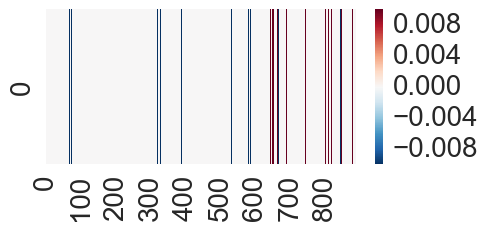

In [2710]:
# FINAL WEIGHTS
plt.close()
fig,ax = plt.subplots(figsize=(5,2))
sns.heatmap(kmm_weights.values[:888].reshape(-1,1).transpose(),xticklabels=100,
            vmin=-0.01,vmax=0.01)
#fig.savefig(
#        '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/weights_vector.pdf',
#        bbox_inches='tight')
plt.show()

In [2711]:
fm2 = deepcopy(fm)
fm2.loc['mean'] = fm.sum(axis=0)

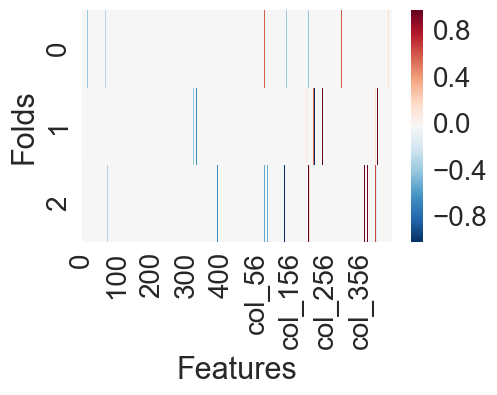

In [2713]:
# FOLD WEIGHTS
plt.close()
fig,ax = plt.subplots(figsize=(5,3))
sns.heatmap(fm,xticklabels=100,vmin = -1, vmax = 1)
sns.plt.xlabel('Features')
sns.plt.ylabel('Folds')
#fig.savefig(
#        '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/weights_matrix.pdf',
#        bbox_inches='tight')
plt.show()

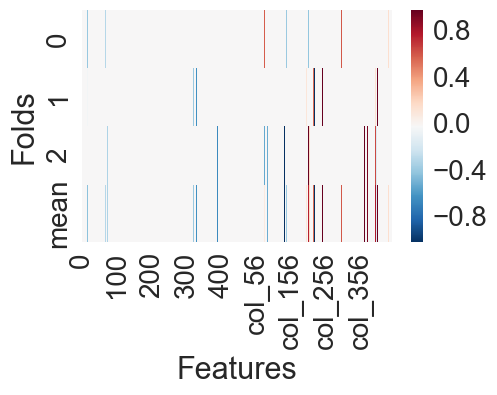

In [2714]:
# all weights
plt.close()
fig,ax = plt.subplots(figsize=(5,3))
sns.heatmap(fm2[fm.columns[:888]],xticklabels=100,vmin = -1, vmax = 1)
sns.plt.xlabel('Features')
sns.plt.ylabel('Folds')
#fig.savefig(
#        '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/weights_matrix.pdf',
#        bbox_inches='tight')
plt.show()

In [ ]:
# CREATE EFFECT MAPS

In [2721]:
hits = [i for i in kmm_weights.index if abs(kmm_weights[i]) > 0 ]
hits
jnk = ni.load('/Users/jakevogel/Science/bellec_lab/aaic/density/networks_scale444.nii.gz')
sc444 = jnk.get_data()
aff = jnk.affine
ref = deepcopy(sc444)
for i in kmm_weights.index[444:889]:
    if i in hits:
        sc444[sc444==(i-443)] = kmm_weights[i]
    else:
        sc444[sc444==(i-443)] = 0
nimg = ni.Nifti1Image(sc444,aff)
nimg.to_filename(
    '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/tPSO_Manuscript/Prediction/Revisions/data/mmLD_k3_0p05_nocov')

In [2716]:
hits = [i for i in kmm_weights.index if abs(kmm_weights[i]) > 0 ]
hits
jnk = ni.load('/Users/jakevogel/Science/bellec_lab/aaic/density/networks_scale444.nii.gz')
sc444 = jnk.get_data()
aff = jnk.affine
ref = deepcopy(sc444)
for i in kmm_weights.index[:444]:
    if i in hits:
        sc444[sc444==(i+1)] = kmm_weights[i]
    else:
        sc444[sc444==(i+1)] = 0
nimg = ni.Nifti1Image(sc444,aff)
nimg.to_filename(
    '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/tPSO_Manuscript/Prediction/Revisions/data/mmGM_k3_0p05_nocov')

In [33]:
pad = pandas.read_csv(
        '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/data/stop_AD_updated_RBANS_longiGM3.csv')
pad.index = pad[pad.columns[1]]

In [35]:
## LOOKING AT SOME OTEHR VARIABLES

cog_cols = pad.columns.tolist()[100:105]
kmm_full_predict = (pandas.concat([mm_train,mm_test]) * np.array(kmm_weights)).sum(axis=1)
#cog_cols += ['ptau_amyloid_ratio']
for col in cog_cols:
    cy = pad.loc[kmm_full_predict.index][col]
    X = kmm_full_predict
    nan_subs = [x for x in cy.index if not pandas.notnull(cy.loc[x])]
    print(col,stats.pearsonr(X.drop(nan_subs).values,cy.drop(nan_subs).values))

NameError: name 'kmm_weights' is not defined

In [2722]:
nind = []
for i in kmm_weights[:887].index:
    if i < 444:
        nind.append('GMV_%s'%(i+1))
    else:
        nind.append('fMRI_%s'%(i-443))

annot_kmm_weights = deepcopy(kmm_weights[:887])
annot_kmm_weights.index = nind
#annot_kmm_weights

In [2724]:
kmm_weights_abs = pandas.Series(abs(annot_kmm_weights.values))
kmm_weights_abs.index = annot_kmm_weights.index
kmm_weights_abs.sort_values(ascending=False)
[(i,j) for i,j in kmm_weights_abs.sort_values(ascending=False).items() if j > 0]
#list(zip(kmm_weights.sort_values()

fMRI_248    0.680343
fMRI_436    0.660230
fMRI_368    0.499331
fMRI_225    0.474217
fMRI_283    0.440562
fMRI_405    0.436681
fMRI_395    0.396359
fMRI_139    0.384399
GMV_243     0.340356
fMRI_212    0.338412
fMRI_95     0.331494
fMRI_407    0.327712
fMRI_377    0.317681
GMV_97      0.309159
fMRI_221    0.300150
fMRI_383    0.297697
fMRI_88     0.282622
fMRI_207    0.282442
fMRI_333    0.280962
fMRI_210    0.274394
fMRI_400    0.270476
fMRI_352    0.266543
fMRI_86     0.263076
fMRI_131    0.262355
fMRI_208    0.259127
GMV_143     0.257747
fMRI_412    0.257498
fMRI_141    0.247089
fMRI_166    0.245818
fMRI_250    0.245317
              ...   
fMRI_96     0.000000
fMRI_94     0.000000
fMRI_93     0.000000
fMRI_117    0.000000
fMRI_119    0.000000
fMRI_147    0.000000
fMRI_133    0.000000
fMRI_146    0.000000
fMRI_144    0.000000
fMRI_143    0.000000
fMRI_142    0.000000
fMRI_140    0.000000
fMRI_138    0.000000
fMRI_137    0.000000
fMRI_136    0.000000
fMRI_135    0.000000
fMRI_134    0

In [2725]:
jnk = pandas.DataFrame(annot_kmm_weights,columns=['weights'])
jnk = jnk.loc[kmm_weights_abs.sort_values(ascending=False).index]

In [2726]:
for reg in jnk.index:
    if 'GMV' in reg:
        jnk.ix[reg,'modality'] = 'GM Volume'
    else:
        jnk.ix[reg,'modality'] = 'rsfMRI Connectivity'

In [2727]:
sns.set(font_scale=1)
sns.set_style('white')

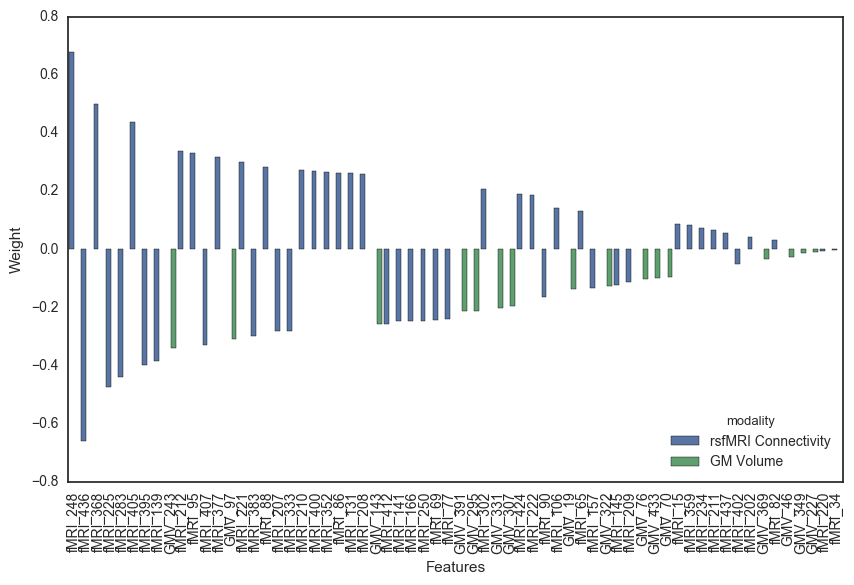

In [2728]:
plt.close()
fig,ax = plt.subplots(figsize=(10,6))
fig = sns.barplot(x = jnk[abs(jnk.weights)>0].index,
            y='weights',
            data=jnk[abs(jnk.weights)>0],
            hue='modality')
for item in fig.get_xticklabels():
    item.set_rotation(90)
sns.plt.xlabel('Features')
sns.plt.ylabel('Weight')
fig = fig.get_figure() 
#fig.savefig(
#        '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/weight_values.pdf',
#        bbox_inches='tight')
plt.show()

## Age analyses

In [2731]:
r,p = stats.pearsonr(np.array(kmmtest_predicted),ld_05.loc[nixtiv_test.index].Age)
print(r,p)
print('r-square is ',r**2)


0.373723196716 0.00183818097323
r-square is  0.139669027764


In [2870]:
0.4087**2

0.16703569000000001

In [2732]:
jnk = [pandas.Series(np.array(kmmtest_predicted),index=ldt_y.index),
      ld_05.loc[nixtiv_test.index].Age,
      ldt_y]
agecon = pandas.concat(jnk,axis=1)
agecon.columns = ['predicted','age','observed']
smf.ols('observed ~ age + predicted',data=agecon).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               observed   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     9.629
Date:                Sun, 24 Dec 2017   Prob (F-statistic):           0.000221
Time:                        16:39:18   Log-Likelihood:                -223.57
No. Observations:                  67   AIC:                             453.1
Df Residuals:                      64   BIC:                             459.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -8.0565     13.051     -0.617      0.539     -34.129      18.016
age            0.1652      0.180      0.918      0.362      -0.195       0.525
predicted      1.2438      0.342      3.638      0.001       0.561       1.927
==============================================================================
Omnibus:                        2.208   Durbin-Watson:                   0.531
Prob(Omnibus):                  0.332   Jarque-Bera (JB):                1.668
Skew:                           0.203   Prob(JB):                        0.434
Kurtosis:                       2.342   Cond. No.                         969.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2875]:
smf.ols('observed ~ age + predicted',data=agecon).fit().summary()

ci = 0.05
distr = []
for c in range(1000):
    rsamp = np.random.choice(agecon.index, len(agecon.index))
    distr.append(smf.ols('observed ~ age + predicted',data=agecon.loc[rsamp]).fit().tvalues[-1])
nci = int(ci*1000)
ci_u = sorted(distr)[1000 - nci]
cim = np.mean(distr)
ci_l = sorted(distr)[(nci)]
print(ci_u, ci_l)

5.92031112113 1.65928058351


In [2878]:
0.589**2

0.346921

In [118]:
pandas.Series(np.array(kmm_predicted),index=ldy.loc[nixtiv_train.index]).index

Int64Index([-28, -26, -25, -25, -24, -24, -23, -23, -22, -22,
            ...
              2,   3,   4,   4,   4,   6,   8,   9,  12,  16],
           dtype='int64', name='tPSO', length=137)

In [120]:
jnk = [pandas.Series(np.array(kmm_predicted),index=ldy.loc[nixtiv_train.index].index),
      ld_05.loc[nixtiv_train.index].Age,
      ldy.loc[nixtiv_train.index]]
agecon = pandas.concat(jnk,axis=1)
agecon.columns = ['predicted','age','observed']
smf.ols('observed ~ age + predicted',data=agecon).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               observed   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     31.80
Date:                Tue, 26 Dec 2017   Prob (F-statistic):           5.01e-12
Time:                        14:05:14   Log-Likelihood:                -454.49
No. Observations:                 137   AIC:                             915.0
Df Residuals:                     134   BIC:                             923.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -46.6420      7.670     -6.081      0.000     -61.811     -31.473
age            0.4368      0.122      3.590      0.000       0.196       0.678
predicted     -0.7286      0.107     -6.797      0.000      -0.941      -0.517
==============================================================================
Omnibus:                       12.366   Durbin-Watson:                   0.585
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.654
Skew:                           0.624   Prob(JB):                      0.00108
Kurtosis:                       3.913   Cond. No.                         852.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [125]:
print(0.505**2)

0.255025


In [122]:
ci = 0.05
distr = []
for c in range(1000):
    rsamp = np.random.choice(agecon.index, len(agecon.index))
    distr.append(smf.ols('observed ~ age + predicted',data=agecon.loc[rsamp]).fit().tvalues[-1])
nci = int(ci*1000)
ci_u = sorted(distr)[1000 - nci]
cim = np.mean(distr)
ci_l = sorted(distr)[(nci)]
print(ci_u, ci_l)

-5.36886861511 -8.37234652228


In [126]:
print(0.4194**2, 0.58483**2)

0.17589636 0.34202612889999995


THIS IS THE OLD WAY

In [44]:
mm2_train = deepcopy(mm_train)
mm2_test = deepcopy(mm_test)
mm2_train.ix[:,'Age'] = ld_05.loc[mm2_train.index].Age
mm2_train.ix[:,"Gender"] = ld_05.loc[mm2_train.index].Gender
mm2_test.ix[:,'Age'] = ld_05.loc[mm2_test.index].Age
mm2_test.ix[:,"Gender"] = ld_05.loc[mm2_test.index].Gender
mm2_train.columns = range(len(mm2_train.columns))
mm2_test.columns = range(len(mm2_test.columns))

In [46]:
gm_train = gm_df.loc[ld_train.index]
gm_test = gm_df.loc[ld_test.index]

gm_train.columns = range(len(gm_train.columns))
gm_test.columns = range(len(gm_test.columns))
gm2_train = deepcopy(gm_train)


gm2_test = deepcopy(gm_test)
gm2_train.ix[:,'Age'] = ld_05.loc[gm2_train.index].Age
gm2_train.ix[:,"Gender"] = ld_05.loc[gm2_train.index].Gender
gm2_test.ix[:,'Age'] = ld_05.loc[gm2_test.index].Age
gm2_test.ix[:,"Gender"] = ld_05.loc[gm2_test.index].Gender
gm2_train.columns = range(len(gm2_train.columns))
gm2_test.columns = range(len(gm2_test.columns))

In [48]:
gm_tmp = deepcopy(gm2_train)
gm_tmp.columns = ['gm_%s'%(x) for x in gm_tmp.columns[:-2]] + ['Age','Gender']
gm_adj_train = pandas.DataFrame(index=gm_tmp.index,columns = range(len(gm_tmp.columns) - 2))
for i in range(gm_tmp.shape[1] - 2):
    mod = smf.ols('gm_%s ~ Age + Gender'%i,data=gm_tmp).fit()
    gm_adj_train[gm_adj_train.columns[i]] = mod.resid

In [49]:
gm_tmp = deepcopy(gm2_test)
gm_tmp.columns = ['gm_%s'%(x) for x in gm_tmp.columns[:-2]] + ['Age','Gender']
gm_adj_test = pandas.DataFrame(index=gm_tmp.index,columns = range(len(gm_tmp.columns) - 2))
for i in range(gm_tmp.shape[1] - 2):
    mod = smf.ols('gm_%s ~ Age + Gender'%i,data=gm_tmp).fit()
    gm_adj_test[gm_adj_test.columns[i]] = mod.resid

In [51]:
ld_tmp = deepcopy(ld_train)
ld_tmp.columns = ['ld_%s'%(x) for x in ld_tmp.columns[:-2]] + ['Age','Gender']
ld_tmp['FD'] = ld_05.loc[ld_tmp.index]['FD']
ld_adj_train = pandas.DataFrame(index=ld_tmp.index,columns = range(len(ld_tmp.columns) - 3))
for i in range(ld_tmp.shape[1] - 3):
    mod = smf.ols('ld_%s ~ Age + Gender + FD'%i,data=ld_tmp).fit()
    ld_adj_train[ld_adj_train.columns[i]] = mod.resid

In [52]:
ld_tmp = deepcopy(ld_test)
ld_tmp.columns = ['ld_%s'%(x) for x in range(len(ld_tmp.columns[:-2]))] + ['Age','Gender']
ld_tmp['FD'] = ld_05.loc[ld_tmp.index]['FD']
ld_adj_test = pandas.DataFrame(index=ld_tmp.index,columns = range(len(ld_tmp.columns) - 3))
for i in range(ld_tmp.shape[1] - 3):
    mod = smf.ols('ld_%s ~ Age + Gender + FD'%i,data=ld_tmp).fit()
    ld_adj_test[ld_adj_test.columns[i]] = mod.resid

In [57]:
# NOW RERUN THE MODZ
ldy = ld_05.loc[ld_adj_train.index].tPSO
ldt_y = ld_05.loc[ld_adj_test.index].tPSO
p_cutoff = 0.05
folds = 3
#out_dir = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/rsfmri_lasso/kfold10_gm_0p001/'
kald_scores, kald_weights, kald_predicted, kaldtest_predicted, kald_int = kfl.kfold_feature_learning(
                                                    ld_adj_train,ld_adj_test,ldy,ldt_y, 
                                                    folds = folds, p_cutoff=p_cutoff, 
                                                    output='light',scale=True)

running correlation for fold 1 of 3
running model for fold 1 of 3
running correlation for fold 2 of 3
running model for fold 2 of 3
running correlation for fold 3 of 3
running model for fold 3 of 3
34 features selected
validation prediction accuracy is 35.0172306618 percent 
 p = 2.1225186089e-14 
 r = -0.591753586063
testing prediction accuracy is 11.0039411079 percent 
 p = 0.00571939132496 
 r = 0.331721888152


In [58]:
tmp = deepcopy(ld_adj_train)
tmp.columns = ['ld_%s'%x for x in tmp.columns]
mm_adj_train = pandas.concat([gm_adj_train,tmp],axis=1)
mm_adj_train.columns = range(mm_adj_train.shape[-1])

tmp = deepcopy(ld_adj_test)
tmp.columns = ['ld_%s'%x for x in tmp.columns]
mm_adj_test = pandas.concat([gm_adj_test,tmp],axis=1)
mm_adj_test.columns = range(mm_adj_test.shape[-1])

In [61]:
# NOW RERUN THE MODZ
ldy = ld_05.loc[mm_adj_train.index].tPSO
ldt_y = ld_05.loc[mm_adj_test.index].tPSO
p_cutoff = 0.05
folds = 3
#out_dir = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/rsfmri_lasso/kfold10_gm_0p001/'
kamm_scores, kamm_weights, kamm_predicted, kammtest_predicted, kamm_int = kfl.kfold_feature_learning(
                                                    mm_adj_train, mm_adj_test, ldy, ldt_y, 
                                                    folds = folds, p_cutoff = p_cutoff, 
                                                    output='light',scale=True)



running correlation for fold 1 of 3
running model for fold 1 of 3


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 2 of 3
running model for fold 2 of 3
running correlation for fold 3 of 3
running model for fold 3 of 3
40 features selected
validation prediction accuracy is 40.5031926258 percent 
 p = 4.91687289466e-17 
 r = -0.636421186211
testing prediction accuracy is 10.6271710824 percent 
 p = 0.00666947625145 
 r = 0.325993421443


Here is the new way

In [3022]:
fage_test.columns

Index(['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7',
       'col_8', 'col_9',
       ...
       'col_col_437', 'col_col_438', 'col_col_439', 'col_col_440',
       'col_col_441', 'col_col_442', 'col_TIV', 'Age', 'Gender', 'FD'],
      dtype='object', length=891)

In [3041]:
fage_test = deepcopy(nixtiv_test)
fage_test.columns = ['col_%s'%x for x in fage_test.columns]
fage_test.loc[:,'Age'] = super_df.loc[fage_test.index,'Age']
fage_test.loc[:,'Gender'] = super_df.loc[fage_test.index,'Gender']
fage_test.loc[:,'FD'] = super_df.loc[fage_test.index,'TIV']
xamm_test = pandas.DataFrame(index = nixtiv_test.index, columns = nixtiv_test.columns)
xamm_test.columns = ['col_%s'%x for x in xamm_test.columns]
for col in fage_test.columns[:-4]:
    mod = smf.ols('%s ~ Age + Gender + FD'%col,data=fage_test).fit()
    xamm_test.loc[:,col] = mod.resid.values
xamm_test[xamm_test.columns[-1]] = nixtiv_test[nixtiv_test.columns[-1]]

In [3042]:
fage_train = deepcopy(nixtiv_train)
fage_train.columns = ['col_%s'%x for x in fage_train.columns]
fage_train.loc[:,'Age'] = super_df.loc[fage_train.index,'Age']
fage_train.loc[:,'Gender'] = super_df.loc[fage_train.index,'Gender']
fage_train.loc[:,'FD'] = super_df.loc[fage_train.index,'TIV']
xamm_train = pandas.DataFrame(index = nixtiv_train.index, columns = nixtiv_train.columns)
xamm_train.columns = ['col_%s'%x for x in xamm_train.columns]
for col in fage_train.columns[:-4]:
    mod = smf.ols('%s ~ Age + Gender + FD'%col,data=fage_train).fit()
    xamm_train.loc[:,col] = mod.resid.values
xamm_train[xamm_train.columns[-1]] = nixtiv_train[nixtiv_train.columns[-1]]

In [2914]:
reload(kfl)

<module 'kfold_learning' from '/Users/jakevogel/git/hack_projects/kfold_learning.py'>

In [3044]:
# NOW RERUN THE MODZ
ldy = ld_05.loc[xamm_train.index].tPSO
ldt_y = ld_05.loc[xamm_test.index].tPSO
p_cutoff = 0.05
folds = 3
ci = 0.05
#out_dir = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/rsfmri_lasso/kfold10_gm_0p001/'
xamm_output = kfl.kfold_feature_learning(xamm_train, xamm_test, ldy, ldt_y, folds = folds, p_cutoff = p_cutoff,
                                         ci = ci, output='light',scale=True)



running correlation for fold 1 of 3
running model for fold 1 of 3


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 2 of 3
running model for fold 2 of 3


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 3 of 3
running model for fold 3 of 3
77 features selected
testing prediction accuracy is 31.6854844398 percent (0.243062644132, 0.403889728952, mean=0.32037125725) 
 p = 8.10172319093e-13 
 r = -0.562898609341
testing prediction accuracy2 is 44.3860415994 percent 
 p = 6.43230150631e-19 
 r = 0.666228501337
testing prediction accuracy is 10.7615198881 percent (0.00519746867667, 0.317733973224, mean=0.128844713008) 
 p = 0.0067264803795 
 r = 0.328047555822


In [3093]:
xmm_test.columns

Index([       0,        1,        2,        3,        4,        5,        6,
              7,        8,        9,
       ...
            883,      884,      885,      886,      887,      888,      889,
            890,    'Age', 'Gender'],
      dtype='object', length=891)

In [56]:
fage_test = deepcopy(xmm_test)
fage_test.columns = ['col_%s'%x for x in fage_test.columns[:-2]] + ['Age', 'Gender']
fage_test.loc[:,'FD'] = super_df.loc[fage_test.index,'FD']
xamm_test2 = pandas.DataFrame(index = xmm_test.index, columns = xmm_test.columns)
xamm_test2.columns = ['col_%s'%x for x in xamm_test2.columns[:-2]] + ['Age', 'Gender']
for col in fage_test.columns[:-3]:
    mod = smf.ols('%s ~ Age + Gender + FD'%col,data=fage_test).fit()
    xamm_test2.loc[:,col] = mod.resid.values
xamm_test2.loc[:,['Age','Gender']] = xmm_test.loc[:,['Age','Gender']].values

In [57]:
fage_train = deepcopy(xmm_train)
fage_train.columns = ['col_%s'%x for x in fage_train.columns[:-2]] + ['Age','Gender']
fage_train.loc[:,'FD'] = super_df.loc[fage_train.index,'FD']
xamm_train2 = pandas.DataFrame(index = xmm_train.index, columns = xmm_train.columns)
xamm_train2.columns = ['col_%s'%x for x in xamm_train2.columns[:-2]] + ['Age', 'Gender']
for col in fage_train.columns[:-3]:
    mod = smf.ols('%s ~ Age + Gender + FD'%col,data=fage_train).fit()
    xamm_train2.loc[:,col] = mod.resid.values
xamm_train2.loc[:,['Age','Gender']] = xmm_train.loc[:,['Age','Gender']].values

In [61]:
#xamm_test2.drop(xamm_test2.columns[890],axis=1,inplace=True)
xamm_train2.drop(xamm_train2.columns[890],axis=1,inplace=True)

In [62]:
ldy = ld_05.loc[ld_train.index].tPSO
ldt_y = ld_05.loc[ld_test.index].tPSO
p_cutoff = 0.05
folds = 3
#out_dir = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/rsfmri_lasso/kfold10_gm_0p001/'
kmaxoutput = kfl.kfold_feature_learning(xamm_train2,xamm_test2,ldy,ldt_y, folds = folds,
                                    p_cutoff = p_cutoff, output='light', scale=True)




running correlation for fold 1 of 3
running model for fold 1 of 3


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 2 of 3
running model for fold 2 of 3
running correlation for fold 3 of 3
running model for fold 3 of 3
51 features selected
validation prediction accuracy is 26.1583010236 percent 
 p = 1.45079511507e-10 
 r = -0.511451865024
testing prediction accuracy2 is 44.6645174486 percent 
 p = 3.38708621442e-19 
 r = 0.668315176011
testing prediction accuracy is 20.2455084282 percent 
 p = 0.000118288048037 
 r = 0.449950090879


## Now including age and other covariates

In [69]:
# I will try now once more with all features plus Age, Gender, TIV and FD included as features

In [70]:
jnk = deepcopy(mm_train)
mm_cov_train = jnk[jnk.columns[:888]]
jnk = deepcopy(mm_test)
mm_cov_test = jnk[jnk.columns[:888]]
cols = ['Age','Gender','FD']
for col in cols:
    mm_cov_train[col] = ld_05.loc[mm_cov_train.index][col]
    mm_cov_test[col] = ld_05.loc[mm_cov_test.index][col]
mm_cov_train['tiv'] = pad.loc[mm_cov_train.index]['tiv']
mm_cov_test['tiv'] = pad.loc[mm_cov_test.index]['tiv']

mm_cov_train.columns = range(len(mm_cov_train.columns))
mm_cov_test.columns = range(len(mm_cov_test.columns))

//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [71]:
ldy = ld_05.loc[mm_cov_train.index].tPSO
ldt_y = ld_05.loc[mm_cov_test.index].tPSO
p_cutoff = 0.05
folds = 3
keep_cols = mm_cov_train.columns[-4:].tolist()
#out_dir = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/rsfmri_lasso/kfold10_gm_0p001/'
kcmm_scores, kcmm_weights, kcmm_predicted, kcmmtest_predicted, kcmm_int = kfl.kfold_feature_learning(
                                                    mm_cov_train, mm_cov_test, ldy, ldt_y, 
                                                    folds = folds, p_cutoff = p_cutoff, 
                                                    output = 'light', scale = True,
                                                    keep_cols = keep_cols)




running correlation for fold 1 of 3
running model for fold 1 of 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:225: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 2 of 3
running model for fold 2 of 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:225: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 3 of 3
running model for fold 3 of 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:225: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


56 features selected
validation prediction accuracy is 31.2850268069 percent 
 p = 9.98935436006e-13 
 r = -0.559330195921
testing prediction accuracy is 21.6227797601 percent 
 p = 6.46558017261e-05 
 r = 0.465003008163


## Regular correlation maps

In [ ]:
### NOW TO GENERATE REGULAR CORRELATION MAPS
gm_tmp = deepcopy(gm2_train)
gm_tmp.columns = ['gm_%s'%(x) for x in gm_tmp.columns[:-2]] + ['Age','Gender']
gm_tmp['tiv'] = pad.loc[gm2_train.index]['tiv']
gm_tmp['tPSO'] = ld_05.loc[gm_tmp.index]['tPSO']
gm_tvals = []
gm_pvals = []
for i in range(gm_tmp.shape[1] - 4):
    mod = smf.ols('tPSO ~ Age + Gender + tiv + gm_%s'%i,data=gm_tmp).fit()
    gm_tvals.append(mod.tvalues[-1])
    gm_pvals.append(mod.pvalues[-1])

In [2794]:
super_df.columns[-14:]

Index(['Age', 'Gender', 'Education', 'TIV', 'FD', 'ApoE4', 'MoCA',
       'immediate_memory_index_score',
       'visuospatial_constructional_index_score', 'lang',
       'attention_index_score', 'delayed_memory_index_score', 'lhipp',
       'rhipp'],
      dtype='object')

In [2808]:
ld_tmp = pandas.DataFrame(nixtiv_train[nixtiv_train.columns[444:887]], copy=True)
for col in ['Age','Gender', 'TIV', 'FD']:
    ld_tmp.loc[:,col] = super_df.loc[ld_tmp.index,col].values
ld_tmp.loc[:,'tPSO'] = ld_05.loc[ld_tmp.index,'tPSO'].values
#ld_tmp.columns = ['ld_%s'%x for x in ld_tmp.columns[:-5]] + ['Age','Gender', 'TIV', 'FD', 'tPSO']
ld_tmp.dropna(inplace=True)
ld_tvals = []
ld_pvals = []
for i in range(ld_tmp.shape[1] - 5):
    mod = smf.ols('tPSO ~ Age + Gender + FD + col_%s'%i,data=ld_tmp).fit()
    ld_tvals.append(mod.tvalues[-1])
    ld_pvals.append(mod.pvalues[-1])

In [ ]:
jnk = ni.load('/Users/jakevogel/Science/bellec_lab/aaic/density/networks_scale444.nii.gz')
sc444 = jnk.get_data()
aff = jnk.affine
ref = deepcopy(sc444)
for i in range(len(gm_pvals)):
    if gm_pvals[i] < 0.05:
        sc444[sc444==(i+1)] = gm_pvals[i]
    else:
        sc444[sc444==(i+1)] = 0
nimg = ni.Nifti1Image(sc444,aff)
nimg.to_filename(
    '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/gm_glm_pvals_tiv')

In [ ]:
jnk = ni.load('/Users/jakevogel/Science/bellec_lab/aaic/density/networks_scale444.nii.gz')
sc444 = jnk.get_data()
aff = jnk.affine
ref = deepcopy(sc444)
for i in range(len(ld_pvals))[:444]:
    if ld_pvals[i] < 0.05:
        sc444[sc444==(i+1)] = ld_pvals[i]
    else:
        sc444[sc444==(i+1)] = 0
nimg = ni.Nifti1Image(sc444,aff)
nimg.to_filename(
    '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/ld_glm_pvals')

In [ ]:
# Now rvalues
jnk = ni.load('/Users/jakevogel/Science/bellec_lab/aaic/density/networks_scale444.nii.gz')
sc444 = jnk.get_data()
aff = jnk.affine
ref = deepcopy(sc444)
for i in range(len(gm_pvals)):
    if gm_pvals[i] < 0.05:
        sc444[sc444==(i+1)] = gm_tvals[i]
    else:
        sc444[sc444==(i+1)] = 0
nimg = ni.Nifti1Image(sc444,aff)
nimg.to_filename(
    '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/gm_glm_tvals_tiv')

In [2809]:
jnk = ni.load('/Users/jakevogel/Science/bellec_lab/aaic/density/networks_scale444.nii.gz')
sc444 = jnk.get_data()
aff = jnk.affine
ref = deepcopy(sc444)
for i in range(len(ld_pvals))[:444]:
    if ld_pvals[i] < 0.05:
        sc444[sc444==(i+1)] = ld_tvals[i]
    else:
        sc444[sc444==(i+1)] = 0
nimg = ni.Nifti1Image(sc444,aff)
nimg.to_filename(
    '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/tPSO_Manuscript/Prediction/Revisions/data/ld_glm_tvals')

## Analysis in ADNI!

In [66]:
adni_gm = pandas.read_csv(
    '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/adni/adni_444_gm.csv')
adni_ld = pandas.read_csv(
        '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/adni/ld_05_444')



In [67]:
adni_gm.index = ['%0.4d'%(x) for x in adni_gm[adni_gm.columns[0]]]
adni_gm.drop(adni_gm.columns[0],axis=1,inplace=True)

In [68]:
adni_ld.index = [x[-4:] for x in adni_ld[adni_ld.columns[0]]]
adni_ld.drop(adni_ld.columns[0],axis=1,inplace=True)

In [69]:
adni_ld.drop([x for x in adni_ld.index if x not in adni_gm.index],axis=0,inplace=True)

In [2744]:
#adni_ld[adni_ld.columns[0:444]]

In [70]:
new_adni_ld = pandas.DataFrame(adni_ld,copy=True)
new_adni_ld.loc[adni_ld.index,new_adni_ld.columns[1:443]] = adni_ld[
                                                        adni_ld.columns[0:442]
                                                                    ].values

In [71]:
jnk = deepcopy(adni_ld)
jnk.columns = ['ld_%s'%(x) for x in new_adni_ld.columns]
adni_mm = pandas.concat([adni_gm,jnk],axis=1)
adni_mm.columns = range(len(adni_mm.columns))
adni_mm.head()

0         1         2         3         4         5         6    \
0107  0.272425  0.408778  0.293263  0.332708  0.180901  0.257986  0.344980   
0186  0.301931  0.436042  0.288299  0.346390  0.188716  0.241736  0.376012   
0295  0.215595  0.421904  0.292742  0.365032  0.205979  0.243235  0.435662   
0685  0.231848  0.373186  0.242312  0.296204  0.213108  0.195514  0.308646   
0729  0.224728  0.341952  0.243393  0.258103  0.172833  0.169088  0.215855   

           7         8         9   ...   878  879  880  881  882  883  884  \
0107  0.328626  0.345354  0.440391 ...    23   29   73   40   60   33   15   
0186  0.303287  0.360085  0.349713 ...    11   16   19   10   14   14    5   
0295  0.355282  0.322558  0.410210 ...    63    5    4   31   16   54    7   
0685  0.238454  0.262957  0.293262 ...    17   13   24   30    8   18    5   
0729  0.221585  0.225657  0.274856 ...    28   46    1   47   48   57   17   

      885  886  887  
0107   29   54   50  
0186   10   23   40  
0295   51   15   97  
0685   34   21   67  
0729    3   15   46  

[5 rows x 888 columns]

In [ ]:
#********************************

In [72]:
adni_mm_s1 = pandas.DataFrame(preprocessing.StandardScaler().fit_transform(adni_mm),
                              index=adni_mm.index,columns = adni_mm.columns)
jnk = preprocessing.StandardScaler().fit(mm_train[mm_train.columns[:888]])
adni_mm_s2 = pandas.DataFrame(jnk.transform(adni_mm), index=adni_mm.index, 
                                                      columns=adni_mm.columns)

In [972]:
# **********************

In [73]:
adni_predicted_kmm = (kmm_weights[:888] * adni_mm).sum(axis=1) + kmm_int
adni_predicted_kmm_s1 = (kmm_weights[:888] * adni_mm_s1).sum(axis=1) + kmm_int
adni_predicted_kmm_s2 = (kmm_weights[:888] * adni_mm_s2).sum(axis=1) + kmm_int

NameError: name 'kmm_weights' is not defined

In [74]:
adni_predicted_kamm = (kamm_weights[:888] * adni_mm).sum(axis=1)
adni_predicted_kamm_s1 = (kamm_weights[:888] * adni_mm_s1).sum(axis=1)
adni_predicted_kamm_s2 = (kamm_weights[:888] * adni_mm_s2).sum(axis=1)

NameError: name 'kamm_weights' is not defined

In [257]:
adni_predicted_kmmp = (kcmm_weights[:888] * adni_mm).sum(axis=1)
adni_predicted_kmmp_s1 = (kcmm_weights[:888] * adni_mm_s1).sum(axis=1)
adni_predicted_kmmp_s2 = (kcmm_weights[:888] * adni_mm_s2).sum(axis=1)

In [75]:
adnidf = pandas.read_csv('/Users/jakevogel/Science/tau/ADNI_MASTER.csv')

In [76]:
adnidf.index = ['%0.4d'%(x) for x in adnidf.RID]
adnidf.head()

RID VISCODE  VISupdate COLPROT ORIGPROT   EXAMDATE DX.bl   AGE PTGENDER  \
0002    2      bl        0.0   ADNI1    ADNI1   9/8/2005    CN  74.3     Male   
0002    2     m06        6.0   ADNI1    ADNI1   3/6/2006    CN  74.3     Male   
0002    2     m36       36.0   ADNI1    ADNI1  8/27/2008    CN  74.3     Male   
0002    2     m60       60.0  ADNIGO    ADNI1  9/22/2010    CN  74.3     Male   
0002    2     m66       66.0  ADNIGO    ADNI1   3/4/2011    CN  74.3     Male   

      PTEDUCAT    ...      Years.bl   Month.bl Month     M  \
0002      16.0    ...      0.000000   0.000000   0.0   0.0   
0002      16.0    ...      0.490075   5.868852   6.0   6.0   
0002      16.0    ...      2.967830  35.540984  36.0  36.0   
0002      16.0    ...      5.037645  60.327869  60.0  60.0   
0002      16.0    ...      5.483915  65.672131  66.0  66.0   

      SUMMARYSUVR_WHOLECEREBNORM  SUMMARYSUVR_WHOLECEREBNORM_1.11CUTOFF  \
0002                         NaN                                    NaN   
0002                         NaN                                    NaN   
0002                         NaN                                    NaN   
0002                         NaN                                    NaN   
0002                         NaN                                    NaN   

      ADNI_MEM  ADNI_EF    DX.conv   DX.final  
0002     0.506   -0.060  NL to MCI  NL to MCI  
0002     0.585   -0.197  NL to MCI  NL to MCI  
0002     0.405   -0.008  NL to MCI  NL to MCI  
0002     0.352   -0.295  NL to MCI  NL to MCI  
0002       NaN      NaN  NL to MCI  NL to MCI  

[5 rows x 208 columns]

In [77]:
adni_bl = adnidf[adnidf.VISCODE == 'bl'].loc[adni_gm.index]

In [78]:
for x in range(adni_bl.shape[0]): 
    try:
        if type(adnidf.loc[adni_bl.index[x]]['DX']) != str:
            if len(adnidf.loc[adni_bl.index[x]]['DX'].dropna().unique()) > 1:
                print(adni_bl.index[x],adni_bl.ix[adni_bl.index[x],'DX.conv'],
                          '\n',list(adnidf.loc[adni_bl.index[x]]['DX'].dropna()),'\n\n')
    except:
        continue

0729 MCI to Dementia 
 ['MCI', 'MCI', 'MCI to Dementia', 'Dementia', 'Dementia', 'Dementia', 'Dementia', 'Dementia', 'Dementia', 'Dementia'] 


0778 MCI to Dementia 
 ['NL', 'NL', 'NL', 'NL', 'NL', 'NL to MCI', 'MCI', 'MCI to Dementia', 'Dementia', 'Dementia', 'Dementia'] 


2010 MCI to NL 
 ['MCI', 'MCI to NL', 'MCI to NL', 'NL', 'NL', 'NL'] 


2018 MCI to NL 
 ['MCI', 'MCI', 'MCI', 'MCI', 'MCI to NL'] 


2022 MCI to NL 
 ['MCI', 'MCI', 'MCI', 'MCI', 'MCI to NL', 'NL'] 


2073 MCI to NL 
 ['MCI', 'MCI', 'MCI', 'MCI', 'MCI', 'MCI to NL', 'NL', 'NL'] 


2180 MCI to NL 
 ['MCI', 'MCI', 'MCI', 'MCI', 'MCI', 'MCI to NL', 'NL'] 


2233 MCI to NL 
 ['MCI', 'MCI', 'MCI', 'MCI', 'MCI', 'MCI to NL'] 


2403 MCI to Dementia 
 ['MCI', 'MCI', 'MCI', 'MCI', 'MCI to Dementia'] 


4042 MCI to Dementia 
 ['MCI', 'MCI', 'MCI', 'MCI to Dementia'] 


4094 MCI to Dementia 
 ['MCI', 'MCI to Dementia', 'Dementia', 'Dementia', 'Dementia', 'Dementia', 'Dementia'] 


4188 MCI to Dementia 
 ['MCI', 'MCI', 'MCI'

In [975]:
adni_bl['adni_predicted_kmm'] = adni_predicted_kmm
adni_bl['adni_predicted_kmm_s1'] = adni_predicted_kmm_s1
adni_bl['adni_predicted_kmm_s2'] = adni_predicted_kmm_s2

adni_bl['adni_predicted_kamm'] = adni_predicted_kamm
adni_bl['adni_predicted_kamm_s1'] = adni_predicted_kamm_s1
adni_bl['adni_predicted_kamm_s2'] = adni_predicted_kamm_s2

adni_bl['adni_predicted_kmmp'] = adni_predicted_kmmp
adni_bl['adni_predicted_kmmp_s1'] = adni_predicted_kmmp_s1
adni_bl['adni_predicted_kmmp_s2'] = adni_predicted_kmmp_s2

In [79]:
cats = ['stable','NL to MCI','MCI to Dementia']
for sub in adni_bl.index:
    if adni_bl.ix[sub,'DX.conv'] in cats:
        adni_bl.ix[sub,'converter_anal'] = 1
        if adni_bl.ix[sub,'DX.conv'] in cats[1:]:
            adni_bl.ix[sub,'converter'] = 1
        else:
            adni_bl.ix[sub,'converter'] = 0
    else:
        adni_bl.ix[sub,'converter_anal'] = 0
        adni_bl.ix[sub,'converter'] = np.nan

In [80]:
conv_df = adnidf.loc[adni_bl[adni_bl.converter == 1].index]

In [81]:
stop = []
for i,row in conv_df.iterrows():
    if i not in stop:
        if pandas.notnull(row['DX']):
            if 'to' in row['DX']:
                print(i,row['DX'],row['Years.bl'])
                adni_bl.ix[i,'conv_time2'] = row['Years.bl']
                stop.append(i)

0729 MCI to Dementia 1.092402464
0778 NL to MCI 4.010951403
2403 MCI to Dementia 3.014373717
4042 MCI to Dementia 1.741273101
4094 MCI to Dementia 0.503764545
4188 MCI to Dementia 2.973305955
4189 MCI to Dementia 0.714579055
4203 MCI to Dementia 1.032169747
4218 NL to MCI 1.018480493
4250 MCI to Dementia 2.034223135
4262 NL to MCI 2.036960986
4270 NL to MCI 4.082135524
4293 MCI to Dementia 2.015058179
4346 MCI to Dementia 3.055441478
4363 MCI to Dementia 3.0171115669999997
4415 MCI to Dementia 2.009582478
4474 NL to MCI 0.45995893200000004
4512 MCI to NL 0.0
4515 MCI to Dementia 0.566735113
4521 MCI to Dementia 2.965092402
4542 MCI to Dementia 0.454483231
4595 MCI to Dementia 0.9691991790000001
4597 MCI to Dementia 3.972621492
4680 MCI to Dementia 0.9774127309999999
4746 MCI to Dementia 3.20054757
4947 MCI to Dementia 0.5092402460000001
5096 NL to MCI 0.517453799


In [82]:
adnidf.ix['4512',['DX','Years.bl']]

DX  Years.bl
4512  MCI to NL  0.000000
4512        NaN  0.213552
4512  NL to MCI  0.511978
4512        MCI  1.122519
4512        NaN  1.535934
4512        MCI  1.984942
4512        NaN  3.003422

In [83]:
adni_bl.ix['4512','DX'] = 'MCI'
adni_bl.ix['4512','conv_time2'] = 0.511978

In [84]:
converters = adni_bl[adni_bl.converter==1]
code = {'NL': 0, 'MCI': 1}
converters['DX_code'] = [code[x] for x in converters['DX']]
code = {'Male': 1, 'Female': 0}
converters['Sex_code'] = [code[x] for x in converters['PTGENDER']]

cols = ['AGE','DX_code','Sex_code','conv_time2']
for col in cols:
    print(col,'mean = ',converters[col].mean())
    print(col,'std = ',converters[col].std())

AGE mean =  72.84444444444443
AGE std =  6.411488086800088
DX_code mean =  0.7777777777777778
DX_code std =  0.42365927286816185
Sex_code mean =  0.48148148148148145
Sex_code std =  0.5091750772173157
conv_time2 mean =  1.8317235748888887
conv_time2 std =  1.2441453993074942


//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [269]:
sns.set_context('notebook')
sns.set_style('white')
sns.set(font_scale=1.5)

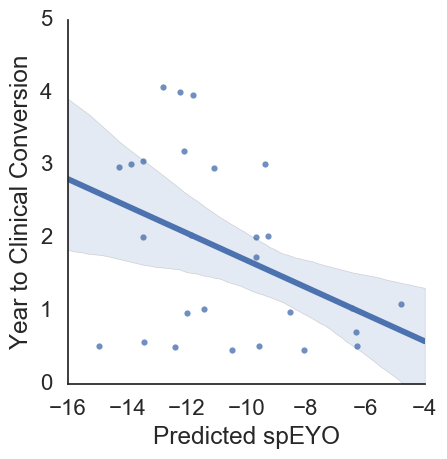

In [976]:
plt.close()
sns.set_style('white')
fig = sns.lmplot('adni_predicted_kmm_s1','conv_time2',data=adni_bl[adni_bl.converter==1])
sns.plt.ylim(0,)
sns.plt.xlabel('Predicted spEYO')
sns.plt.ylabel('Year to Clinical Conversion')
#sns.plt.xticks([-4, 0, 4, 8])
#fig.savefig('/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/adni_conversion.pdf')
plt.show()

In [322]:
jnk = adni_bl[adni_bl.converter==1]['adni_predicted_kmm_s1']
zs = (jnk - jnk.mean()) / jnk.std()
adni_bl = adni_bl.reindex_axis(adni_bl.columns.tolist()+['z_pred'],axis=1)

In [323]:
adni_bl.ix[adni_bl[adni_bl.converter==1].index,'z_pred'] = zs
#adni_bl.loc[adni_bl[adni_bl.converter==1].index]['z_pred'] = zs
adni_bl.loc[adni_bl[adni_bl.converter==1].index]['z_pred']

ValueError: Must have equal len keys and value when setting with an ndarray

In [156]:
adni_bl['inverted_conv2'] = adni_bl.conv_time2 * -1

In [157]:
plt.close()
sns.set_style('white')
fig = sns.lmplot('z_pred','inverted_conv2',data=adni_bl[adni_bl.converter==1])
sns.plt.ylim(-4.5,0.9)
sns.plt.xlabel('Pattern Expression')
sns.plt.ylabel('Year to Clinical Conversion')
sns.plt.xticks([-2.0, -1.0, 0.0, 1.0,2.0])
#fig.savefig('/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/adni_pattern_expression.pdf')
plt.show()

KeyError: "['z_pred'] not in index"

In [977]:
r, p = stats.pearsonr(adni_bl[adni_bl.converter==1]['adni_predicted_kmm_s1'],
              adni_bl[adni_bl.converter==1]['conv_time2'])
print(r,p)
print('r square is',r**2)



-0.404886838089 0.0361737149286
r square is 0.163933351658


In [325]:
r,p = stats.pearsonr(adni_bl[adni_bl.converter==1]['adni_predicted_kmm_s1'],
              adni_bl[adni_bl.converter==1]['AGE'])
print(r,p)
print('r square is',r**2)

-0.164654717487 0.411811290861
r square is 0.0271111759908


In [103]:
r, p = stats.pearsonr(adni_bl[adni_bl.converter==1]['adni_predicted_kmm_s1'],
              adni_bl[adni_bl.converter==1]['conv_time2'])
print(r,p)
print('r square is',r**2)




-0.195503080054 0.328436485248
r square is 0.0382214543106


In [104]:
stats.pearsonr(adni_bl[adni_bl.converter==1]['conv_time2'],
              adni_bl[adni_bl.converter==1]['AGE'])

(-0.048802634076182065, 0.80898910056867634)

In [114]:
jnk = [adni_bl[adni_bl.converter==1]['conv_time2'],
      adni_bl[adni_bl.converter==1]['AGE'],
      adni_bl[adni_bl.converter==1]['adni_predicted_kmm_s1']]
agecon = pandas.concat(jnk,axis=1)
smf.ols('conv_time2 ~ AGE + adni_predicted_kmm_s1',data=agecon).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             conv_time2   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                 -0.042
Method:                 Least Squares   F-statistic:                    0.4769
Date:                Fri, 17 Nov 2017   Prob (F-statistic):              0.626
Time:                        15:52:15   Log-Likelihood:                -43.701
No. Observations:                  27   AIC:                             93.40
Df Residuals:                      24   BIC:                             97.29
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.3685      3.680      0.100      0.921      -7.228       7.965
AGE                       0.0003      0.041      0.007      0.995      -0.084       0.085
adni_predicted_kmm_s1    -0.1194      0.126     -0.946      0.354      -0.380       0.141
==============================================================================
Omnibus:                        4.852   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.088   Jarque-Bera (JB):                2.055
Skew:                           0.333   Prob(JB):                        0.358
Kurtosis:                       1.824   Cond. No.                     1.09e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.09e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [86]:
has_gend = adni_bl[pandas.notnull(adni_bl.PTGENDER)]

In [87]:
code = {'Male': 1, 'Female': 0}
has_gend['Sex_code'] = [code[x] for x in has_gend['PTGENDER']]

//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [88]:
adni_mm_cov = deepcopy(adni_mm)
adni_mm_cov['Age'] = has_gend.loc[adni_mm.index]['AGE']
adni_mm_cov['Gender'] = has_gend.loc[adni_mm.index]['Sex_code']
adni_mm_cov_s1 = pandas.DataFrame(preprocessing.StandardScaler().fit_transform(
                              adni_mm_cov.loc[has_gend.index]),
                              index=has_gend.index,columns = adni_mm_cov.columns)
jnk = preprocessing.StandardScaler().fit(mm_cov_train[mm_cov_train.columns[:890]])
adni_mm_cov_s2 = pandas.DataFrame(jnk.transform(adni_mm_cov.loc[has_gend.index]), 
                                                      index=has_gend.index, 
                                                      columns=adni_mm_cov.columns)



NameError: name 'mm_cov_train' is not defined

In [126]:
#len(kcmm_weights[:890]) == 
adni_mm_cov.loc[has_gend.index].shape

(137, 890)

In [ ]:
#len(kcmm_weights[:890]) == 
adni_mm_cov.loc[has_gend.index].shape

In [127]:
adni_predicted_kcmm = (kcmm_weights[:890] * adni_mm_cov.loc[has_gend.index]).sum(axis=1)
adni_predicted_kcmm_s1 = (kcmm_weights[:890] * adni_mm_cov_s1).sum(axis=1)
adni_predicted_kcmm_s2 = (kcmm_weights[:890] * adni_mm_cov_s2).sum(axis=1)

adni_bl.loc[has_gend.index]['adni_predicted_kcmm'] = adni_predicted_kcmm
adni_bl.loc[has_gend.index]['adni_predicted_kcmm_s1'] = adni_predicted_kcmm_s1
adni_bl.loc[has_gend.index]['adni_predicted_kcmm_s2'] = adni_predicted_kcmm_s2

has_gend['adni_predicted_kcmm'] = adni_predicted_kcmm
has_gend['adni_predicted_kcmm_s1'] = adni_predicted_kcmm_s1
has_gend['adni_predicted_kcmm_s2'] = adni_predicted_kcmm_s2
has_gend.head()

//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexi

RID VISCODE  VISupdate COLPROT ORIGPROT   EXAMDATE DX.bl   AGE  \
0107  107.0      bl        0.0   ADNI1    ADNI1  2/27/2006  LMCI  60.7   
0186  186.0      bl        0.0   ADNI1    ADNI1   3/6/2006    CN  80.4   
0295  295.0      bl        0.0   ADNI1    ADNI1   5/9/2006    CN  84.8   
0685  685.0      bl        0.0   ADNI1    ADNI1  7/20/2006    CN  89.6   
0729  729.0      bl        0.0   ADNI1    ADNI1   8/2/2006  LMCI  65.1   

     PTGENDER  PTEDUCAT           ...           adni_predicted_kmmp_s2  \
0107   Female      19.0           ...                     -1181.315313   
0186   Female      16.0           ...                     -1651.430563   
0295     Male      18.0           ...                     -1465.465169   
0685   Female      16.0           ...                     -1352.923463   
0729   Female      16.0           ...                     -1582.071821   

     converter_anal converter conv_time2    z_pred  inverted_conv2  Sex_code  \
0107            1.0       0.0        NaN       NaN             NaN         0   
0186            1.0       0.0        NaN       NaN             NaN         0   
0295            1.0       0.0        NaN       NaN             NaN         1   
0685            1.0       0.0        NaN       NaN             NaN         0   
0729            1.0       1.0   1.092402 -0.929262       -1.092402         0   

      adni_predicted_kcmm  adni_predicted_kcmm_s1  adni_predicted_kcmm_s2  
0107           -37.210385               -1.721202            -1181.315313  
0186           -45.726078               -2.534392            -1651.430563  
0295           -51.484543               -2.729903            -1465.465169  
0685           -47.979064               -2.010706            -1352.923463  
0729           -30.386663               -3.025210            -1582.071821  

[5 rows x 226 columns]

In [128]:
r,p = stats.pearsonr(has_gend[has_gend.converter==1]['adni_predicted_kcmm_s1'],
              has_gend[has_gend.converter==1]['conv_time2'])
print(r,p)
print('r square is',r**2)

-0.163637818893 0.414745093224
r square is 0.0267773357719


# DEMOGRAPHICS

In [116]:
jnk = pandas.concat([mm_train,mm_test])
ld_05['PSO'] = ld_05['Age'] - ld_05['tPSO']

In [117]:
# DEMOGRAPHICS
cols = ['Age','Gender','FD','tPSO','PSO']
for col in cols:
    mn = ld_05.loc[mm_train.index][col].mean()
    sd = ld_05.loc[mm_train.index][col].std()
    print('training -- %s mean:'%col,mn)
    print('training -- %s sd:'%col,sd)
    mn = ld_05.loc[mm_test.index][col].mean()
    sd = ld_05.loc[mm_test.index][col].std()
    print('test -- %s mean:'%col,mn)
    print('test -- %s sd:'%col,sd)
    mn = ld_05.loc[jnk.index][col].mean()
    sd = ld_05.loc[jnk.index][col].std()
    print('total -- %s mean:'%col,mn)
    print('total -- %s sd:'%col,sd)
    if col != 'Gender':
        t,p = stats.ttest_ind(ld_05.loc[mm_test.index][col], ld_05.loc[mm_train.index][col])
    print(col,'test value = %s, p = %s'%(t,p))

training -- Age mean: 62.89855072463768
training -- Age sd: 4.758840954196224
test -- Age mean: 62.220588235294116
test -- Age sd: 5.296705786253205
total -- Age mean: 62.6747572815534
total -- Age sd: 4.94023241176605
Age test value = -0.925907219727, p = 0.355588243192
training -- Gender mean: 0.2753623188405797
training -- Gender sd: 0.4483239825330468
test -- Gender mean: 0.20588235294117646
test -- Gender sd: 0.4073512375440995
total -- Gender mean: 0.2524271844660194
total -- Gender sd: 0.4354632319488645
Gender test value = -0.925907219727, p = 0.355588243192
training -- FD mean: 0.21698550724637686
training -- FD sd: 0.052498451212086544
test -- FD mean: 0.20980882352941185
test -- FD sd: 0.049281481294653255
total -- FD mean: 0.21461650485436878
total -- FD sd: 0.05144974834058697
FD test value = -0.94119582794, p = 0.3477176974
training -- tPSO mean: -11.173913043478262
training -- tPSO sd: 8.11047177786451
test -- tPSO mean: -11.264705882352942
test -- tPSO sd: 7.77408178972

In [118]:
# DEMOGRAPHICS
cols = ['tiv']
for col in cols:
    mn = pad.loc[mm_train.index][col].mean()
    sd = pad.loc[mm_train.index][col].std()
    print('training -- %s mean:'%col,mn)
    print('training -- %s sd:'%col,sd)
    mn = pad.loc[mm_test.index][col].mean()
    sd = pad.loc[mm_test.index][col].std()
    print('test -- %s mean:'%col,mn)
    print('test -- %s sd:'%col,sd)
    mn = pad.loc[jnk.index][col].mean()
    sd = pad.loc[jnk.index][col].std()
    print('total -- %s mean:'%col,mn)
    print('total -- %s sd:'%col,sd)
    if col != 'Gender':
        t,p = stats.ttest_ind(pad.loc[mm_test.index][col], pad.loc[mm_train.index][col])
    print(col,'test value = %s, p = %s'%(t,p))

training -- tiv mean: 1.397611673913041
training -- tiv sd: 0.18417481231180843
test -- tiv mean: 1.373633794117644
test -- tiv sd: 0.1166424373837528
total -- tiv mean: 1.3896966456310658
total -- tiv sd: 0.1650549891490138
tiv test value = -0.980395666475, p = 0.328052096841


In [119]:
print(pad.loc[mm_train.index]['Gender'].sum())
print(len(pad.loc[mm_train.index]['Gender']) - pad.loc[mm_train.index]['Gender'].sum())
print(pad.loc[mm_test.index]['Gender'].sum())
print(len(pad.loc[mm_test.index]['Gender']) - pad.loc[mm_test.index]['Gender'].sum())

37.0
101.0
14.0
54.0


# REVISIONS

## Using different link densities for the LD

In [22]:
ld_sheetz = sorted(
        glob(
        '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/tPSO_Manuscript/Prediction/Revisions/data/link_density_*'
        ))

In [25]:
idz = pandas.ExcelFile('/Users/jakevogel/Dropbox/Team 1/all_ids.xlsx')
idz = pandas.ExcelFile('/Users/jakevogel/Dropbox/Team 1/all_ids.xlsx').parse(idz.sheet_names[0])
idz.index = idz.CandID

In [2438]:
tst_train = pandas.concat([gm_train, tst.loc[gm_train.index]], axis=1)
tst_test = pandas.concat([gm_test, tst.loc[gm_test.index]], axis=1)

In [2431]:
tst = pandas.read_csv(ld_sheetz[0], index_col=0)
nids = []
for sid in tst.index:
    nids.append(idz.loc[int(sid[1:7])][idz.columns[0]])
tst.index = nids

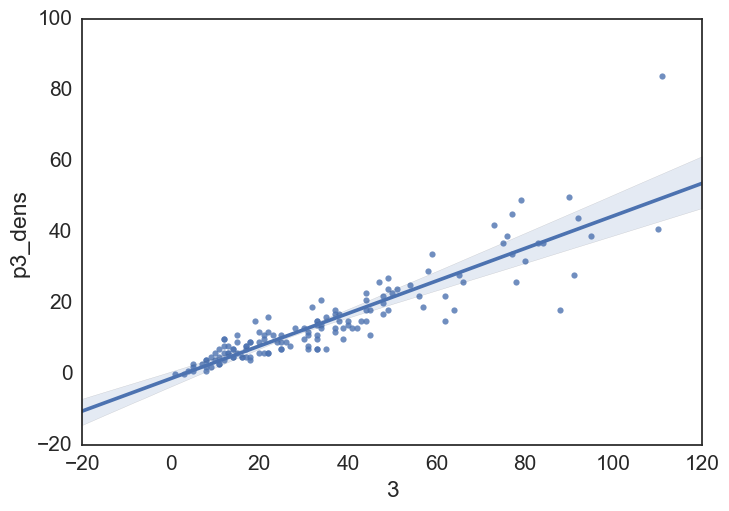

In [2432]:
plt.close()
sns.regplot(tst_train[tst.columns[3]], ld_05.loc[tst_train.index,'p3_dens'])
plt.show()

In [2435]:
rs = []
for i in range(443):
    rs.append(stats.pearsonr(tst_train[tst.columns[i]],ld_05.loc[tst_train.index,'p%s_dens'%i])[0])

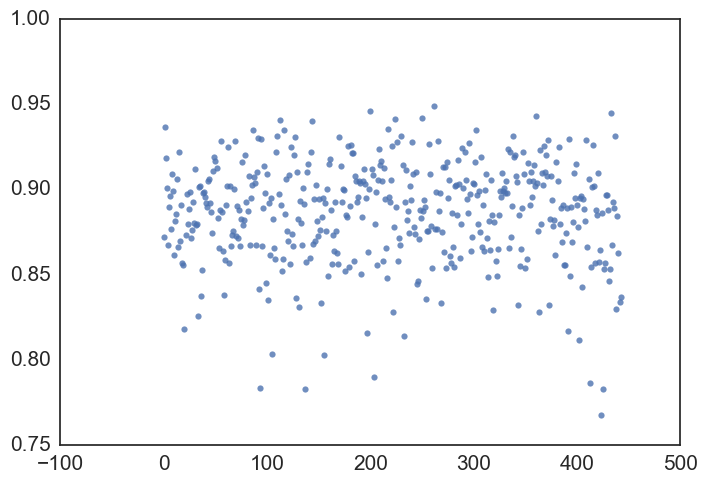

In [2436]:
plt.close()
sns.regplot(np.arange(443), np.array(rs), fit_reg=False)
plt.show()

In [193]:
stats.pearsonr(ldt_y, output[2])

AttributeError: 'list' object has no attribute 'loc'

In [366]:
for sheet in ld_sheetz:
    dens = sheet.split('_')[4]
    rsdf = pandas.read_csv(sheet, index_col=0)
    nids = []
    for sid in rsdf.index:
        nids.append(idz.loc[int(sid[1:7])][idz.columns[0]])
    rsdf.index = nids
    nmmdf_train = pandas.concat([gm2_train, rsdf.loc[gm_train.index]], axis=1)
    nmmdf_test = pandas.concat([gm2_test, rsdf.loc[gm_test.index]], axis=1)
    ldy = ld_05.loc[ld_train.index].tPSO
    ldt_y = ld_05.loc[ld_test.index].tPSO
    p_cutoff = 0.05
    folds = 3
    #out_dir = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/rsfmri_lasso/kfold10_gm_0p001/'
    output = kfold_feature_learning(nmmdf_train, nmmdf_test, ldy, ldt_y, folds = folds,
                                        p_cutoff = p_cutoff, output='light', scale=True)
    print(dens,'===>',output[0])

IndexError: invalid index to scalar variable.

In [182]:
ld_sheetz[0].split('_')[4]

'10'

In [1924]:

reload(kfl)

<module 'kfold_learning' from '/Users/jakevogel/git/hack_projects/kfold_learning.py'>

In [368]:
### LETS TRY THAT AGAIN
ld_sheetz = sorted(
        glob(
        '/Users/jakevogel/Science/bellec_lab/link_densities/ld*'
        ))

In [1819]:
pcuts = [None, 0.05]
for sheet in ld_sheetz:
    for cut in pcuts:
        dens = sheet.split('_')[3]
        rsdf = pandas.read_csv(sheet, index_col=0).transpose()
        rsdf.index = ld_05[ld_05.columns[1]]
        nids = []
        for sid in rsdf.index:
            nids.append(idz.loc[int(sid[1:7])][idz.columns[0]])
        rsdf.index = nids
        nmmdf_train = pandas.concat([gm2_train[gm2_train.columns[:444]], 
                                     rsdf.loc[gm2_train.index]], axis=1)
        nmmdf_test = pandas.concat([gm2_test[gm2_test.columns[:444]], 
                                    rsdf.loc[gm2_test.index]], axis=1)
        ldy = ld_05.loc[ld_train.index].tPSO
        ldt_y = ld_05.loc[ld_test.index].tPSO
        p_cutoff = cut
        folds = 3
        #out_dir = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/rsfmri_lasso/kfold10_gm_0p001/'
        output = kfl.kfold_feature_learning(nmmdf_train, nmmdf_test, ldy, ldt_y, folds = folds,
                                            p_cutoff = p_cutoff, output='light', scale=True)
        print(dens, cut, '===>',output[0])

running model for fold 1 of 3
running model for fold 2 of 3
running model for fold 3 of 3
16 features selected
validation prediction accuracy is 66.4585687574 percent 
 p = 4.58216423767e-34 
 r = -0.815221250688
testing prediction accuracy2 is 23.0987731648 percent 
 p = 2.43288757597e-09 
 r = 0.480611830533
testing prediction accuracy is 15.4193714614 percent 
 p = 0.00092576779655 
 r = 0.392675075112
10 None ===> (23.098773164844392, 15.419371461392759)
running correlation for fold 1 of 3
running model for fold 1 of 3


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 2 of 3
running model for fold 2 of 3


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 3 of 3
running model for fold 3 of 3
41 features selected
validation prediction accuracy is 39.40156726 percent 
 p = 1.73490652892e-16 
 r = -0.627706677199
testing prediction accuracy2 is 33.4353995686 percent 
 p = 1.11367440448e-13 
 r = 0.578233513112
testing prediction accuracy is 9.78188150625 percent 
 p = 0.00941055768849 
 r = 0.312759995943
10 0.05 ===> (33.435399568593468, 9.781881506252148)
running model for fold 1 of 3
running model for fold 2 of 3
running model for fold 3 of 3
39 features selected
validation prediction accuracy is 46.1331945717 percent 
 p = 5.35312463934e-20 
 r = -0.679214211952
testing prediction accuracy2 is 47.5041961629 percent 
 p = 9.14253484538e-21 
 r = 0.689232879097
testing prediction accuracy is 16.7753836165 percent 
 p = 0.000523700703183 
 r = 0.409577631426
2 None ===> (47.504196162874543, 16.77538361648871)
running correlation for fold 1 of 3
running model for fold 1 of 3


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 2 of 3
running model for fold 2 of 3


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 3 of 3
running model for fold 3 of 3
61 features selected
validation prediction accuracy is 28.0315682968 percent 
 p = 2.44606255138e-11 
 r = -0.52944847055
testing prediction accuracy2 is 42.6198523044 percent 
 p = 4.08525779228e-18 
 r = 0.652838818579
testing prediction accuracy is 18.1011217629 percent 
 p = 0.00029824216972 
 r = 0.425454131052
2 0.05 ===> (42.619852304394016, 18.101121762920076)
running model for fold 1 of 3
running model for fold 2 of 3
running model for fold 3 of 3
32 features selected
validation prediction accuracy is 52.1565293239 percent 
 p = 1.58788432867e-23 
 r = -0.72219477514
testing prediction accuracy2 is 47.6456330378 percent 
 p = 7.59916592952e-21 
 r = 0.690258162123
testing prediction accuracy is 11.6197666059 percent 
 p = 0.00444720605745 
 r = 0.34087778757
4 None ===> (47.645633037770722, 11.619766605891739)
running correlation for fold 1 of 3
running model for fold 1 of 3


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 2 of 3
running model for fold 2 of 3


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 3 of 3
running model for fold 3 of 3
43 features selected
validation prediction accuracy is 36.0462502377 percent 
 p = 7.0699115989e-15 
 r = -0.600385294937
testing prediction accuracy2 is 38.381950781 percent 
 p = 5.46428953594e-16 
 r = 0.619531684267
testing prediction accuracy is 13.6157766451 percent 
 p = 0.00195843849551 
 r = 0.368995618471
4 0.05 ===> (38.381950781036025, 13.615776645064951)
running model for fold 1 of 3
running model for fold 2 of 3
running model for fold 3 of 3
23 features selected
validation prediction accuracy is 57.7085730701 percent 
 p = 3.44060003535e-27 
 r = -0.759661589592
testing prediction accuracy2 is 37.1588236559 percent 
 p = 2.1124359296e-15 
 r = 0.60958037744
testing prediction accuracy is 10.1932406577 percent 
 p = 0.00795939454974 
 r = 0.319268549308
5 None ===> (37.158823655942022, 10.193240657741434)
running correlation for fold 1 of 3
running model for fold 1 of 3


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 2 of 3
running model for fold 2 of 3


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 3 of 3
running model for fold 3 of 3
42 features selected
validation prediction accuracy is 43.1390100421 percent 
 p = 2.18908482469e-18 
 r = -0.656802938804
testing prediction accuracy2 is 36.745408849 percent 
 p = 3.31718589889e-15 
 r = 0.606179914291
testing prediction accuracy is 13.6306814325 percent 
 p = 0.00194641789043 
 r = 0.369197527517
5 0.05 ===> (36.745408848999581, 13.630681432470251)
running model for fold 1 of 3
running model for fold 2 of 3
running model for fold 3 of 3
21 features selected
validation prediction accuracy is 58.658483035 percent 
 p = 7.2826898488e-28 
 r = -0.765888262314
testing prediction accuracy2 is 33.84688369 percent 
 p = 7.26246056262e-14 
 r = 0.581780746416
testing prediction accuracy is 12.1660828913 percent 
 p = 0.00355582097085 
 r = 0.348799124014
6 None ===> (33.846883689981695, 12.166082891266566)
running correlation for fold 1 of 3
running model for fold 1 of 3


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 2 of 3
running model for fold 2 of 3


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 3 of 3
running model for fold 3 of 3
37 features selected
validation prediction accuracy is 37.9623814898 percent 
 p = 8.71450007527e-16 
 r = -0.616136198335
testing prediction accuracy2 is 34.6473162297 percent 
 p = 3.13835358767e-14 
 r = 0.588619709403
testing prediction accuracy is 12.7592290241 percent 
 p = 0.00278735910829 
 r = 0.357200630235
6 0.05 ===> (34.64731622971857, 12.759229024051461)
running model for fold 1 of 3
running model for fold 2 of 3
running model for fold 3 of 3
17 features selected
validation prediction accuracy is 62.4678522367 percent 
 p = 9.86518809819e-31 
 r = -0.790366068583
testing prediction accuracy2 is 26.5397879257 percent 
 p = 1.01310341316e-10 
 r = 0.515167816596
testing prediction accuracy is 13.1986727957 percent 
 p = 0.0023261787412 
 r = 0.363299776985
8 None ===> (26.539787925659347, 13.198672795721311)
running correlation for fold 1 of 3
running model for fold 1 of 3


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 2 of 3
running model for fold 2 of 3


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 3 of 3
running model for fold 3 of 3
43 features selected
validation prediction accuracy is 39.9067237361 percent 
 p = 9.75868139636e-17 
 r = -0.631717688023
testing prediction accuracy2 is 34.3843218976 percent 
 p = 4.13900991337e-14 
 r = 0.586381461999
testing prediction accuracy is 10.689773849 percent 
 p = 0.00650140141173 
 r = 0.326952196032
8 0.05 ===> (34.384321897604366, 10.689773849027512)


In [1862]:
reload(kfl)

<module 'kfold_learning' from '/Users/jakevogel/git/hack_projects/kfold_learning.py'>

In [2839]:
# RUN IT TEN REPEATS WITH DIFFERENT FOLDS
pcuts = [None, 0.05]
results_10i = pandas.DataFrame(index = range(120), 
                           columns = ['classic_val', 'big_val', 'test', 'p', 'density'])
rand_sets = []
for i in range(10):
    rand_sets.append(np.random.randint(0,1e6))
num = 0
for sheet in ld_sheetz:
    dens = sheet.split('_')[3]
    rsdf = pandas.read_csv(sheet, index_col=0).transpose()
    rsdf.index = ld_05[ld_05.columns[1]]
    nids = []
    for sid in rsdf.index:
        nids.append(idz.loc[int(sid[1:7])][idz.columns[0]])
    rsdf.index = nids
    for cut in pcuts:
        nmmdf_train = pandas.concat([gm2_train[gm2_train.columns[:444]], 
                                     rsdf.loc[gm2_train.index]], axis=1)
        nmmdf_test = pandas.concat([gm2_test[gm2_test.columns[:444]], 
                                    rsdf.loc[gm2_test.index]], axis=1)
        ldy = ld_05.loc[ld_train.index].tPSO
        ldt_y = ld_05.loc[ld_test.index].tPSO
        p_cutoff = cut
        folds = 3
        for i in range(10):
            print('working on density %s, p = %s, iteration %s of 10'%(dens,cut,i+1))
            mout = kfl.kfold_feature_learning(nmmdf_train, nmmdf_test, ldy, ldt_y, 
                                              folds = folds, p_cutoff = p_cutoff, 
                                              shuffle_k = rand_sets[i], output='light', 
                                              scale=True, verbose = False)
            results_10i.ix[num, ['classic_val','big_val','test']] = mout[0]
            results_10i.ix[num,'p'] = cut
            results_10i.ix[num,'density'] = dens
            results_10i.to_csv(
                    '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/tPSO_Manuscript/Prediction/Revisions/data/10R10k.csv'
                                )
            num += 1

working on density 10, p = None, iteration 1 of 10
testing prediction accuracy2 is 20.381580878 percent 
 p = 2.73614171453e-08 
 r = 0.451459642471
working on density 10, p = None, iteration 2 of 10
testing prediction accuracy2 is 19.0185489737 percent 
 p = 8.96380199325e-08 
 r = 0.43610261377
working on density 10, p = None, iteration 3 of 10
testing prediction accuracy2 is 18.4575385507 percent 
 p = 1.45357327038e-07 
 r = 0.429622375473
working on density 10, p = None, iteration 4 of 10
testing prediction accuracy2 is 9.49498512506 percent 
 p = 0.000236203787363 
 r = 0.308139337396
working on density 10, p = None, iteration 5 of 10
testing prediction accuracy2 is 31.0065031744 percent 
 p = 1.32085781662e-12 
 r = 0.55683483345
working on density 10, p = None, iteration 6 of 10
testing prediction accuracy2 is 14.1010694346 percent 
 p = 5.66866212441e-06 
 r = 0.375513906994
working on density 10, p = None, iteration 7 of 10
testing prediction accuracy2 is 30.1936190064 percen

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 26.2259706233 percent 
 p = 1.36143652354e-10 
 r = 0.512112981903
working on density 10, p = None, iteration 9 of 10
testing prediction accuracy2 is 19.9427729608 percent 
 p = 4.01680336739e-08 
 r = 0.446573319409
working on density 10, p = None, iteration 10 of 10
testing prediction accuracy2 is 18.7247636907 percent 
 p = 1.15501763486e-07 
 r = 0.432721199975
working on density 10, p = 0.05, iteration 1 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 37.5941632814 percent 
 p = 1.3093280945e-15 
 r = 0.613140793631
working on density 10, p = 0.05, iteration 2 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 29.4431703019 percent 
 p = 6.21287022772e-12 
 r = 0.542615612583
working on density 10, p = 0.05, iteration 3 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 39.6595789221 percent 
 p = 1.29389887214e-16 
 r = 0.629758516592
working on density 10, p = 0.05, iteration 4 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 37.695383226 percent 
 p = 1.17097369563e-15 
 r = 0.613965660489
working on density 10, p = 0.05, iteration 5 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 38.5688144414 percent 
 p = 4.43426307296e-16 
 r = 0.621037957305
working on density 10, p = 0.05, iteration 6 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 36.7705222793 percent 
 p = 3.22774931242e-15 
 r = 0.606387023932
working on density 10, p = 0.05, iteration 7 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 40.1477060729 percent 
 p = 7.40394540104e-17 
 r = 0.633622175061
working on density 10, p = 0.05, iteration 8 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 36.2414571569 percent 
 p = 5.72804809487e-15 
 r = 0.602008780309
working on density 10, p = 0.05, iteration 9 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 36.4857861885 percent 
 p = 4.39759692304e-15 
 r = 0.604034652884
working on density 10, p = 0.05, iteration 10 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 36.9011865681 percent 
 p = 2.79941182485e-15 
 r = 0.607463468598
working on density 2, p = None, iteration 1 of 10
testing prediction accuracy2 is 23.7617026711 percent 
 p = 1.33239919547e-09 
 r = 0.487459769325
working on density 2, p = None, iteration 2 of 10
testing prediction accuracy2 is 56.6730988765 percent 
 p = 1.79816058426e-26 
 r = 0.752815374953
working on density 2, p = None, iteration 3 of 10
testing prediction accuracy2 is 54.5172103627 percent 
 p = 4.97874890938e-25 
 r = 0.738357707096
working on density 2, p = None, iteration 4 of 10
testing prediction accuracy2 is 49.0413783113 percent 
 p = 1.19311150503e-21 
 r = 0.700295496996
working on density 2, p = None, iteration 5 of 10
testing prediction accuracy2 is 33.0852555649 percent 
 p = 1.59914817319e-13 
 r = 0.575197840442
working on density 2, p = None, iteration 6 of 10
testing prediction accuracy2 is 4.15708089568e-30 percent 
 p = 1.0 
 r = 2.03889207554e-16
working on den

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 16.7459090389 percent 
 p = 6.24515651452e-07 
 r = 0.409217656497
working on density 2, p = None, iteration 8 of 10
testing prediction accuracy2 is 24.1394069375 percent 
 p = 9.43460942322e-10 
 r = 0.491318704483
working on density 2, p = None, iteration 9 of 10
testing prediction accuracy2 is 12.5552308086 percent 
 p = 2.00985398834e-05 
 r = 0.354333611284
working on density 2, p = None, iteration 10 of 10
testing prediction accuracy2 is 16.4725935772 percent 
 p = 7.86396724398e-07 
 r = 0.405864430287
working on density 2, p = 0.05, iteration 1 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 33.4247287206 percent 
 p = 1.12605235996e-13 
 r = 0.578141234653
working on density 2, p = 0.05, iteration 2 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 47.2311488649 percent 
 p = 1.30463434701e-20 
 r = 0.687249218733
working on density 2, p = 0.05, iteration 3 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 47.4454083866 percent 
 p = 9.87144534028e-21 
 r = 0.688806274555
working on density 2, p = 0.05, iteration 4 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 49.3113611952 percent 
 p = 8.29170389472e-22 
 r = 0.702220486708
working on density 2, p = 0.05, iteration 5 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 52.1181741175 percent 
 p = 1.67741332199e-23 
 r = 0.721929180166
working on density 2, p = 0.05, iteration 6 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 45.609351127 percent 
 p = 1.03948266406e-19 
 r = 0.675346956216
working on density 2, p = 0.05, iteration 7 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 54.4525807786 percent 
 p = 5.48662678618e-25 
 r = 0.737919919629
working on density 2, p = 0.05, iteration 8 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 45.9373092451 percent 
 p = 6.86595726913e-20 
 r = 0.677770678365
working on density 2, p = 0.05, iteration 9 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 48.757790674 percent 
 p = 1.74500286283e-21 
 r = 0.698267790135
working on density 2, p = 0.05, iteration 10 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 48.0179215126 percent 
 p = 4.65987883432e-21 
 r = 0.692949648334
working on density 4, p = None, iteration 1 of 10
testing prediction accuracy2 is 28.0745645642 percent 
 p = 2.34693945936e-11 
 r = 0.529854362671
working on density 4, p = None, iteration 2 of 10
testing prediction accuracy2 is 49.0761372911 percent 
 p = 1.13862532471e-21 
 r = 0.700543626701
working on density 4, p = None, iteration 3 of 10
testing prediction accuracy2 is 37.7045576938 percent 
 p = 1.15917031893e-15 
 r = 0.614040370772
working on density 4, p = None, iteration 4 of 10
testing prediction accuracy2 is 18.0941823332 percent 
 p = 1.98499794851e-07 
 r = 0.425372570028
working on density 4, p = None, iteration 5 of 10
testing prediction accuracy2 is 55.2749109436 percent 
 p = 1.57790223966e-25 
 r = 0.743470987622
working on density 4, p = None, iteration 6 of 10
testing prediction accuracy2 is 21.0397562843 percent 
 p = 1.53292215393e-08 
 r = 0.458691141013
working

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 42.0930408385 percent 
 p = 7.65122046263e-18 
 r = 0.648791498392
working on density 4, p = 0.05, iteration 2 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 42.8320012765 percent 
 p = 3.16800935404e-18 
 r = 0.654461620544
working on density 4, p = 0.05, iteration 3 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 39.8161125146 percent 
 p = 1.08234026253e-16 
 r = 0.631000099165
working on density 4, p = 0.05, iteration 4 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 46.5400475105 percent 
 p = 3.18315425743e-20 
 r = 0.682202664247
working on density 4, p = 0.05, iteration 5 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 43.9674683287 percent 
 p = 7.99502470033e-19 
 r = 0.66307969603
working on density 4, p = 0.05, iteration 6 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 43.1986241061 percent 
 p = 2.03701491257e-18 
 r = 0.657256602143
working on density 4, p = 0.05, iteration 7 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 46.4300990558 percent 
 p = 3.66463385308e-20 
 r = 0.681396353497
working on density 4, p = 0.05, iteration 8 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 37.8403380546 percent 
 p = 9.97599387085e-16 
 r = 0.615145007739
working on density 4, p = 0.05, iteration 9 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 43.6374116235 percent 
 p = 1.19632931357e-18 
 r = 0.660586191374
working on density 4, p = 0.05, iteration 10 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 41.7275980706 percent 
 p = 1.17855157728e-17 
 r = 0.645969024572
working on density 5, p = None, iteration 1 of 10
testing prediction accuracy2 is 24.2217176576 percent 
 p = 8.749119926e-10 
 r = 0.492155642634
working on density 5, p = None, iteration 2 of 10
testing prediction accuracy2 is 39.2384813398 percent 
 p = 2.0869724855e-16 
 r = 0.626406268645
working on density 5, p = None, iteration 3 of 10
testing prediction accuracy2 is 35.0779857436 percent 
 p = 1.99005958607e-14 
 r = 0.592266711403
working on density 5, p = None, iteration 4 of 10
testing prediction accuracy2 is 39.7656278705 percent 
 p = 1.14654747592e-16 
 r = 0.630599935541
working on density 5, p = None, iteration 5 of 10
testing prediction accuracy2 is 37.1359349721 percent 
 p = 2.16604224806e-15 
 r = 0.609392607209
working on density 5, p = None, iteration 6 of 10
testing prediction accuracy2 is 20.6761559512 percent 
 p = 2.11227716386e-08 
 r = 0.454710412804
working on

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 44.5405383 percent 
 p = 3.94914914461e-19 
 r = 0.667386981443
working on density 5, p = 0.05, iteration 2 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 39.3293349481 percent 
 p = 1.88296097258e-16 
 r = 0.627131046497
working on density 5, p = 0.05, iteration 3 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 40.0134430948 percent 
 p = 8.636520297e-17 
 r = 0.632561800102
working on density 5, p = 0.05, iteration 4 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 44.786496586 percent 
 p = 2.91126308745e-19 
 r = 0.669227140708
working on density 5, p = 0.05, iteration 5 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 39.4645137629 percent 
 p = 1.61528540447e-16 
 r = 0.62820787772
working on density 5, p = 0.05, iteration 6 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 46.467338787 percent 
 p = 3.49401729641e-20 
 r = 0.681669559149
working on density 5, p = 0.05, iteration 7 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 45.2182408679 percent 
 p = 1.69913549565e-19 
 r = 0.672445097149
working on density 5, p = 0.05, iteration 8 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 40.4531515162 percent 
 p = 5.20926452424e-17 
 r = 0.636027920112
working on density 5, p = 0.05, iteration 9 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 42.5349877569 percent 
 p = 4.52150954832e-18 
 r = 0.652188529161
working on density 5, p = 0.05, iteration 10 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 43.1981247402 percent 
 p = 2.0382444382e-18 
 r = 0.657252803267
working on density 6, p = None, iteration 1 of 10
testing prediction accuracy2 is 23.9963051438 percent 
 p = 1.07547651855e-09 
 r = 0.489860236637
working on density 6, p = None, iteration 2 of 10
testing prediction accuracy2 is 40.8369157601 percent 
 p = 3.34082233097e-17 
 r = 0.639037680893
working on density 6, p = None, iteration 3 of 10
testing prediction accuracy2 is 35.428378072 percent 
 p = 1.3707916247e-14 
 r = 0.595217423065
working on density 6, p = None, iteration 4 of 10
testing prediction accuracy2 is 10.9404710648 percent 
 p = 7.42085767819e-05 
 r = 0.33076382911
working on density 6, p = None, iteration 5 of 10
testing prediction accuracy2 is 38.3048600749 percent 
 p = 5.95496556565e-16 
 r = 0.618909202347
working on density 6, p = None, iteration 6 of 10
testing prediction accuracy2 is 0.0456447063048 percent 
 p = 0.80357506299 
 r = 0.0213646217624
working on d

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 40.8867442415 percent 
 p = 3.15293129439e-17 
 r = 0.639427433268
working on density 6, p = 0.05, iteration 2 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 36.3554479303 percent 
 p = 5.06412342657e-15 
 r = 0.60295479043
working on density 6, p = 0.05, iteration 3 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 39.030759181 percent 
 p = 2.63885909443e-16 
 r = 0.624746021844
working on density 6, p = 0.05, iteration 4 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 41.6333808529 percent 
 p = 1.31684059686e-17 
 r = 0.64523934205
working on density 6, p = 0.05, iteration 5 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 38.8212310639 percent 
 p = 3.34087431866e-16 
 r = 0.623066858884
working on density 6, p = 0.05, iteration 6 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 40.4213197872 percent 
 p = 5.40410927403e-17 
 r = 0.63577763241
working on density 6, p = 0.05, iteration 7 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 41.2111337123 percent 
 p = 2.16047962195e-17 
 r = 0.641958983988
working on density 6, p = 0.05, iteration 8 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 38.0213888431 percent 
 p = 8.16233672818e-16 
 r = 0.616614862317
working on density 6, p = 0.05, iteration 9 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 40.9976329961 percent 
 p = 2.77137919714e-17 
 r = 0.640293940281
working on density 6, p = 0.05, iteration 10 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 40.6944644298 percent 
 p = 3.9410094227e-17 
 r = 0.637922130278
working on density 8, p = None, iteration 1 of 10
testing prediction accuracy2 is 18.9453379454 percent 
 p = 9.5490489193e-08 
 r = 0.435262425962
working on density 8, p = None, iteration 2 of 10
testing prediction accuracy2 is 19.1476351044 percent 
 p = 8.01694276519e-08 
 r = 0.437580108145
working on density 8, p = None, iteration 3 of 10
testing prediction accuracy2 is 20.7281193346 percent 
 p = 2.01784354663e-08 
 r = 0.455281444104
working on density 8, p = None, iteration 4 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 10.6855451064 percent 
 p = 9.10844527773e-05 
 r = 0.326887520509
working on density 8, p = None, iteration 5 of 10
testing prediction accuracy2 is 28.6650942736 percent 
 p = 1.32655868522e-11 
 r = 0.535397929335
working on density 8, p = None, iteration 6 of 10
testing prediction accuracy2 is 26.508156076 percent 
 p = 1.04379094267e-10 
 r = 0.514860719768
working on density 8, p = None, iteration 7 of 10
testing prediction accuracy2 is 20.2478989795 percent 
 p = 3.07624665323e-08 
 r = 0.449976654722
working on density 8, p = None, iteration 8 of 10
testing prediction accuracy2 is 27.863621168 percent 
 p = 2.87439605508e-11 
 r = 0.527860030386
working on density 8, p = None, iteration 9 of 10
testing prediction accuracy2 is 20.8595522205 percent 
 p = 1.7971938761e-08 
 r = 0.456722587798
working on density 8, p = None, iteration 10 of 10
testing prediction accuracy2 is 21.5079261449 percent 
 p = 1.01253151467e-08 
 r = 0.463766386717
working o

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 40.6557887813 percent 
 p = 4.12154219715e-17 
 r = 0.637618920526
working on density 8, p = 0.05, iteration 2 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 29.1266440028 percent 
 p = 8.46681305963e-12 
 r = 0.5396910598
working on density 8, p = 0.05, iteration 3 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 37.3281952792 percent 
 p = 1.75440227138e-15 
 r = 0.610968045639
working on density 8, p = 0.05, iteration 4 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 39.0039449062 percent 
 p = 2.71985346436e-16 
 r = 0.624531383568
working on density 8, p = 0.05, iteration 5 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 37.6993772499 percent 
 p = 1.16582070588e-15 
 r = 0.613998186071
working on density 8, p = 0.05, iteration 6 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 37.5143096672 percent 
 p = 1.42974297723e-15 
 r = 0.612489262495
working on density 8, p = 0.05, iteration 7 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 41.199212263 percent 
 p = 2.19078073437e-17 
 r = 0.641866125162
working on density 8, p = 0.05, iteration 8 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 37.0241104995 percent 
 p = 2.44784206815e-15 
 r = 0.608474407839
working on density 8, p = 0.05, iteration 9 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 39.745613916 percent 
 p = 1.17302830413e-16 
 r = 0.630441225778
working on density 8, p = 0.05, iteration 10 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 38.4096320975 percent 
 p = 5.29801019178e-16 
 r = 0.619755049172


In [1870]:
#results_10i['density'] = [10]*20 + [2]*20 + [4]*20 + [5]*20 + [6]*20 + [8]*20

In [1880]:
results_10i.p = results_10i.p.astype(str)

In [1896]:
'%s%%'%(5)

'5%'

In [2840]:
results_10i.columns = ['classic_val', 'Validation Accuracy', 'test', 'Feature Selection', 'Link Density Threshold']
#results_10i['Feature Selection'] = ['p < 0.05' if x=='0.05' else x for x in results_10i['Feature Selection']]
#results_10i['Link Density'] = ['%s%%'%x[0] for x in results_10i['Link Density']]
#results_10i['Link Density'] = ['10%' if x == '1%' else x for x in results_10i['Link Density']]
code = code = {'10': '90%', '2': '98%', '4': '96%', '5': '95%', '6': '94%', '8': '92%'}
results_10i['Link Density Threshold'] = [code[x] for x in results_10i['Link Density Threshold']]

In [2847]:
results_10i['Feature Selection'] = results_10i['Feature Selection'].astype(str)

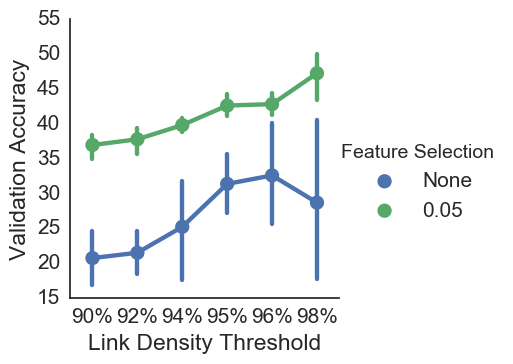

In [2858]:
plt.close()
sns.factorplot(x='Link Density Threshold',y='Validation Accuracy', 
               data= results_10i, hue='Feature Selection',
              order = ['90%', '92%', '94%', '95%', '96%', '98%'])
plt.show()

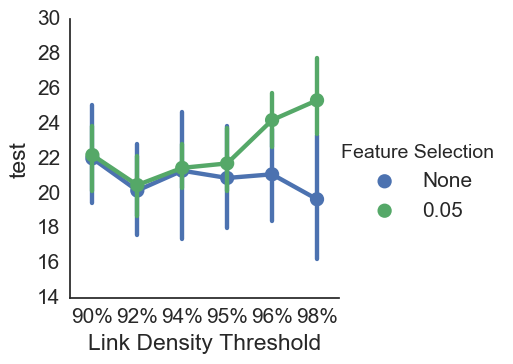

In [2862]:
ch10i = pandas.DataFrame(results_10i,copy=True)
ch10i.loc[:,'test'] = ch10i.test + 9
plt.close()
sns.factorplot(x='Link Density Threshold',y='test', 
               data= ch10i, hue='Feature Selection',
              order = ['90%', '92%', '94%', '95%', '96%', '98%'])
plt.show()

In [2594]:
# RUN IT WITH THE X FACTOR
results_10i = pandas.DataFrame(index = range(120), 
                           columns = ['classic_val', 'big_val', 'test', 'p', 'density'])
rand_sets = []
for i in range(10):
    rand_sets.append(np.random.randint(0,1e6))
num = 0
for sheet in ld_sheetz:
    dens = sheet.split('_')[3]
    rsdf = pandas.read_csv(sheet, index_col=0).transpose()
    rsdf.index = ld_05[ld_05.columns[1]]
    nids = []
    for sid in rsdf.index:
        nids.append(idz.loc[int(sid[1:7])][idz.columns[0]])
    rsdf.index = nids
    for cut in pcuts:
        nmmdf_train = pandas.concat([gm2_train, 
                                     rsdf.loc[gm2_train.index]], axis=1)
        nmmdf_test = pandas.concat([gm2_test, 
                                    rsdf.loc[gm2_test.index]], axis=1)
        ldy = ld_05.loc[ld_train.index].tPSO
        ldt_y = ld_05.loc[ld_test.index].tPSO
        p_cutoff = cut
        folds = 3
        for i in range(10):
            print('working on density %s, p = %s, iteration %s of 10'%(dens,cut,i+1))
            mout = kfl.kfold_feature_learning(nmmdf_train, nmmdf_test, ldy, ldt_y, 
                                              folds = folds, p_cutoff = p_cutoff, 
                                              shuffle_k = rand_sets[i], output='light', 
                                              scale=True, verbose = False)
            results_10i.ix[num, ['classic_val','big_val','test']] = mout[0]
            results_10i.ix[num,'p'] = cut
            results_10i.ix[num,'density'] = dens
            results_10i.to_csv(
                    '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/tPSO_Manuscript/Prediction/Revisions/data/10R10k.csv'
                                )
            num += 1

working on density 10, p = None, iteration 1 of 10
testing prediction accuracy2 is 22.5671673566 percent 
 p = 3.92950479587e-09 
 r = 0.475049127529
working on density 10, p = None, iteration 2 of 10
testing prediction accuracy2 is 16.6918276488 percent 
 p = 6.53688942868e-07 
 r = 0.408556332087
working on density 10, p = None, iteration 3 of 10
testing prediction accuracy2 is 20.2408513645 percent 
 p = 3.09529162754e-08 
 r = 0.449898337011
working on density 10, p = None, iteration 4 of 10
testing prediction accuracy2 is 13.9581319389 percent 
 p = 6.37681507282e-06 
 r = 0.373605834255
working on density 10, p = None, iteration 5 of 10
testing prediction accuracy2 is 14.6525906288 percent 
 p = 3.59440688019e-06 
 r = 0.382787024712
working on density 10, p = None, iteration 6 of 10
testing prediction accuracy2 is 18.6552999509 percent 
 p = 1.22622596034e-07 
 r = 0.431917815688
working on density 10, p = None, iteration 7 of 10
testing prediction accuracy2 is 24.7179141253 per

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 49.4894902468 percent 
 p = 6.51507325947e-22 
 r = 0.703487670445
working on density 10, p = 0.05, iteration 2 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 39.42008338 percent 
 p = 1.69884048329e-16 
 r = 0.627854150102
working on density 10, p = 0.05, iteration 3 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 38.4128661984 percent 
 p = 5.27891169056e-16 
 r = 0.619781140391
working on density 10, p = 0.05, iteration 4 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 40.7367025545 percent 
 p = 3.75274690961e-17 
 r = 0.638253104611
working on density 10, p = 0.05, iteration 5 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 34.3264336961 percent 
 p = 4.39835690525e-14 
 r = 0.585887648752
working on density 10, p = 0.05, iteration 6 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 41.129622997 percent 
 p = 2.37620247316e-17 
 r = 0.641323810543
working on density 10, p = 0.05, iteration 7 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 38.9925913146 percent 
 p = 2.75488181631e-16 
 r = 0.624440480066
working on density 10, p = 0.05, iteration 8 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 38.2627297228 percent 
 p = 6.24122138272e-16 
 r = 0.618568748991
working on density 10, p = 0.05, iteration 9 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 40.2209157513 percent 
 p = 6.80669503758e-17 
 r = 0.634199619609
working on density 10, p = 0.05, iteration 10 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 37.9439124336 percent 
 p = 8.89477409637e-16 
 r = 0.615986302068
working on density 2, p = None, iteration 1 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 23.4109924633 percent 
 p = 1.8332671399e-09 
 r = 0.483849072163
working on density 2, p = None, iteration 2 of 10
testing prediction accuracy2 is 24.3892402821 percent 
 p = 7.50222061227e-10 
 r = 0.493854637339
working on density 2, p = None, iteration 3 of 10
testing prediction accuracy2 is 42.5558367976 percent 
 p = 4.41025765713e-18 
 r = 0.652348348642
working on density 2, p = None, iteration 4 of 10
testing prediction accuracy2 is 42.0465733678 percent 
 p = 8.08446274947e-18 
 r = 0.648433291617
working on density 2, p = None, iteration 5 of 10
testing prediction accuracy2 is 28.022839431 percent 
 p = 2.4666845851e-11 
 r = 0.529366030559
working on density 2, p = None, iteration 6 of 10
testing prediction accuracy2 is 29.0753008147 percent 
 p = 8.90167610343e-12 
 r = 0.539215177964
working on density 2, p = None, iteration 7 of 10
testing prediction accuracy2 is 28.2827637345 percent 
 p = 1.92027944894e-11 
 r = 0.531815416611
working on

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 55.5281674993 percent 
 p = 1.07006921037e-25 
 r = 0.745172245184
working on density 2, p = 0.05, iteration 2 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 48.7319752643 percent 
 p = 1.80626761762e-21 
 r = 0.698082912441
working on density 2, p = 0.05, iteration 3 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 57.0586325854 percent 
 p = 9.75962802339e-27 
 r = 0.755371647505
working on density 2, p = 0.05, iteration 4 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 53.9637499736 percent 
 p = 1.1388644141e-24 
 r = 0.734600231239
working on density 2, p = 0.05, iteration 5 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 48.3725496347 percent 
 p = 2.91515497376e-21 
 r = 0.695503771627
working on density 2, p = 0.05, iteration 6 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 54.1455985777 percent 
 p = 8.68709439533e-25 
 r = 0.735836928794
working on density 2, p = 0.05, iteration 7 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 53.8791691984 percent 
 p = 1.29125528904e-24 
 r = 0.734024312938
working on density 2, p = 0.05, iteration 8 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 46.6355125889 percent 
 p = 2.81606478526e-20 
 r = 0.682901988494
working on density 2, p = 0.05, iteration 9 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 48.841904973 percent 
 p = 1.55925018887e-21 
 r = 0.698869837473
working on density 2, p = 0.05, iteration 10 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 48.4542601914 percent 
 p = 2.61534199157e-21 
 r = 0.696090943709
working on density 4, p = None, iteration 1 of 10
testing prediction accuracy2 is 37.6889730247 percent 
 p = 1.17929095563e-15 
 r = 0.613913455014
working on density 4, p = None, iteration 2 of 10
testing prediction accuracy2 is 42.2185190122 percent 
 p = 6.59239786169e-18 
 r = 0.649757793429
working on density 4, p = None, iteration 3 of 10
testing prediction accuracy2 is 33.8030862314 percent 
 p = 7.60149879047e-14 
 r = 0.581404215941
working on density 4, p = None, iteration 4 of 10
testing prediction accuracy2 is 45.0648213222 percent 
 p = 2.05841941343e-19 
 r = 0.671303368993
working on density 4, p = None, iteration 5 of 10
testing prediction accuracy2 is 35.4821176364 percent 
 p = 1.29439487035e-14 
 r = 0.595668680026
working on density 4, p = None, iteration 6 of 10
testing prediction accuracy2 is 33.4238119939 percent 
 p = 1.12712204954e-13 
 r = 0.578133306374
working

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 52.1447052662 percent 
 p = 1.61496988137e-23 
 r = 0.722112908527
working on density 4, p = 0.05, iteration 2 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 47.5793930001 percent 
 p = 8.28705468262e-21 
 r = 0.689778174489
working on density 4, p = 0.05, iteration 3 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 48.5546203263 percent 
 p = 2.28842613853e-21 
 r = 0.696811454601
working on density 4, p = 0.05, iteration 4 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 47.6431815533 percent 
 p = 7.62359072575e-21 
 r = 0.690240404158
working on density 4, p = 0.05, iteration 5 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 45.6039274783 percent 
 p = 1.04661504154e-19 
 r = 0.675306800486
working on density 4, p = 0.05, iteration 6 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 47.7026117102 percent 
 p = 7.05270947615e-21 
 r = 0.690670773308
working on density 4, p = 0.05, iteration 7 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 46.3327604519 percent 
 p = 4.15035045998e-20 
 r = 0.680681720424
working on density 4, p = 0.05, iteration 8 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 52.2433054169 percent 
 p = 1.40234622011e-23 
 r = 0.722795305857
working on density 4, p = 0.05, iteration 9 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 42.7613353798 percent 
 p = 3.44838443325e-18 
 r = 0.653921519601
working on density 4, p = 0.05, iteration 10 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 43.5460969802 percent 
 p = 1.33689749988e-18 
 r = 0.659894665687
working on density 5, p = None, iteration 1 of 10
testing prediction accuracy2 is 31.5896290114 percent 
 p = 7.35058661723e-13 
 r = 0.562046519528
working on density 5, p = None, iteration 2 of 10
testing prediction accuracy2 is 33.8754688828 percent 
 p = 7.04926902405e-14 
 r = 0.582026364376
working on density 5, p = None, iteration 3 of 10
testing prediction accuracy2 is 31.4930600958 percent 
 p = 8.10245788052e-13 
 r = 0.56118677903
working on density 5, p = None, iteration 4 of 10
testing prediction accuracy2 is 41.5939697147 percent 
 p = 1.37932413917e-17 
 r = 0.644933870367
working on density 5, p = None, iteration 5 of 10
testing prediction accuracy2 is 37.2509996354 percent 
 p = 1.90948269023e-15 
 r = 0.610335970064
working on density 5, p = None, iteration 6 of 10
testing prediction accuracy2 is 31.6615282867 percent 
 p = 6.83588753324e-13 
 r = 0.562685776315
working 

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 45.394714042 percent 
 p = 1.36182266892e-19 
 r = 0.673755994719
working on density 5, p = 0.05, iteration 2 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 45.8967642913 percent 
 p = 7.22814100094e-20 
 r = 0.677471507085
working on density 5, p = 0.05, iteration 3 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 46.2313418607 percent 
 p = 4.72391719667e-20 
 r = 0.679936334231
working on density 5, p = 0.05, iteration 4 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 41.7696545836 percent 
 p = 1.12154178771e-17 
 r = 0.646294473004
working on density 5, p = 0.05, iteration 5 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 44.1471000379 percent 
 p = 6.41409088151e-19 
 r = 0.664432841135
working on density 5, p = 0.05, iteration 6 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 45.291022375 percent 
 p = 1.55105788794e-19 
 r = 0.672986050189
working on density 5, p = 0.05, iteration 7 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 46.1283893183 percent 
 p = 5.38596608564e-20 
 r = 0.679178837408
working on density 5, p = 0.05, iteration 8 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 44.3534352649 percent 
 p = 4.97568969742e-19 
 r = 0.665983748037
working on density 5, p = 0.05, iteration 9 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 42.1753094653 percent 
 p = 6.9396019118e-18 
 r = 0.649425203278
working on density 5, p = 0.05, iteration 10 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 42.7666604826 percent 
 p = 3.42643045525e-18 
 r = 0.653962235015
working on density 6, p = None, iteration 1 of 10
testing prediction accuracy2 is 30.5253055794 percent 
 p = 2.13481953932e-12 
 r = 0.552497109308
working on density 6, p = None, iteration 2 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 11.9184206212 percent 
 p = 3.37029393359e-05 
 r = 0.345230656536
working on density 6, p = None, iteration 3 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 29.9537332106 percent 
 p = 3.76054820528e-12 
 r = 0.547300038467
working on density 6, p = None, iteration 4 of 10
testing prediction accuracy2 is 36.5942339872 percent 
 p = 3.90955464866e-15 
 r = 0.604931681987
working on density 6, p = None, iteration 5 of 10
testing prediction accuracy2 is 21.6514493474 percent 
 p = 8.91254616529e-09 
 r = 0.465311179184
working on density 6, p = None, iteration 6 of 10
testing prediction accuracy2 is 25.589688222 percent 
 p = 2.46986401105e-10 
 r = 0.505862513159
working on density 6, p = None, iteration 7 of 10
testing prediction accuracy2 is 29.2468768974 percent 
 p = 7.52877616466e-12 
 r = 0.540803817455
working on density 6, p = None, iteration 8 of 10
testing prediction accuracy2 is 31.152681354 percent 
 p = 1.14088640302e-12 
 r = 0.558145871202
working on density 6, p = None, iteration 9 of 10
testing prediction accuracy2 is 34.1291448544 percent 
 p = 5.40849056715e-14 
 r = 0.584201547878
working o

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 39.580136908 percent 
 p = 1.41636711737e-16 
 r = 0.629127466481
working on density 6, p = 0.05, iteration 1 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 42.9523533781 percent 
 p = 2.74131806084e-18 
 r = 0.655380449648
working on density 6, p = 0.05, iteration 2 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 43.018410806 percent 
 p = 2.53174827356e-18 
 r = 0.655884218487
working on density 6, p = 0.05, iteration 3 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 44.317372817 percent 
 p = 5.2018375067e-19 
 r = 0.665712947275
working on density 6, p = 0.05, iteration 4 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 38.7543650374 percent 
 p = 3.6014795365e-16 
 r = 0.622530039737
working on density 6, p = 0.05, iteration 5 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 42.3168695478 percent 
 p = 5.86468977274e-18 
 r = 0.650514177769
working on density 6, p = 0.05, iteration 6 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 44.8059672998 percent 
 p = 2.84167147936e-19 
 r = 0.66937259654
working on density 6, p = 0.05, iteration 7 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 39.7026794007 percent 
 p = 1.23188659389e-16 
 r = 0.630100622129
working on density 6, p = 0.05, iteration 8 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 41.701927031 percent 
 p = 1.21474417972e-17 
 r = 0.645770292217
working on density 6, p = 0.05, iteration 9 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 38.7394418212 percent 
 p = 3.66232234573e-16 
 r = 0.622410168789
working on density 6, p = 0.05, iteration 10 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 40.5497801103 percent 
 p = 4.65923355437e-17 
 r = 0.636787092444
working on density 8, p = None, iteration 1 of 10
testing prediction accuracy2 is 24.2909838939 percent 
 p = 8.21053112779e-10 
 r = 0.492858842813
working on density 8, p = None, iteration 2 of 10
testing prediction accuracy2 is 26.218126479 percent 
 p = 1.37150992365e-10 
 r = 0.512036390103
working on density 8, p = None, iteration 3 of 10
testing prediction accuracy2 is 25.5313982899 percent 
 p = 2.60776108974e-10 
 r = 0.505286040673
working on density 8, p = None, iteration 4 of 10
testing prediction accuracy2 is 18.8172822428 percent 
 p = 1.06648305945e-07 
 r = 0.433788914598
working on density 8, p = None, iteration 5 of 10
testing prediction accuracy2 is 20.9543133353 percent 
 p = 1.6530613829e-08 
 r = 0.457758815702
working on density 8, p = None, iteration 6 of 10
testing prediction accuracy2 is 9.59169759561 percent 
 p = 0.000218659501 
 r = 0.309704659242
working on d

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 45.1835726426 percent 
 p = 1.77448628322e-19 
 r = 0.672187270354
working on density 8, p = 0.05, iteration 2 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 34.879700713 percent 
 p = 2.45532202602e-14 
 r = 0.59059038862
working on density 8, p = 0.05, iteration 3 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 38.1523487534 percent 
 p = 7.05712788411e-16 
 r = 0.617675875791
working on density 8, p = 0.05, iteration 4 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 38.5449960955 percent 
 p = 4.55406133338e-16 
 r = 0.62084616529
working on density 8, p = 0.05, iteration 5 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 35.9021906349 percent 
 p = 8.2546446276e-15 
 r = 0.599184367578
working on density 8, p = 0.05, iteration 6 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 42.149776938 percent 
 p = 7.15317332611e-18 
 r = 0.649228595627
working on density 8, p = 0.05, iteration 7 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 39.1876206699 percent 
 p = 2.2105383419e-16 
 r = 0.626000165095
working on density 8, p = 0.05, iteration 8 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 39.8786928796 percent 
 p = 1.0076521231e-16 
 r = 0.63149578684
working on density 8, p = 0.05, iteration 9 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 36.5262888037 percent 
 p = 4.20867244384e-15 
 r = 0.604369827206
working on density 8, p = 0.05, iteration 10 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 39.3164568821 percent 
 p = 1.91063532135e-16 
 r = 0.627028363649


In [2199]:
# SAME ANALYSIS BUT ACROSS DATASETS AND NOT WITH OR WITHOUT P-SELECTION
results_10i = pandas.DataFrame(index = range(180), 
                           columns = ['classic_val', 'big_val', 'test', 'DS', 'density'])
num = 0
for sheet in ld_sheetz:
    dens = sheet.split('_')[3]
    rsdf = pandas.read_csv(sheet, index_col=0).transpose()
    rsdf.index = ld_05[ld_05.columns[1]]
    nids = []
    for sid in rsdf.index:
        nids.append(idz.loc[int(sid[1:7])][idz.columns[0]])
    rsdf.index = nids
    nmmdf_train = pandas.concat([super_train[super_train.columns[:444]], 
                                     rsdf.loc[gm2_train.index], 
                                 super_train[super_train.columns[-14:]]], axis=1).dropna()
    nmmdf_test = pandas.concat([super_test[super_test.columns[:444]], 
                                    rsdf.loc[gm2_test.index],
                               super_test[super_test.columns[-14:]]], axis=1).dropna()
    ldy = ld_05.loc[ld_train.index].tPSO
    ldt_y = ld_05.loc[ld_test.index].tPSO
    p_cutoff = 0.5
    folds = 3
    for i in range(10):
        print('working on density %s, DS = Model 1, iteration %s of 10'%(dens,i+1))
        mout = kfl.kfold_feature_learning(nmmdf_train, nmmdf_test, ldy, ldt_y, 
                                          folds = folds, p_cutoff = p_cutoff, 
                                          shuffle_k = rand_sets[i], output='light', 
                                          scale=True, verbose = False, keep_cols = super_train.columns[-14:])
        results_10i.ix[num, ['classic_val','big_val','test']] = mout[0]
        results_10i.ix[num,'DS'] = 'Model 3'
        results_10i.ix[num,'density'] = dens
        results_10i.to_csv(
                '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/tPSO_Manuscript/Prediction/Revisions/data/10RAllmods.csv'
                            )
        num += 1
    for i in range(10):
        print('working on density %s, DS = Model 2, iteration %s of 10'%(dens,i+1))
        mout = kfl.kfold_feature_learning(nmmdf_train[nmmdf_train.columns[-14:]], 
                                          nmmdf_test[nmmdf_train.columns[-14:]], 
                                          ldy, ldt_y, folds = folds, p_cutoff = p_cutoff, 
                                          shuffle_k = rand_sets[i], output='light', 
                                          scale=True, verbose = False, keep_cols = super_train.columns[-14:])
        results_10i.ix[num, ['classic_val','big_val','test']] = mout[0]
        results_10i.ix[num,'DS'] = 'Model 2'
        results_10i.ix[num,'density'] = dens
        results_10i.to_csv(
                '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/tPSO_Manuscript/Prediction/Revisions/data/10RAllmods.csv'
                            )
        num += 1
    for i in range(10):
        print('working on density %s, DS = Model 3, iteration %s of 10'%(dens,i+1))
        mout = kfl.kfold_feature_learning(nmmdf_train[nmmdf_train.columns[:887]], 
                                          nmmdf_test[nmmdf_train.columns[:887]], 
                                          ldy, ldt_y, folds = folds, p_cutoff = p_cutoff, 
                                          shuffle_k = rand_sets[i], output='light', 
                                          scale=True, verbose = False)
        results_10i.ix[num, ['classic_val','big_val','test']] = mout[0]
        results_10i.ix[num,'DS'] = 'Model 1'
        results_10i.ix[num,'density'] = dens
        results_10i.to_csv(
                '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/tPSO_Manuscript/Prediction/Revisions/data/10RAllmods.csv'
                            )
        num += 1

working on density 10, DS = Model 1, iteration 1 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 48.3692708327 percent 
 p = 4.08950096091e-21 
 r = 0.695480199809
working on density 10, DS = Model 1, iteration 2 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 49.2213977722 percent 
 p = 1.31865187087e-21 
 r = 0.70157963035
working on density 10, DS = Model 1, iteration 3 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 27.3202698674 percent 
 p = 5.68932383407e-11 
 r = 0.522687955356
working on density 10, DS = Model 1, iteration 4 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 48.2130291123 percent 
 p = 5.02260846766e-21 
 r = 0.694356026202
working on density 10, DS = Model 1, iteration 5 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 33.6359784377 percent 
 p = 1.11423493864e-13 
 r = 0.579965330323
working on density 10, DS = Model 1, iteration 6 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 47.437902747 percent 
 p = 1.37996236536e-20 
 r = 0.688751789449
working on density 10, DS = Model 1, iteration 7 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 57.355590595 percent 
 p = 9.33354824812e-27 
 r = 0.757334738375
working on density 10, DS = Model 1, iteration 8 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 57.9772632076 percent 
 p = 3.44559329616e-27 
 r = 0.761428021599
working on density 10, DS = Model 1, iteration 9 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 20.7905761774 percent 
 p = 2.15341791515e-08 
 r = 0.455966842845
working on density 10, DS = Model 1, iteration 10 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 42.5607268146 percent 
 p = 5.80615111094e-18 
 r = 0.652385827671
working on density 10, DS = Model 2, iteration 1 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 14.6654179657 percent 
 p = 3.86310081463e-06 
 r = 0.382954539935
working on density 10, DS = Model 2, iteration 2 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 11.8750692737 percent 
 p = 3.73097623636e-05 
 r = 0.34460222393
working on density 10, DS = Model 2, iteration 3 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 16.1489801826 percent 
 p = 1.13125321215e-06 
 r = 0.401857937368
working on density 10, DS = Model 2, iteration 4 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 13.1350315296 percent 
 p = 1.34850450962e-05 
 r = 0.362422840472
working on density 10, DS = Model 2, iteration 5 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 14.9116696836 percent 
 p = 3.1542985659e-06 
 r = 0.386156311403
working on density 10, DS = Model 2, iteration 6 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 12.9312112471 percent 
 p = 1.5908915195e-05 
 r = 0.359599933914
working on density 10, DS = Model 2, iteration 7 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 15.1844133714 percent 
 p = 2.5186679896e-06 
 r = 0.389671828227
working on density 10, DS = Model 2, iteration 8 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 13.3996515642 percent 
 p = 1.08761161562e-05 
 r = 0.366055345053
working on density 10, DS = Model 2, iteration 9 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 12.9276906993 percent 
 p = 1.59543651416e-05 
 r = 0.359550979685
working on density 10, DS = Model 2, iteration 10 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 13.2230841082 percent 
 p = 1.25545987874e-05 
 r = 0.363635588305
working on density 10, DS = Model 3, iteration 1 of 10
testing prediction accuracy2 is 42.984661533 percent 
 p = 3.50463905016e-18 
 r = 0.655626887284
working on density 10, DS = Model 3, iteration 2 of 10
testing prediction accuracy2 is 43.9283606345 percent 
 p = 1.12410911712e-18 
 r = 0.662784736053
working on density 10, DS = Model 3, iteration 3 of 10
testing prediction accuracy2 is 24.8907689319 percent 
 p = 5.47208622791e-10 
 r = 0.498906493563
working on density 10, DS = Model 3, iteration 4 of 10
testing prediction accuracy2 is 32.5401865033 percent 
 p = 3.41949534691e-13 
 r = 0.570440062612
working on density 10, DS = Model 3, iteration 5 of 10
testing prediction accuracy2 is 28.2033415195 percent 
 p = 2.45540824482e-11 
 r = 0.531068183188
working on density 10, DS = Model 3, iteration 6 of 10
testing prediction accuracy2 is 41.3926463908 percent 
 p = 2.29031465686e-17

/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 51.8167591182 percent 
 p = 3.72661253012e-23 
 r = 0.719838586894
working on density 2, DS = Model 1, iteration 2 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 37.6525917206 percent 
 p = 1.56031487256e-15 
 r = 0.613617077016
working on density 2, DS = Model 1, iteration 3 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 63.8424367823 percent 
 p = 1.28848578764e-31 
 r = 0.799014623034
working on density 2, DS = Model 1, iteration 4 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 53.1922463766 percent 
 p = 5.20894048063e-24 
 r = 0.729330147304
working on density 2, DS = Model 1, iteration 5 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 26.5471534141 percent 
 p = 1.17806595667e-10 
 r = 0.51523929794
working on density 2, DS = Model 1, iteration 6 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 62.0782301552 percent 
 p = 3.25509701656e-30 
 r = 0.787897392782
working on density 2, DS = Model 1, iteration 7 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 50.4958202847 percent 
 p = 2.34213772367e-22 
 r = 0.710604111195
working on density 2, DS = Model 1, iteration 8 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 63.8386981155 percent 
 p = 1.29754684292e-31 
 r = 0.798991227208
working on density 2, DS = Model 1, iteration 9 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 15.4195324322 percent 
 p = 2.07360384723e-06 
 r = 0.392677124775
working on density 2, DS = Model 1, iteration 10 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 34.7381301587 percent 
 p = 3.542549647e-14 
 r = 0.589390618849
working on density 2, DS = Model 2, iteration 1 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 14.6654179657 percent 
 p = 3.86310081463e-06 
 r = 0.382954539935
working on density 2, DS = Model 2, iteration 2 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 11.8750692737 percent 
 p = 3.73097623636e-05 
 r = 0.34460222393
working on density 2, DS = Model 2, iteration 3 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 16.1489801826 percent 
 p = 1.13125321215e-06 
 r = 0.401857937368
working on density 2, DS = Model 2, iteration 4 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 13.1350315296 percent 
 p = 1.34850450962e-05 
 r = 0.362422840472
working on density 2, DS = Model 2, iteration 5 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 14.9116696836 percent 
 p = 3.1542985659e-06 
 r = 0.386156311403
working on density 2, DS = Model 2, iteration 6 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 12.9312112471 percent 
 p = 1.5908915195e-05 
 r = 0.359599933914
working on density 2, DS = Model 2, iteration 7 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 15.1844133714 percent 
 p = 2.5186679896e-06 
 r = 0.389671828227
working on density 2, DS = Model 2, iteration 8 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 13.3996515642 percent 
 p = 1.08761161562e-05 
 r = 0.366055345053
working on density 2, DS = Model 2, iteration 9 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 12.9276906993 percent 
 p = 1.59543651416e-05 
 r = 0.359550979685
working on density 2, DS = Model 2, iteration 10 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 13.2230841082 percent 
 p = 1.25545987874e-05 
 r = 0.363635588305
working on density 2, DS = Model 3, iteration 1 of 10
testing prediction accuracy2 is 35.7706052506 percent 
 p = 1.19047405768e-14 
 r = 0.598085322095
working on density 2, DS = Model 3, iteration 2 of 10
testing prediction accuracy2 is 35.7047957646 percent 
 p = 1.27680655179e-14 
 r = 0.597534900777
working on density 2, DS = Model 3, iteration 3 of 10
testing prediction accuracy2 is 57.2414787765 percent 
 p = 1.11894094811e-26 
 r = 0.756580985596
working on density 2, DS = Model 3, iteration 4 of 10
testing prediction accuracy2 is 39.5734834351 percent 
 p = 1.84252139793e-16 
 r = 0.629074585682
working on density 2, DS = Model 3, iteration 5 of 10
testing prediction accuracy2 is 23.9920320677 percent 
 p = 1.24279407158e-09 
 r = 0.489816619437
working on density 2, DS = Model 3, iteration 6 of 10
testing prediction accuracy2 is 61.4474879337 percent 
 p = 9.96106774865e-30 
 r 

/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 46.4299592994 percent 
 p = 5.02595338055e-20 
 r = 0.681395327981
working on density 4, DS = Model 1, iteration 2 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 37.4222237668 percent 
 p = 2.00729904916e-15 
 r = 0.611737065796
working on density 4, DS = Model 1, iteration 3 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 46.4537656176 percent 
 p = 4.87618522436e-20 
 r = 0.6815699936
working on density 4, DS = Model 1, iteration 4 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 62.4687610693 percent 
 p = 1.61351814151e-30 
 r = 0.790371818002
working on density 4, DS = Model 1, iteration 5 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 32.872582161 percent 
 p = 2.43807143122e-13 
 r = 0.573346162113
working on density 4, DS = Model 1, iteration 6 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 62.6955208463 percent 
 p = 1.06991775965e-30 
 r = 0.79180503185
working on density 4, DS = Model 1, iteration 7 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 59.065160746 percent 
 p = 5.81321598236e-28 
 r = 0.768538618067
working on density 4, DS = Model 1, iteration 8 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 66.0301289132 percent 
 p = 1.87637637527e-33 
 r = 0.812589249949
working on density 4, DS = Model 1, iteration 9 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 47.6394980703 percent 
 p = 1.06248771327e-20 
 r = 0.690213721034
working on density 4, DS = Model 1, iteration 10 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 57.5603900952 percent 
 p = 6.73237499667e-27 
 r = 0.758685640402
working on density 4, DS = Model 2, iteration 1 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 14.6654179657 percent 
 p = 3.86310081463e-06 
 r = 0.382954539935
working on density 4, DS = Model 2, iteration 2 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 11.8750692737 percent 
 p = 3.73097623636e-05 
 r = 0.34460222393
working on density 4, DS = Model 2, iteration 3 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 16.1489801826 percent 
 p = 1.13125321215e-06 
 r = 0.401857937368
working on density 4, DS = Model 2, iteration 4 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 13.1350315296 percent 
 p = 1.34850450962e-05 
 r = 0.362422840472
working on density 4, DS = Model 2, iteration 5 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 14.9116696836 percent 
 p = 3.1542985659e-06 
 r = 0.386156311403
working on density 4, DS = Model 2, iteration 6 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 12.9312112471 percent 
 p = 1.5908915195e-05 
 r = 0.359599933914
working on density 4, DS = Model 2, iteration 7 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 15.1844133714 percent 
 p = 2.5186679896e-06 
 r = 0.389671828227
working on density 4, DS = Model 2, iteration 8 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 13.3996515642 percent 
 p = 1.08761161562e-05 
 r = 0.366055345053
working on density 4, DS = Model 2, iteration 9 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 12.9276906993 percent 
 p = 1.59543651416e-05 
 r = 0.359550979685
working on density 4, DS = Model 2, iteration 10 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 13.2230841082 percent 
 p = 1.25545987874e-05 
 r = 0.363635588305
working on density 4, DS = Model 3, iteration 1 of 10
testing prediction accuracy2 is 49.7744392011 percent 
 p = 6.26248304099e-22 
 r = 0.705510022616
working on density 4, DS = Model 3, iteration 2 of 10
testing prediction accuracy2 is 35.6917536049 percent 
 p = 1.29463471341e-14 
 r = 0.597425757772
working on density 4, DS = Model 3, iteration 3 of 10
testing prediction accuracy2 is 42.571154442 percent 
 p = 5.73475043056e-18 
 r = 0.652465741952
working on density 4, DS = Model 3, iteration 4 of 10
testing prediction accuracy2 is 38.0848414644 percent 
 p = 9.70238305129e-16 
 r = 0.617129171766
working on density 4, DS = Model 3, iteration 5 of 10
testing prediction accuracy2 is 31.0114138221 percent 
 p = 1.58811408488e-12 
 r = 0.556878925998
working on density 4, DS = Model 3, iteration 6 of 10
testing prediction accuracy2 is 60.9818242976 percent 
 p = 2.24844884907e-29 
 r =

/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 41.6124454181 percent 
 p = 1.77270094954e-17 
 r = 0.645077091657
working on density 5, DS = Model 1, iteration 2 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 59.5796404373 percent 
 p = 2.46494126151e-28 
 r = 0.771878490679
working on density 5, DS = Model 1, iteration 3 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 65.4848898283 percent 
 p = 5.51910155154e-33 
 r = 0.809227346475
working on density 5, DS = Model 1, iteration 4 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 48.3320490624 percent 
 p = 4.29495647046e-21 
 r = 0.69521255068
working on density 5, DS = Model 1, iteration 5 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 31.3521465602 percent 
 p = 1.13101385056e-12 
 r = 0.559929875612
working on density 5, DS = Model 1, iteration 6 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 68.288631034 percent 
 p = 1.77560596526e-35 
 r = 0.826369354671
working on density 5, DS = Model 1, iteration 7 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 56.9498108268 percent 
 p = 1.77490435713e-26 
 r = 0.754650984408
working on density 5, DS = Model 1, iteration 8 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 56.7439912218 percent 
 p = 2.45335097096e-26 
 r = 0.753286075948
working on density 5, DS = Model 1, iteration 9 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 44.6864490712 percent 
 p = 4.44804909264e-19 
 r = 0.668479237308
working on density 5, DS = Model 1, iteration 10 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 53.3716697657 percent 
 p = 4.01284095477e-24 
 r = 0.7305591678
working on density 5, DS = Model 2, iteration 1 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 14.6654179657 percent 
 p = 3.86310081463e-06 
 r = 0.382954539935
working on density 5, DS = Model 2, iteration 2 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 11.8750692737 percent 
 p = 3.73097623636e-05 
 r = 0.34460222393
working on density 5, DS = Model 2, iteration 3 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 16.1489801826 percent 
 p = 1.13125321215e-06 
 r = 0.401857937368
working on density 5, DS = Model 2, iteration 4 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 13.1350315296 percent 
 p = 1.34850450962e-05 
 r = 0.362422840472
working on density 5, DS = Model 2, iteration 5 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 14.9116696836 percent 
 p = 3.1542985659e-06 
 r = 0.386156311403
working on density 5, DS = Model 2, iteration 6 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 12.9312112471 percent 
 p = 1.5908915195e-05 
 r = 0.359599933914
working on density 5, DS = Model 2, iteration 7 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 15.1844133714 percent 
 p = 2.5186679896e-06 
 r = 0.389671828227
working on density 5, DS = Model 2, iteration 8 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 13.3996515642 percent 
 p = 1.08761161562e-05 
 r = 0.366055345053
working on density 5, DS = Model 2, iteration 9 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 12.9276906993 percent 
 p = 1.59543651416e-05 
 r = 0.359550979685
working on density 5, DS = Model 2, iteration 10 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 13.2230841082 percent 
 p = 1.25545987874e-05 
 r = 0.363635588305
working on density 5, DS = Model 3, iteration 1 of 10
testing prediction accuracy2 is 34.646997471 percent 
 p = 3.89736456667e-14 
 r = 0.588617001717
working on density 5, DS = Model 3, iteration 2 of 10
testing prediction accuracy2 is 51.2559186007 percent 
 p = 8.1820028316e-23 
 r = 0.715932389271
working on density 5, DS = Model 3, iteration 3 of 10
testing prediction accuracy2 is 50.9767694525 percent 
 p = 1.20618855303e-22 
 r = 0.713980177963
working on density 5, DS = Model 3, iteration 4 of 10
testing prediction accuracy2 is 39.6544193511 percent 
 p = 1.68148666314e-16 
 r = 0.629717550582
working on density 5, DS = Model 3, iteration 5 of 10
testing prediction accuracy2 is 29.8246693688 percent 
 p = 5.11641018294e-12 
 r = 0.54611966975
working on density 5, DS = Model 3, iteration 6 of 10
testing prediction accuracy2 is 50.7601255048 percent 
 p = 1.6277118907e-22 
 r = 0.

/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 37.2788106879 percent 
 p = 2.34704160353e-15 
 r = 0.610563761518
working on density 6, DS = Model 1, iteration 2 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 44.2282468412 percent 
 p = 7.80141417627e-19 
 r = 0.665043207928
working on density 6, DS = Model 1, iteration 3 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 43.2467009026 percent 
 p = 2.56050800866e-18 
 r = 0.657622238847
working on density 6, DS = Model 1, iteration 4 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 43.1387019897 percent 
 p = 2.91462981469e-18 
 r = 0.656800593709
working on density 6, DS = Model 1, iteration 5 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 10.7394865426 percent 
 p = 9.26280309255e-05 
 r = 0.327711558273
working on density 6, DS = Model 1, iteration 6 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 65.7613886496 percent 
 p = 3.20027804479e-33 
 r = 0.810933959392
working on density 6, DS = Model 1, iteration 7 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 59.0097384334 percent 
 p = 6.37203880574e-28 
 r = 0.768177963973
working on density 6, DS = Model 1, iteration 8 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 52.9260311218 percent 
 p = 7.65708483211e-24 
 r = 0.72750279121
working on density 6, DS = Model 1, iteration 9 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 47.1545929388 percent 
 p = 1.98935501486e-20 
 r = 0.686692019313
working on density 6, DS = Model 1, iteration 10 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 59.8519794558 percent 
 p = 1.55832325064e-28 
 r = 0.773640610722
working on density 6, DS = Model 2, iteration 1 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 14.6654179657 percent 
 p = 3.86310081463e-06 
 r = 0.382954539935
working on density 6, DS = Model 2, iteration 2 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 11.8750692737 percent 
 p = 3.73097623636e-05 
 r = 0.34460222393
working on density 6, DS = Model 2, iteration 3 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 16.1489801826 percent 
 p = 1.13125321215e-06 
 r = 0.401857937368
working on density 6, DS = Model 2, iteration 4 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 13.1350315296 percent 
 p = 1.34850450962e-05 
 r = 0.362422840472
working on density 6, DS = Model 2, iteration 5 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 14.9116696836 percent 
 p = 3.1542985659e-06 
 r = 0.386156311403
working on density 6, DS = Model 2, iteration 6 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 12.9312112471 percent 
 p = 1.5908915195e-05 
 r = 0.359599933914
working on density 6, DS = Model 2, iteration 7 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 15.1844133714 percent 
 p = 2.5186679896e-06 
 r = 0.389671828227
working on density 6, DS = Model 2, iteration 8 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 13.3996515642 percent 
 p = 1.08761161562e-05 
 r = 0.366055345053
working on density 6, DS = Model 2, iteration 9 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 12.9276906993 percent 
 p = 1.59543651416e-05 
 r = 0.359550979685
working on density 6, DS = Model 2, iteration 10 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 13.2230841082 percent 
 p = 1.25545987874e-05 
 r = 0.363635588305
working on density 6, DS = Model 3, iteration 1 of 10
testing prediction accuracy2 is 32.7939515434 percent 
 p = 2.64157630627e-13 
 r = 0.57266003478
working on density 6, DS = Model 3, iteration 2 of 10
testing prediction accuracy2 is 39.3880185557 percent 
 p = 2.27108868436e-16 
 r = 0.627598745662
working on density 6, DS = Model 3, iteration 3 of 10
testing prediction accuracy2 is 38.2251382551 percent 
 p = 8.31012173047e-16 
 r = 0.618264815877
working on density 6, DS = Model 3, iteration 4 of 10
testing prediction accuracy2 is 35.9056400113 percent 
 p = 1.03094891848e-14 
 r = 0.599213150818
working on density 6, DS = Model 3, iteration 5 of 10
testing prediction accuracy2 is 18.6741055082 percent 
 p = 1.34255885064e-07 
 r = 0.432135459182
working on density 6, DS = Model 3, iteration 6 of 10
testing prediction accuracy2 is 44.5620665771 percent 
 p = 5.18324388412e-19 
 r =

/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 46.9650725192 percent 
 p = 2.53807876658e-20 
 r = 0.685310677862
working on density 8, DS = Model 1, iteration 2 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 67.2672823301 percent 
 p = 1.51994205701e-34 
 r = 0.8201663388
working on density 8, DS = Model 1, iteration 3 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 47.113325178 percent 
 p = 2.09787804545e-20 
 r = 0.686391471232
working on density 8, DS = Model 1, iteration 4 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 47.2939737243 percent 
 p = 1.66214822359e-20 
 r = 0.687706141635
working on density 8, DS = Model 1, iteration 5 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 16.7623301291 percent 
 p = 6.77422423117e-07 
 r = 0.409418247384
working on density 8, DS = Model 1, iteration 6 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 54.5221313565 percent 
 p = 7.35501797567e-25 
 r = 0.738391030258
working on density 8, DS = Model 1, iteration 7 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 58.5112818192 percent 
 p = 1.44678970904e-27 
 r = 0.764926675043
working on density 8, DS = Model 1, iteration 8 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 33.138215997 percent 
 p = 1.85839156677e-13 
 r = 0.575658023457
working on density 8, DS = Model 1, iteration 9 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 47.2033967842 percent 
 p = 1.86813793211e-20 
 r = 0.6870472821
working on density 8, DS = Model 1, iteration 10 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 58.1498676237 percent 
 p = 2.60602321639e-27 
 r = 0.76256060496
working on density 8, DS = Model 2, iteration 1 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 14.6654179657 percent 
 p = 3.86310081463e-06 
 r = 0.382954539935
working on density 8, DS = Model 2, iteration 2 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 11.8750692737 percent 
 p = 3.73097623636e-05 
 r = 0.34460222393
working on density 8, DS = Model 2, iteration 3 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 16.1489801826 percent 
 p = 1.13125321215e-06 
 r = 0.401857937368
working on density 8, DS = Model 2, iteration 4 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 13.1350315296 percent 
 p = 1.34850450962e-05 
 r = 0.362422840472
working on density 8, DS = Model 2, iteration 5 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 14.9116696836 percent 
 p = 3.1542985659e-06 
 r = 0.386156311403
working on density 8, DS = Model 2, iteration 6 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 12.9312112471 percent 
 p = 1.5908915195e-05 
 r = 0.359599933914
working on density 8, DS = Model 2, iteration 7 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 15.1844133714 percent 
 p = 2.5186679896e-06 
 r = 0.389671828227
working on density 8, DS = Model 2, iteration 8 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 13.3996515642 percent 
 p = 1.08761161562e-05 
 r = 0.366055345053
working on density 8, DS = Model 2, iteration 9 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 12.9276906993 percent 
 p = 1.59543651416e-05 
 r = 0.359550979685
working on density 8, DS = Model 2, iteration 10 of 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 13.2230841082 percent 
 p = 1.25545987874e-05 
 r = 0.363635588305
working on density 8, DS = Model 3, iteration 1 of 10
testing prediction accuracy2 is 44.6632900756 percent 
 p = 4.57667176975e-19 
 r = 0.668305993357
working on density 8, DS = Model 3, iteration 2 of 10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 66.0290730776 percent 
 p = 1.88033179743e-33 
 r = 0.812582753186
working on density 8, DS = Model 3, iteration 3 of 10
testing prediction accuracy2 is 41.4262996404 percent 
 p = 2.20235190282e-17 
 r = 0.643632656415
working on density 8, DS = Model 3, iteration 4 of 10
testing prediction accuracy2 is 44.4236055414 percent 
 p = 6.14301147003e-19 
 r = 0.666510356569
working on density 8, DS = Model 3, iteration 5 of 10
testing prediction accuracy2 is 17.6667055332 percent 
 p = 3.16252378782e-07 
 r = 0.420317802778
working on density 8, DS = Model 3, iteration 6 of 10
testing prediction accuracy2 is 43.3868183282 percent 
 p = 2.16362394328e-18 
 r = 0.658686711026
working on density 8, DS = Model 3, iteration 7 of 10
testing prediction accuracy2 is 53.357787418 percent 
 p = 4.0948063193e-24 
 r = 0.730464149825
working on density 8, DS = Model 3, iteration 8 of 10
testing prediction accuracy2 is 27.4892599324 percent 
 p = 4.84782142831e-11 
 r = 

In [2595]:
code = {'10': '90%', '2': '98%', '4': '96%', '5': '95%', '6': '94%', '8': '92%'}

In [2208]:
results_10i.columns = ['classic_val', 'Validation Accuracy', 'test', 'Model', 'Link Density Threshold']
[code[x] for x in results_10i['Link Density Threshold']]
results_10i['Link Density Threshold'] = [code[x] for x in results_10i['Link Density Threshold']]

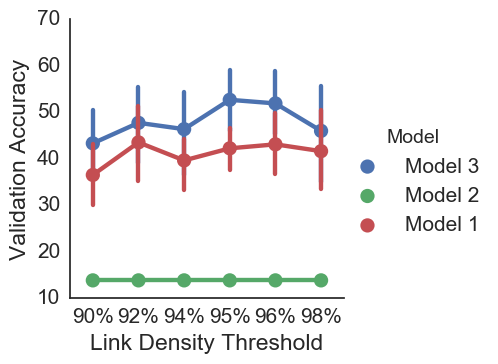

In [2212]:
plt.close()
sns.factorplot(x='Link Density Threshold',y='Validation Accuracy', 
               data= results_10i, hue='Model',
              order = ['90%', '92%', '94%', '95%', '96%', '98%'])
plt.show()

In [2596]:
code = {'10': '90%', '2': '98%', '4': '96%', '5': '95%', '6': '94%', '8': '92%'}
results_10i.columns = ['classic_val', 'Validation Accuracy', 'test', 'Feature Selection', 'Link Density Threshold']
[code[x] for x in results_10i['Link Density Threshold']]
results_10i['Link Density Threshold'] = [code[x] for x in results_10i['Link Density Threshold']]

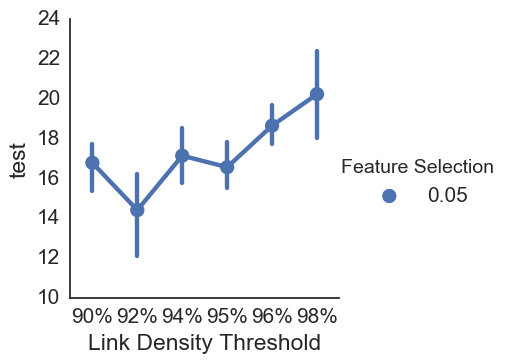

In [2599]:
plt.close()
sns.factorplot(x='Link Density Threshold',y='test', 
               data= results_10i, hue='Feature Selection',
              order = ['90%', '92%', '94%', '95%', '96%', '98%'])
plt.show()

In [1816]:
# AND NOW WITH SPLITTING INTO TRAIN VALIDATION AND TEST (HURTS THE N QUITE A BIT)
ld_sheetz = sorted(
        glob(
        '/Users/jakevogel/Science/bellec_lab/link_densities/ld*'
        ))
cnt=0
for tr_ix, te_ix in KFold(3, shuffle=True, random_state=123).split(gm2_train):
    if cnt==0:
        trix = tr_ix
        tex = te_ix
    cnt += 1
pcuts = [None, 0.05]
for sheet in ld_sheetz:
    for cut in pcuts:
        dens = sheet.split('_')[3]
        rsdf = pandas.read_csv(sheet, index_col=0).transpose()
        rsdf.index = ld_05[ld_05.columns[1]]
        nids = []
        for sid in rsdf.index:
            nids.append(idz.loc[int(sid[1:7])][idz.columns[0]])
        rsdf.index = nids
        nmmdf_full = pandas.concat([gm2_train[gm2_train.columns[:444]], 
                                     rsdf.loc[gm2_train.index]], axis=1)
        nmmdf_train = nmmdf_full.iloc[trix]
        nmmdf_test = nmmdf_full.iloc[tex]
        nmmdf_final = pandas.concat([gm2_test[gm2_test.columns[:444]], 
                                    rsdf.loc[gm2_test.index]], axis=1)
        ldy = ld_05.loc[nmmdf_train.index].tPSO
        ldt_y = ld_05.loc[nmmdf_test.index].tPSO
        final_y = ld_05.loc[nmmdf_final.index].tPSO
        p_cutoff = cut
        folds = 3
        #out_dir = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/rsfmri_lasso/kfold10_gm_0p001/'
        mout = kfl.kfold_feature_learning(nmmdf_train, nmmdf_test, ldy, ldt_y, folds = folds,
                                            p_cutoff = p_cutoff, output='light', scale=True)
        print(dens,'TRAINING/VALIDATION ===>',mout[0])
        
        master_scl = preprocessing.StandardScaler().fit(nmmdf_train)
        nmmdf_final = pandas.DataFrame(master_scl.transform(nmmdf_final),
                                 index=nmmdf_final.index,columns=nmmdf_final.columns)
        ntest = check_array(nmmdf_final,accept_sparse='csr')
        t_predicted = pandas.Series(safe_sparse_dot(ntest,np.array(mout[1]).T,dense_output=True
                                                   ),index=nmmdf_final.index)
        t_predicted += mout[-1]
        r,p = stats.pearsonr(final_y[nmmdf_final.index],t_predicted)
        t_res = (r**2)*100
        print('FINAL TEST ACCURACY FOR %s ===> %s percent \n p = %s \n r = %s'%(dens,t_res,p,r))
        

running model for fold 1 of 3
running model for fold 2 of 3
running model for fold 3 of 3
48 features selected
validation prediction accuracy is 42.3019376628 percent 
 p = 3.76144188955e-11 
 r = -0.650399397776
testing prediction accuracy2 is 77.0055882684 percent 
 p = 2.9451078177e-27 
 r = 0.877528280276
testing prediction accuracy is 4.01334935012 percent 
 p = 0.203348354882 
 r = 0.200333455771
10 TRAINING/VALIDATION ===> (77.005588268394646, 4.0133493501162842)
FINAL TEST ACCURACY FOR 10 ===> 0.0130190175499 percent 
 p = 0.926421089595 
 r = 0.0114100909505
running correlation for fold 1 of 3
running model for fold 1 of 3


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 2 of 3
running model for fold 2 of 3
running correlation for fold 3 of 3
running model for fold 3 of 3
34 features selected
validation prediction accuracy is 51.3085341663 percent 
 p = 3.86513892447e-14 
 r = -0.71629975685
testing prediction accuracy2 is 43.4832655284 percent 
 p = 1.62301553164e-11 
 r = 0.659418422008
testing prediction accuracy is 5.05170754413 percent 
 p = 0.152419666812 
 r = 0.22476003969
10 TRAINING/VALIDATION ===> (43.483265528401091, 5.0517075441299806)
FINAL TEST ACCURACY FOR 10 ===> 0.0167227108133 percent 
 p = 0.91664220548 
 r = 0.0129316320754
running model for fold 1 of 3
running model for fold 2 of 3
running model for fold 3 of 3
29 features selected
validation prediction accuracy is 67.3004082037 percent 
 p = 4.11324942884e-21 
 r = -0.820368260013
testing prediction accuracy2 is 28.0310644012 percent 
 p = 3.15014766711e-07 
 r = 0.529443711845
testing prediction accuracy is 0.457353577474 percent 
 p = 0.670442959771

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 2 of 3
running model for fold 2 of 3
running correlation for fold 3 of 3
running model for fold 3 of 3


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


38 features selected
validation prediction accuracy is 44.3571625951 percent 
 p = 8.62012836477e-12 
 r = -0.666011731091
testing prediction accuracy2 is 33.5966953112 percent 
 p = 1.15761002886e-08 
 r = 0.579626563498
testing prediction accuracy is 0.283299825326 percent 
 p = 0.737797917415 
 r = 0.05322591712
2 TRAINING/VALIDATION ===> (33.59669531121525, 0.28329982532627307)
FINAL TEST ACCURACY FOR 2 ===> 2.11660277616 percent 
 p = 0.236503168545 
 r = 0.145485489866
running model for fold 1 of 3
running model for fold 2 of 3
running model for fold 3 of 3
11 features selected
validation prediction accuracy is 76.1826830817 percent 
 p = 1.2083214622e-26 
 r = -0.872826919164
testing prediction accuracy2 is 12.7005783219 percent 
 p = 0.00101545248709 
 r = 0.356378707583
testing prediction accuracy is 11.6496463386 percent 
 p = 0.0269579819031 
 r = 0.341315782503
4 TRAINING/VALIDATION ===> (12.700578321853593, 11.649646338595979)
FINAL TEST ACCURACY FOR 4 ===> 3.00603586449 p

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 2 of 3
running model for fold 2 of 3
running correlation for fold 3 of 3
running model for fold 3 of 3


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


45 features selected
validation prediction accuracy is 45.5871422921 percent 
 p = 3.47989453687e-12 
 r = -0.675182510822
testing prediction accuracy2 is 46.5674087929 percent 
 p = 1.66480499556e-12 
 r = 0.682403171101
testing prediction accuracy is 0.699660210255 percent 
 p = 0.598435892445 
 r = 0.0836456938674
4 TRAINING/VALIDATION ===> (46.567408792931921, 0.69966021025520075)
FINAL TEST ACCURACY FOR 4 ===> 3.26926247563 percent 
 p = 0.140063449397 
 r = 0.180811019455
running model for fold 1 of 3
running model for fold 2 of 3
running model for fold 3 of 3
12 features selected
validation prediction accuracy is 77.1103763904 percent 
 p = 2.45170949459e-27 
 r = -0.878125141369
testing prediction accuracy2 is 11.0826797325 percent 
 p = 0.00224317314242 
 r = 0.332906589488
testing prediction accuracy is 8.7297733653 percent 
 p = 0.0574750630683 
 r = 0.295461898818
5 TRAINING/VALIDATION ===> (11.082679732452965, 8.7297733652990139)
FINAL TEST ACCURACY FOR 5 ===> 4.9434612977

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 2 of 3
running model for fold 2 of 3
running correlation for fold 3 of 3
running model for fold 3 of 3


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


38 features selected
validation prediction accuracy is 51.9698927697 percent 
 p = 2.22298686613e-14 
 r = -0.720901468786
testing prediction accuracy2 is 45.2705051261 percent 
 p = 4.40351800387e-12 
 r = 0.672833598493
testing prediction accuracy is 0.0574510009849 percent 
 p = 0.880235910232 
 r = 0.0239689384381
5 TRAINING/VALIDATION ===> (45.270505126149828, 0.057451000984896528)
FINAL TEST ACCURACY FOR 5 ===> 2.13895089167 percent 
 p = 0.234017625765 
 r = 0.146251526203
running model for fold 1 of 3
running model for fold 2 of 3
running model for fold 3 of 3
7 features selected
validation prediction accuracy is 76.9663343852 percent 
 p = 3.15383264908e-27 
 r = -0.877304590123
testing prediction accuracy2 is 14.3039532195 percent 
 p = 0.000459526250254 
 r = 0.378205674461
testing prediction accuracy is 14.7165408692 percent 
 p = 0.0121451852398 
 r = 0.383621439302
6 TRAINING/VALIDATION ===> (14.303953219476748, 14.716540869234931)
FINAL TEST ACCURACY FOR 6 ===> 5.5255339

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 2 of 3
running model for fold 2 of 3
running correlation for fold 3 of 3
running model for fold 3 of 3


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


35 features selected
validation prediction accuracy is 43.3646784315 percent 
 p = 1.76724641206e-11 
 r = -0.658518628678
testing prediction accuracy2 is 43.5582823822 percent 
 p = 1.53778049238e-11 
 r = 0.659986987615
testing prediction accuracy is 1.1463738292 percent 
 p = 0.499746284279 
 r = 0.107068848373
6 TRAINING/VALIDATION ===> (43.558282382151184, 1.1463738291985166)
FINAL TEST ACCURACY FOR 6 ===> 1.98306102018 percent 
 p = 0.252030734278 
 r = 0.140821199405
running model for fold 1 of 3
running model for fold 2 of 3
running model for fold 3 of 3
5 features selected
validation prediction accuracy is 77.6145660266 percent 
 p = 1.00270306555e-27 
 r = -0.880991294092
testing prediction accuracy2 is 16.2961832527 percent 
 p = 0.000169381001191 
 r = 0.403685313737
testing prediction accuracy is 17.0171899919 percent 
 p = 0.00663121322105 
 r = 0.412518969162
8 TRAINING/VALIDATION ===> (16.29618325266453, 17.017189991862413)
FINAL TEST ACCURACY FOR 8 ===> 4.27598879328 p

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 2 of 3
running model for fold 2 of 3
running correlation for fold 3 of 3
running model for fold 3 of 3
32 features selected
validation prediction accuracy is 45.6472517638 percent 
 p = 3.32730938151e-12 
 r = -0.675627499172
testing prediction accuracy2 is 46.2993829873 percent 
 p = 2.03927909158e-12 
 r = 0.680436499515
testing prediction accuracy is 2.8516132732 percent 
 p = 0.285043383806 
 r = 0.16886720443
8 TRAINING/VALIDATION ===> (46.299382987265638, 2.851613273195774)
FINAL TEST ACCURACY FOR 8 ===> 0.0528200218799 percent 
 p = 0.852420996059 
 r = 0.0229826068756


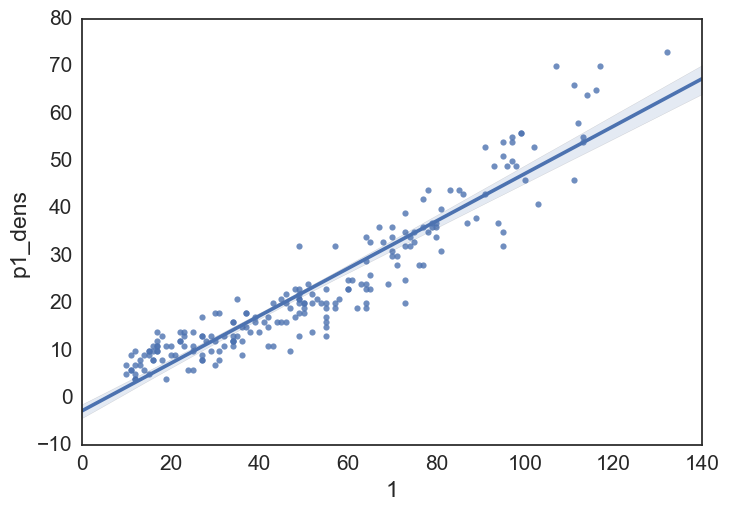

In [356]:
plt.close()
sns.regplot(tst[tst.columns[1]], ld_05.p1_dens)
plt.show()

In [381]:
### AND ONE MORE TIME, THIS TIME USING A MASK AND 443 NODES

In [382]:
ld_sheetz = sorted(
        glob(
        '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/tPSO_Manuscript/Prediction/Revisions/data/*443*'
        ))

In [383]:
ld_sheetz

['/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/tPSO_Manuscript/Prediction/Revisions/data/link_density443_10',
 '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/tPSO_Manuscript/Prediction/Revisions/data/link_density443_12.5',
 '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/tPSO_Manuscript/Prediction/Revisions/data/link_density443_15',
 '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/tPSO_Manuscript/Prediction/Revisions/data/link_density443_17.5',
 '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/tPSO_Manuscript/Prediction/Revisions/data/link_density443_2.5',
 '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/tPSO_Manuscript/Prediction/Revisions/data/link_density443_20',
 '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/tPSO_Manuscript/Prediction/Revisions/data/link_density443_5',
 '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/tPSO_Manuscript/Prediction/Revisions/data/link_density443_7.5']

In [386]:
nmmdf_test.shape

(68, 889)

In [406]:
for sheet in ld_sheetz:
    dens = sheet.split('_')[4]
    rsdf = pandas.read_csv(sheet, index_col=0)
    nids = []
    for sid in rsdf.index:
        nids.append(idz.loc[int(sid[1:7])][idz.columns[0]])
    rsdf.index = nids
    nmmdf_train = pandas.concat([gm2_train, rsdf.loc[gm_train.index]], axis=1)
    nmmdf_test = pandas.concat([gm2_test, rsdf.loc[gm_test.index]], axis=1)
    ldy = ld_05.loc[ld_train.index].tPSO
    ldt_y = ld_05.loc[ld_test.index].tPSO
    p_cutoff = 0.05
    folds = 3
    #out_dir = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/rsfmri_lasso/kfold10_gm_0p001/'
    output = kfl.kfold_feature_learning(nmmdf_train, nmmdf_test, ldy, ldt_y, folds = folds,
                                        p_cutoff = p_cutoff, output='light', scale=True)
    print(dens,'===>',output[0])




IndexError: invalid index to scalar variable.

In [ ]:
# try it with Fisher's Z transformed nodes??

In [1787]:
ld_sheet = '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/tPSO_Manuscript/Prediction/Revisions/data/zlink_density443_2'
ld_z = pandas.read_csv(ld_sheet, index_col=0)


## BEST MODEL (in terms of validation accuracy) is LD 2%

In [23]:
ld_sheetz = sorted(
        glob(
        '/Users/jakevogel/Science/bellec_lab/link_densities/ld*'
        ))

In [26]:
sheet = ld_sheetz[1]
dens = sheet.split('_')[3]
rsdf = pandas.read_csv(sheet, index_col=0).transpose()
rsdf.index = ld_05[ld_05.columns[1]]
nids = []
for sid in rsdf.index:
    nids.append(idz.loc[int(sid[1:7])][idz.columns[0]])
rsdf.index = nids
rsdf.columns = ['col_%s'%x for x in rsdf.columns]
nmm_train = pandas.concat([gm2_train[gm2_train.columns[:444]], 
                                 rsdf.loc[gm2_train.index]], axis=1)
nmm_test = pandas.concat([gm2_test[gm2_test.columns[:444]], 
                                rsdf.loc[gm2_test.index]], axis=1)
nmmx_train = pandas.concat([gm2_train, 
                                 rsdf.loc[gm2_train.index]], axis=1)
nmmx_test = pandas.concat([gm2_test, 
                                rsdf.loc[gm2_test.index]], axis=1)

In [27]:
ldy = ld_05.loc[ld_train.index].tPSO
ldt_y = ld_05.loc[ld_test.index].tPSO
p_cutoff = 0.05
folds = 3
ci = 0.05
ni_output = kfl.kfold_feature_learning(nmm_train, nmm_test, ldy, ldt_y, folds = folds,
                                    p_cutoff = p_cutoff, ci=ci, output='light', scale=True)

running correlation for fold 1 of 3
running model for fold 1 of 3


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 2 of 3
running model for fold 2 of 3


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 3 of 3
running model for fold 3 of 3
61 features selected
testing prediction accuracy is 28.0315682968 percent (0.203492004624, 0.37736744692, mean=0.285449536) 
 p = 2.44606255138e-11 
 r = -0.52944847055
testing prediction accuracy2 is 42.6198523044 percent 
 p = 4.08525779228e-18 
 r = 0.652838818579
testing prediction accuracy is 18.1011217629 percent (0.0656398726329, 0.345699431791, mean=0.191673127193) 
 p = 0.00029824216972 
 r = 0.425454131052


In [28]:
agend = nmmx_train[nmmx_train.columns[444:446]]
for i in range(2):
    nmmx_train.drop(nmmx_train.columns[444],axis=1,inplace=True)
nmmx_train.loc[:,'Age'] = agend[agend.columns[0]].values
nmmx_train.loc[:,'Gender'] = agend[agend.columns[1]].values


agend = nmmx_test[nmmx_test.columns[444:446]]
for i in range(2):
    nmmx_test.drop(nmmx_test.columns[444],axis=1,inplace=True)
nmmx_test.loc[:,'Age'] = agend[agend.columns[0]].values
nmmx_test.loc[:,'Gender'] = agend[agend.columns[1]].values

In [29]:
ldy = ld_05.loc[ld_train.index].tPSO
ldt_y = ld_05.loc[ld_test.index].tPSO
p_cutoff = 0.05
folds = 3
ci = 0.05
nix_output = kfl.kfold_feature_learning(nmmx_train, nmmx_test, ldy, ldt_y, folds = folds,
                                    p_cutoff = p_cutoff, ci=ci, output='light', scale=True)

running correlation for fold 1 of 3
running model for fold 1 of 3


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 2 of 3
running model for fold 2 of 3


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 3 of 3
running model for fold 3 of 3
58 features selected
testing prediction accuracy is 25.9871336781 percent (0.183237333638, 0.357987903363, mean=0.269763115754) 
 p = 1.70347730252e-10 
 r = -0.509775771081
testing prediction accuracy2 is 44.9017513433 percent 
 p = 2.52249291413e-19 
 r = 0.670087690853
testing prediction accuracy is 20.2586295213 percent (0.0770070247557, 0.354251478903, mean=0.207878625783) 
 p = 0.000117613839112 
 r = 0.450095873357


In [54]:

reload(kfl)

<module 'kfold_learning' from '/Users/jakevogel/git/hack_projects/kfold_learning.py'>

In [55]:
nixtiv_train = pandas.DataFrame(nmmx_train,copy=True)
nixtiv_train.loc[:,'TIV'] = super_train.loc[nixtiv_train.index].TIV.values
for col in ['Age', 'Gender']:
    nixtiv_train.drop(col,axis=1,inplace=True)
nixtiv_test = pandas.DataFrame(nmmx_test,copy=True)
nixtiv_test.loc[:,'TIV'] = super_test.loc[nixtiv_test.index].TIV.values
for col in ['Age', 'Gender']:
    nixtiv_test.drop(col,axis=1,inplace=True)
nixtiv_train.dropna(axis=0,inplace=True)
nixtiv_test.dropna(axis=0,inplace=True)


ldy = ld_05.loc[ld_train.index].tPSO
ldt_y = ld_05.loc[ld_test.index].tPSO
p_cutoff = 0.05
folds = 3
ci = 0.05
nixtiv_output = kfl.kfold_feature_learning(nixtiv_train, nixtiv_test, ldy, ldt_y, folds = folds,
                                    p_cutoff = p_cutoff, ci=ci, output='light', scale=True)

running correlation for fold 1 of 3
running model for fold 1 of 3


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 2 of 3
running model for fold 2 of 3


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 3 of 3
running model for fold 3 of 3
64 features selected
validation prediction accuracy is 25.6607623463 percent (0.181013920241, 0.355587612782, mean=0.262398258303) 
 p = 2.6903410572e-10 
 r = -0.506564530404
testing prediction accuracy2 is 44.1939475799 percent 
 p = 8.1350343026e-19 
 r = 0.664785285486
testing prediction accuracy is 22.1198023832 percent (0.0730134029571, 0.390787497211, mean=0.221847851477) 
 p = 5.92026466573e-05 
 r = 0.470316939768


## Recreate the figures

## Now let's iteratively test models using Demographics, ApoE, MoCA and Cognition

In [31]:
super_train = pandas.DataFrame(nmm_train, copy=True)
super_test = pandas.DataFrame(nmm_test, copy = True)

In [36]:
dfs = [super_train, super_test]
for df in dfs:
    df.loc[:,'Age'] =  ld_05.loc[df.index, 'Age']
    df.loc[:,'Gender'] =  ld_05.loc[df.index, 'Gender']
    df.loc[:,'Education'] = pad.loc[df.index,'@4_education']
    df.loc[:,'TIV'] = pad.loc[df.index,'tiv']
    df.loc[:,'FD'] = pad.loc[df.index,'fd_mean']
    df.loc[:,'ApoE4'] =  ld_05.loc[df.index, 'ApoE4_status']
    df.loc[:, 'MoCA'] = pad.loc[df.index, 'total_s']
    for col in cog_cols:
        df.loc[:,col] =  pad.loc[df.index, col]
    df.loc[:, 'lhipp'] = pad.loc[df.index, 'LeftHippocampus']
    df.loc[:, 'rhipp'] = pad.loc[df.index, 'RightHippocampus']

## Fill in the missing data

In [37]:
#super_train.dropna(inplace=True)
#super_test.dropna(inplace=True)
mdat = pandas.ExcelFile('/Users/jakevogel/Downloads/data_request_HO_Updated.xlsx')
edat = mdat.parse('Education & MoCA total')
cdat = mdat.parse('Cognitive Composites')
hdat = mdat.parse('Hippocampal Volume')
sdat = mdat.parse('SCD')

In [38]:
super_df = pandas.concat([super_train, super_test])
#super_df

In [39]:
# Education & MoCA
super_df.loc[edat.ID,'MoCA'] = edat.MOCA.values
super_df.loc[edat.ID,'Education'] = edat.Education.values
super_df.loc[edat.ID,['MoCA','Education']]


MoCA  Education
MTL0317  29.0       20.0
MTL0397  27.0       12.0
MTL0414  30.0       13.0
MTL0401  27.0       15.0

In [40]:
# cognition
for x,y in zip(cdat.columns[1:], cog_cols):
    super_df.loc[cdat.ID, y] = cdat[x].values
super_df.loc[cdat.ID, cog_cols]

immediate_memory_index_score  \
MTL0449                          87.0   
MTL0317                         114.0   
MTL0407                         106.0   
MTL0405                         106.0   
MTL0381                          90.0   
MTL0384                         103.0   
MTL0397                         109.0   
MTL0423                         106.0   
MTL0436                         109.0   
MTL0443                         114.0   
MTL0442                         106.0   
MTL0427                          97.0   
MTL0414                         103.0   
MTL0448                         109.0   
MTL0447                         109.0   
MTL0223                          90.0   
MTL0450                         117.0   
MTL0401                         109.0   

         visuospatial_constructional_index_score   lang  \
MTL0449                                    100.0  102.0   
MTL0317                                     89.0  116.0   
MTL0407                                     81.0   96.0   
MTL0405                                     78.0   96.0   
MTL0381                                    112.0  102.0   
MTL0384                                    105.0   96.0   
MTL0397                                    116.0   96.0   
MTL0423                                     69.0  101.0   
MTL0436                                    105.0  105.0   
MTL0443                                     87.0  116.0   
MTL0442                                    105.0  116.0   
MTL0427                                    105.0   94.0   
MTL0414                                    102.0   99.0   
MTL0448                                    112.0  120.0   
MTL0447                                     89.0  120.0   
MTL0223                                     72.0  104.0   
MTL0450                                    112.0   83.0   
MTL0401                                    109.0  102.0   

         attention_index_score  delayed_memory_index_score  
MTL0449                   82.0                       105.0  
MTL0317                  118.0                       121.0  
MTL0407                   94.0                        78.0  
MTL0405                  103.0                       112.0  
MTL0381                  112.0                        99.0  
MTL0384                  103.0                        98.0  
MTL0397                  100.0                       102.0  
MTL0423                  100.0                        95.0  
MTL0436                   91.0                       105.0  
MTL0443                  106.0                       106.0  
MTL0442                  132.0                       106.0  
MTL0427                  100.0                        99.0  
MTL0414                  109.0                        91.0  
MTL0448                  106.0                       106.0  
MTL0447                  112.0                       108.0  
MTL0223                   94.0                        98.0  
MTL0450                  112.0                       107.0  
MTL0401                  100.0                        97.0

In [41]:
# Hipp vol
super_df.loc[hdat.ID,'lhipp'] = hdat.hippocampus_left.values
super_df.loc[hdat.ID,'rhipp'] = hdat.hippocampus_right.values
super_df.loc[hdat.ID,['lhipp','rhipp']]

lhipp        rhipp
MTL0008  2834.725575  2912.140850
MTL0449  3419.108830  3451.691580
MTL0381  3323.179502  3659.540765
MTL0436  3194.340273  3195.884192
MTL0443  2476.414667  2729.187269
MTL0427  3186.866649  3469.719313
MTL0448  2781.550723  2864.087293
MTL0347  2151.526976  2452.944691
MTL0447  3005.068309  3074.055440
MTL0223  2843.717047  2930.316228
MTL0450     2.868722     2.732714

In [42]:
super_train = super_df.loc[super_train.index]
super_test = super_df.loc[super_test.index]

In [43]:
super_test.drop('MTL0450', inplace=True)

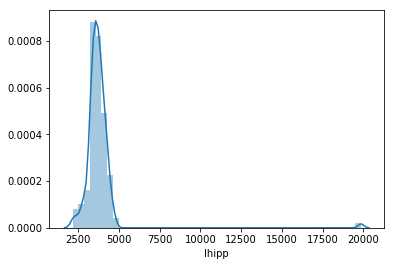

In [44]:
plt.close()
sns.distplot(super_train.lhipp)
plt.show()

In [45]:
[x for x in super_train.index if super_train.loc[x,'lhipp'] >10000 ]

['MTL0057']

In [46]:
super_train.drop('MTL0057', inplace=True)

In [47]:
ldy = ld_05.loc[super_train.index].tPSO
ldt_y = ld_05.loc[super_test.index].tPSO
p_cutoff = 0.05
folds = 3
output = kfl.kfold_feature_learning(super_train, super_test, ldy, ldt_y, folds = folds,
                                    p_cutoff = p_cutoff, output='light', scale=True)

running correlation for fold 1 of 3
running model for fold 1 of 3


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 2 of 3
running model for fold 2 of 3


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 3 of 3
running model for fold 3 of 3
66 features selected
validation prediction accuracy is 23.4347272113 percent 
 p = 2.05767985925e-09 
 r = -0.48409428019
testing prediction accuracy2 is 46.4713197492 percent 
 p = 4.76857612791e-20 
 r = 0.681698758612
testing prediction accuracy is 25.047520214 percent 
 p = 1.61187350135e-05 
 r = 0.500474976537


In [1299]:
super_train.columns[-14:]

Index(['Age', 'Gender', 'Education', 'TIV', 'FD', 'ApoE4', 'MoCA',
       'immediate_memory_index_score',
       'visuospatial_constructional_index_score', 'lang',
       'attention_index_score', 'delayed_memory_index_score', 'lhipp',
       'rhipp'],
      dtype='object')

In [1995]:
reload(kfl)

<module 'kfold_learning' from '/Users/jakevogel/git/hack_projects/kfold_learning.py'>

In [48]:
ldy = ld_05.loc[super_train.index].tPSO
ldt_y = ld_05.loc[super_test.index].tPSO
p_cutoff = 0.05
folds = 3
ci = 0.05
output = kfl.kfold_feature_learning(super_train, super_test, ldy, ldt_y, folds = folds,
                                    p_cutoff = p_cutoff, ci = ci, output='heavy', scale=True, 
                                    keep_cols = super_train.columns[-14:])

running correlation for fold 1 of 3
running model for fold 1 of 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 2 of 3
running model for fold 2 of 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 3 of 3
running model for fold 3 of 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


69 features selected
testing prediction accuracy is 25.3792388301 percent (0.187683620092, 0.331233978538, mean=0.258422081449) 
 p = 3.49047372435e-10 
 r = -0.503778114154
testing prediction accuracy2 is 50.425236841 percent 
 p = 2.58033022303e-22 
 r = 0.710107293591
testing prediction accuracy is 29.1902614107 percent (0.127190903424, 0.439065546868, mean=0.287594150655) 
 p = 2.36961738698e-06 
 r = 0.540280125589


In [1998]:
linear_model.Lasso?

In [2026]:
np.mean([x.alpha_ for x in output[-1]])

0.43498696594830544

In [2024]:
#from sklearn import model_selection
kfold = model_selection.KFold(n_splits=10, random_state=123)
blasamp = super_train.loc[np.random.permutation(super_train.index)]
cv_results = model_selection.cross_val_score(linear_model.LassoCV(cv=10, normalize=True), 
                                             blasamp, ldy.loc[blasamp.index], 
                                             cv=10, scoring='r2')
msg = "%s: %f (%f)" % ('lasso', cv_results.mean(), cv_results.std())
print(msg)
cv_results

lasso: -0.146913 (0.187581)


array([-0.01005173, -0.14512118, -0.27240096, -0.0541974 ,  0.02044158,
       -0.17650808, -0.58378692, -0.30841806,  0.02594215,  0.03497364])

In [2027]:
clf = linear_model.Lasso(alpha=.43498696594830544)
jnkmod = clf.fit(super_train,ldy)
jnkmod.score(super_test,ldt_y)

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


-0.48911439397212297

In [2019]:
msg = "%s: %f (%f)" % ('lasso', cv_results.mean(), cv_results.std())
msg

'lasso: -56.743002 (69.774015)'

In [2213]:
ldy = ld_05.loc[super_train.index].tPSO
ldt_y = ld_05.loc[super_test.index].tPSO
p_cutoff = 0.05
folds = 3
ci = 0.05
output = kfl.kfold_feature_learning(super_train, super_test, ldy, ldt_y, folds = folds,
                                    p_cutoff = p_cutoff, ci = ci, output='light', scale=True, 
                                    keep_cols = super_train.columns[-14:])

running correlation for fold 1 of 3
running model for fold 1 of 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 2 of 3
running model for fold 2 of 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


running correlation for fold 3 of 3
running model for fold 3 of 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


69 features selected
validation prediction accuracy is 25.3792388301 percent 
 p = 3.49047372435e-10 
 r = -0.503778114154
testing prediction accuracy2 is 50.425236841 percent 
 p = 2.58033022303e-22 
 r = 0.710107293591
testing prediction accuracy is 29.1902614107 percent (0.132943542577, 0.456689732319, mean=0.290066487388) 
 p = 2.36961738698e-06 
 r = 0.540280125589


In [1852]:
nmm_weights = output[1]
nind = []
for i in nmm_weights[:887].index:
    if i < 444:
        nind.append('GMV_%s'%(i+1))
    else:
        nind.append('fMRI_%s'%(i-443))
nind += super_train.columns[887:].tolist()
annot_weights = deepcopy(nmm_weights)
annot_weights.index = nind
annot_weights.index = annot_weights.index[:-14].tolist() + bettercols
annot_weights

GMV_1                  0.000000
GMV_2                  0.000000
GMV_3                  0.000000
GMV_4                  0.000000
GMV_5                  0.000000
GMV_6                  0.000000
GMV_7                  0.000000
GMV_8                  0.000000
GMV_9                  0.000000
GMV_10                 0.000000
GMV_11                 0.000000
GMV_12                 0.000000
GMV_13                 0.000000
GMV_14                 0.000000
GMV_15                 0.000000
GMV_16                 0.000000
GMV_17                 0.000000
GMV_18                 0.000000
GMV_19                -0.239620
GMV_20                 0.000000
GMV_21                 0.000000
GMV_22                 0.000000
GMV_23                 0.000000
GMV_24                 0.000000
GMV_25                 0.000000
GMV_26                 0.000000
GMV_27                 0.000000
GMV_28                 0.000000
GMV_29                 0.000000
GMV_30                 0.000000
                         ...   
fMRI_428

In [1853]:
nmm_weights_abs = pandas.Series(abs(annot_weights.values))
nmm_weights_abs.index = annot_weights.index
nmm_weights_abs.sort_values(ascending=False)
[(i,j) for i,j in nmm_weights_abs.sort_values(ascending=False).items() if j > 0]
#list(zip(kmm_weights.sort_values()

[('Intracranial Volume', 0.73160289935453948),
 ('fMRI_436', 0.59146296767556128),
 ('Age', 0.56159277759948889),
 ('ApoE4', 0.54814242868490537),
 ('fMRI_248', 0.51212448998260796),
 ('fMRI_225', 0.50781827053921791),
 ('fMRI_283', 0.48087084340324798),
 ('GMV_243', 0.44927627829410283),
 ('GMV_143', 0.43873177765833266),
 ('fMRI_95', 0.4344031118613591),
 ('fMRI_86', 0.33634587455614984),
 ('fMRI_352', 0.33566190758598413),
 ('fMRI_405', 0.32971615684933492),
 ('GMV_97', 0.32767844774346283),
 ('fMRI_250', 0.32189602990641603),
 ('fMRI_395', 0.30254549263931635),
 ('GMV_331', 0.30118090973629502),
 ('fMRI_139', 0.29969417276524918),
 ('fMRI_377', 0.29552404876085608),
 ('fMRI_212', 0.24644073338844508),
 ('GMV_19', 0.23962033672169328),
 ('GMV_322', 0.23464160505882739),
 ('fMRI_412', 0.21203884686044158),
 ('Education', 0.20415328951601511),
 ('fMRI_69', 0.18491317699404744),
 ('fMRI_145', 0.18263216808222535),
 ('GMV_391', 0.17522211011438515),
 ('fMRI_65', 0.17057305042966556),
 (

In [1854]:
jnk = pandas.DataFrame(annot_weights,columns=['weights']) 
jnk = jnk.loc[nmm_weights_abs.sort_values(ascending=False).index]

In [1855]:
for reg in jnk.index:
    if 'GMV' in reg:
        jnk.ix[reg,'modality'] = 'MRI Volume'
    elif 'fMRI' in reg:
        jnk.ix[reg,'modality'] = 'rsfMRI Connectivity'
    elif reg in ['Age', 'Sex', 'Education', 'ApoE4' ]:
        jnk.ix[reg,'modality'] = 'Demographics'
    elif reg in ['MoCA', 'Immediate Memory', 'Visuospatial', 
                 'Language', 'Attention', 'Delayed Memory']:
        jnk.ix[reg,'modality'] = 'Cognition'
    elif 'Hippocampus' in reg or reg in ['Intracranial Volume', 'Frame Displacement']:
        jnk.ix[reg,'modality'] = 'Other MRI'

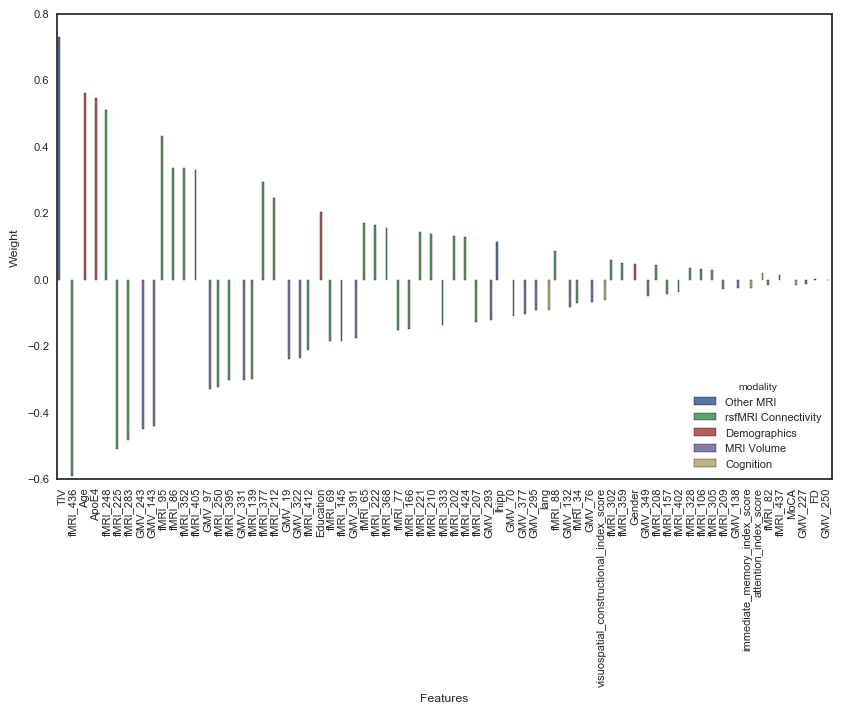

In [1305]:
plt.close()
fig,ax = plt.subplots(figsize=(10,6))
fig = sns.barplot(x = jnk[abs(jnk.weights)>0].index,
            y='weights',
            data=jnk[abs(jnk.weights)>0],
            hue='modality')
for item in fig.get_xticklabels():
    item.set_rotation(90)
sns.plt.xlabel('Features')
sns.plt.ylabel('Weight')
fig = fig.get_figure() 
#fig.savefig(
#        '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/weight_values.pdf',
#        bbox_inches='tight')
plt.show()

//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


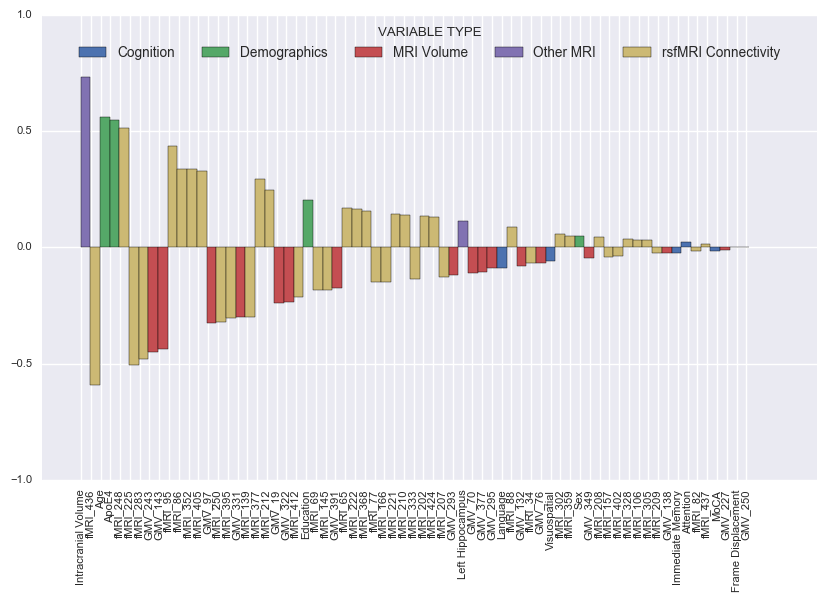

In [1465]:
plt.close()

sns.set()
sns.set(font_scale=0.8)
#sns.set_style('ticks')
#sns.set_style('white')

data=jnk[abs(jnk.weights)>0]
df_m = data
df_m['index'] = jnk[abs(jnk.weights)>0].index
df_m.reset_index(drop=True,inplace=True)

uelec, uind = np.unique(df_m["modality"], return_inverse=1)
cmap = plt.cm.get_cmap("Set1")
palette = sns.color_palette()
colors= [ palette[i] for i in uind]

fig, ax=plt.subplots(figsize=(10,6))
l = len(df_m)
#pos = np.arange(0,l) % (l) + (np.arange(0,l)//(l)-1)*0.5
#pos = np.arange(0,l) % (l)
#pos = np.arange(0,l) + (np.arange(0,l))*0.5
pos = (np.arange(0,l) * 2.5) + 10
ax.bar(pos, df_m["weights"], width=2.5, align="edge", ec="k", color=colors  )

handles=[plt.Rectangle((0,0),1,1, color=palette[i], ec="k") for i in range(len(uelec))]
ax.legend(handles=handles, labels=list(uelec),
           prop ={'size':9.8}, loc=9, ncol=8, 
            title=r'VARIABLE TYPE')

#ax.set_xticks(range(l))
ax.set_xticks(pos*1.01)
ax.set_xticklabels(df_m['index'][:l])
ax.set_ylim(-1, 1)
for item in ax.get_xticklabels():
    item.set_rotation(90)
plt.show()

In [1857]:
jnk['abs_weight'] = abs(jnk.weights)

In [1856]:
pt = pandas.pivot_table(jnk, values = 'abs_weight', index='modality', aggfunc=np.sum)

In [1309]:
pt = pt / jnk.abs_weight.sum()

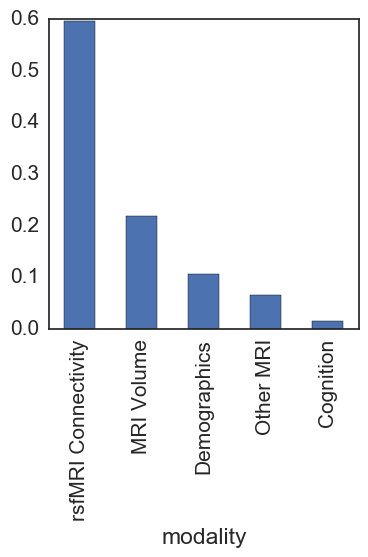

In [1320]:
plt.close()
sns.set(font_scale=1.5)
sns.set_style('white')
fig, ax = plt.subplots(figsize=(4,4))
pt.sort_values(ascending=False).plot.bar()
plt.show()

In [1858]:
jnk.loc['Left Hippocampus', 'weights'] / jnk.abs_weight.sum()

0.0088613983469786241

In [2028]:
reload(kfl)

<module 'kfold_learning' from '/Users/jakevogel/git/hack_projects/kfold_learning.py'>

In [2029]:
## HERE IS A MODEL WITH ONLY DEMOGRAPHICS ETC
ldy = ld_05.loc[super_train.index].tPSO
ldt_y = ld_05.loc[super_test.index].tPSO
p_cutoff = 0.05
folds = 3
ci = 0.05
demo_output = kfl.kfold_feature_learning(super_train[super_train.columns[-14:]], 
                                    super_test[super_test.columns[-14:]], 
                                    ldy, ldt_y, folds = folds, ci=ci,
                                    p_cutoff = p_cutoff, output='ci', scale=True, 
                                    keep_cols = super_train.columns[-14:])

running correlation for fold 1 of 3
running model for fold 1 of 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


running correlation for fold 2 of 3
running model for fold 2 of 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


running correlation for fold 3 of 3
11 features selected
testing prediction accuracy2 is 14.5879400749 percent 
 p = 4.11712401738e-06 
 r = 0.381941619556
testing prediction accuracy is 9.26710065988 percent (0.0177991845722, 0.204771929324, mean=0.0987984790192) 
 p = 0.0122576313369 
 r = 0.304419129817


In [1962]:
y_r

[-9.344999999999999, -14.78, -15.614999999999998]

In [1963]:
((9.27 - 20.58) + (1.89 - 9.27))/2

-9.344999999999999

In [2046]:
(29.19 - 14.24) + 29.19

44.14

In [2112]:
plt.legend?

In [2810]:
(22.12 - 7.78) + 22.12

36.46

In [ ]:
0.0778139529334, 0.383484631509

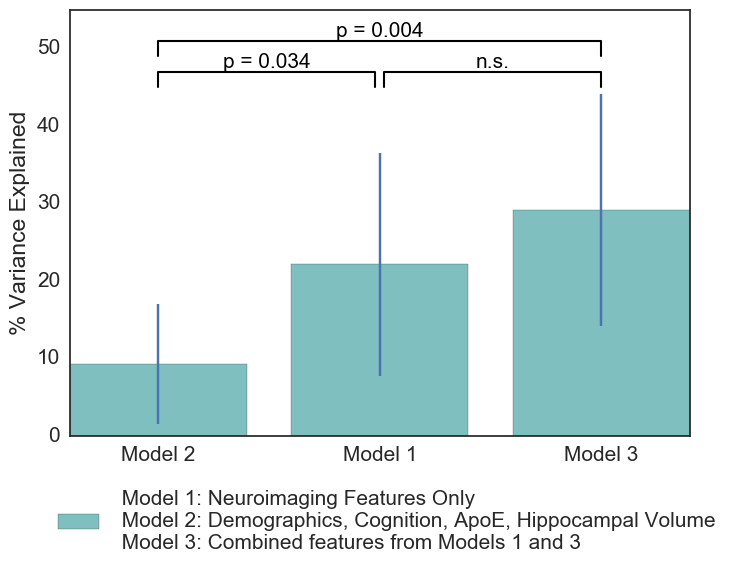

In [2838]:
means = [9.27, 22.12, 29.19]

# true confidence intervals you provided
#cis = [(1.89, 20.58), (5.59, 35.15), (14.24, 45.47)]

# confidence intervals needed to make the plot accurately reflect the actual data
cis = [(1.89, 17.34), (7.78, 36.46), (14.24, 44.14)]

# get the range of the confidence interval
#y_r = [means[i] - cis[i][1] for i in range(len(cis))]
#y_r = [cis[i][0] - means[i] for i in range(len(cis))]
y_r = [((cis[i][0] - means[i]) + (means[i] - cis[i][1]))/2 for i in range(len(cis))]

new_labels = ' Model 1: Neuroimaging Features Only \n Model 2: Demographics, Cognition, ApoE, Hippocampal Volume \n Model 3: Combined features from Models 1 and 3'

plt.close()
sns.set_style('white')
fig, ax = plt.subplots()
fig = plt.bar(range(len(means)), means, yerr=y_r, alpha=0.5, align='center', color = 'teal',
             label = new_labels)
plt.xticks(range(len(means)), ['Model 2','Model 1','Model 3'])

plt.ylim(0,55)
plt.ylabel('% Variance Explained')
plt.plot([0, 0, 0.98, 0.98], [45, 47, 47, 45], lw=1.5, c='k')
plt.text((0+0.98)*.5, 47, "p = 0.034", ha='center', va='bottom', color='k', fontsize='small')
plt.plot([0, 0, 2, 2], [49, 51, 51, 49], lw=1.5, c='k')
plt.text((0+2)*.5, 51, "p = 0.004", ha='center', va='bottom', color='k', fontsize='small')
plt.plot([1.02, 1.02, 2, 2], [45, 47, 47, 45], lw=1.5, c='k')
plt.text((1.02+2)*.5, 47, "n.s.", ha='center', va='bottom', color='k', fontsize='small')

plt.legend(loc='center left', fontsize = 'small', bbox_to_anchor = (-0.05, -0.2))

#fig.savefig('/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/tPSO_Manuscript/Prediction/Revisions/manuscript/')
plt.show()

In [2142]:
adni_output[:-1]

(0.29354014949736124, 0.4501719101913057, 0.13216059153613433)

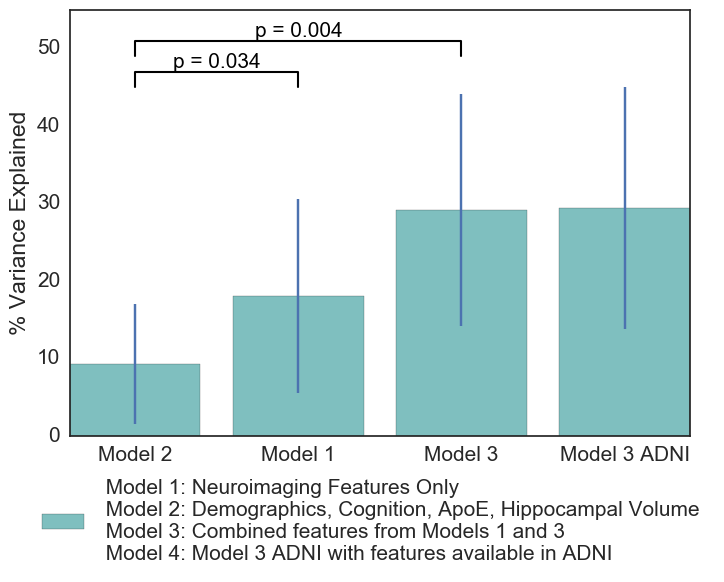

In [2830]:
# NOW WITH ADNI MODEL INCLUDED

means = [9.27, 18.10, 29.19, 29.44]

# confidence intervals needed to make the plot accurately reflect the actual data
cis = [(1.89, 17.34), (5.59, 30.61), (14.24, 44.14), (13.86, 45.02)]

# get the range of the confidence interval
#y_r = [means[i] - cis[i][1] for i in range(len(cis))]
#y_r = [cis[i][0] - means[i] for i in range(len(cis))]
y_r = [((cis[i][0] - means[i]) + (means[i] - cis[i][1]))/2 for i in range(len(cis))]

new_labels = ' Model 1: Neuroimaging Features Only \n Model 2: Demographics, Cognition, ApoE, Hippocampal Volume \n Model 3: Combined features from Models 1 and 3 \n Model 4: Model 3 ADNI with features available in ADNI'

plt.close()
fig, ax = plt.subplots()
fig = plt.bar(range(len(means)), means, yerr=y_r, alpha=0.5, align='center', color = 'teal',
             label = new_labels)
plt.xticks(range(len(means)), ['Model 2','Model 1','Model 3', 'Model 3 ADNI'])

plt.ylim(0,55)
plt.ylabel('% Variance Explained')
plt.plot([0, 0, 1, 1], [45, 47, 47, 45], lw=1.5, c='k')
plt.text((0+1)*.5, 47, "p = 0.034", ha='center', va='bottom', color='k', fontsize = 'small')
plt.plot([0, 0, 2, 2], [49, 51, 51, 49], lw=1.5, c='k')
plt.text((0+2)*.5, 51, "p = 0.004", ha='center', va='bottom', color='k', fontsize='small')

plt.legend(loc='center left', fontsize = 'small', bbox_to_anchor = (-0.075, -0.2))

#fig.savefig('/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/tPSO_Manuscript/Prediction/Revisions/manuscript/')
plt.show()

In [2827]:
# COMPARING MODEL 1 TO MODELS 2 AND 3 USING BOOTSTRAP TEST

jnk=np.array(demo_output[-1])
m1p = len(jnk[jnk>(22.12/100)])/1001
print('Model 1 compared to Model 2: p = ',m1p)

m2p = len(jnk[jnk>(29.19/100)])/1001
print('Model 1 compared to Model 3: p = ',m2p)

jnk=np.array(nixtiv_output[-1])
m2p2 = len(jnk[jnk>(29.19/100)])/1001
print('Model 2 compared to Model 3: p = ',m2p2)

Model 1 compared to Model 2: p =  0.03396603396603397
Model 1 compared to Model 3: p =  0.003996003996003996
Model 2 compared to Model 3: p =  0.23876123876123875


In [2035]:
sorted(demo_output[-1])

[4.5163967198925199e-05,
 0.00028351549488912558,
 0.00032907858438467299,
 0.00061925008403128758,
 0.00063438999707527604,
 0.0024423412353802099,
 0.0027402446124585073,
 0.0033960459088182688,
 0.0034574090413524898,
 0.0038624345621975464,
 0.0046651031610287991,
 0.004771032606748834,
 0.0050392250762939725,
 0.0052910485446304384,
 0.0053219349849979994,
 0.00553510738353116,
 0.0057994434198194523,
 0.0068826108926567306,
 0.0075305241888947907,
 0.0076394624254149763,
 0.0079925320183490377,
 0.008251786479093616,
 0.0084249969014806754,
 0.0099756877838020168,
 0.010400665474144014,
 0.010582088161022005,
 0.010771597815190926,
 0.010966418653146062,
 0.011148300247083342,
 0.011734834266272103,
 0.01252284495835122,
 0.012589443347012928,
 0.01276311027932716,
 0.013571964783600622,
 0.013670006205516345,
 0.013929345415745562,
 0.014008824439748891,
 0.01461966794058275,
 0.014951537815995439,
 0.015088425248719952,
 0.015431070669355531,
 0.016103179314449718,
 0.016296773

In [1322]:
list(zip(super_train.columns[-14:],demo_output[1]))

[('Age', 1.4735292635670199),
 ('Gender', -0.13927853191770717),
 ('Education', 0.1020754215723103),
 ('TIV', 0.0),
 ('FD', 0.0),
 ('ApoE4', 0.89309476551179667),
 ('MoCA', 0.0),
 ('immediate_memory_index_score', -0.56171263119085324),
 ('visuospatial_constructional_index_score', 0.1933370215385509),
 ('lang', -0.048169967884016611),
 ('attention_index_score', -0.068087333836179889),
 ('delayed_memory_index_score', 0.20132600169344941),
 ('lhipp', 0.49983506272539491),
 ('rhipp', -0.82624306183491392)]

In [1408]:
bettercols = ['Age', 'Sex', 'Education', 'Intracranial Volume', 'Frame Displacement',
              'ApoE4', 'MoCA' , 'Immediate Memory', 'Visuospatial', 'Language', 
              'Attention', 'Delayed Memory', 'Left Hippocampus', 'Right Hippocampus']


In [1409]:
annot_weights = demo_output[1]
nmm_weights_abs = pandas.Series(abs(annot_weights.values))
nmm_weights_abs.index = bettercols
nmm_weights_abs.sort_values(ascending=False)
[(i,j) for i,j in nmm_weights_abs.sort_values(ascending=False).items() if j > 0]
#list(zip(kmm_weights.sort_values()

[('Age', 1.4735292635670199),
 ('ApoE4', 0.89309476551179667),
 ('Right Hippocampus', 0.82624306183491392),
 ('Immediate Memory', 0.56171263119085324),
 ('Left Hippocampus', 0.49983506272539491),
 ('Delayed Memory', 0.20132600169344941),
 ('Visuospatial', 0.1933370215385509),
 ('Sex', 0.13927853191770717),
 ('Education', 0.1020754215723103),
 ('Attention', 0.068087333836179889),
 ('Language', 0.048169967884016611)]

In [1412]:
jnk = pandas.DataFrame(annot_weights,columns=['weights'])
jnk.index = nmm_weights_abs.index
jnk = jnk.loc[nmm_weights_abs.sort_values(ascending=False).index]

In [1413]:
for reg in jnk.index:
    if 'GMV' in reg:
        jnk.ix[reg,'modality'] = 'MRI Volume'
    elif 'fMRI' in reg:
        jnk.ix[reg,'modality'] = 'rsfMRI Connectivity'
    elif reg in ['Age', 'Sex', 'Education', 'ApoE4' ]:
        jnk.ix[reg,'modality'] = 'Demographics'
    elif reg in ['MoCA', 'Immediate Memory', 'Visuospatial', 
                 'Language', 'Attention']:
        jnk.ix[reg,'modality'] = 'Cognition'
    else:
        jnk.ix[reg,'modality'] = 'Other MRI'

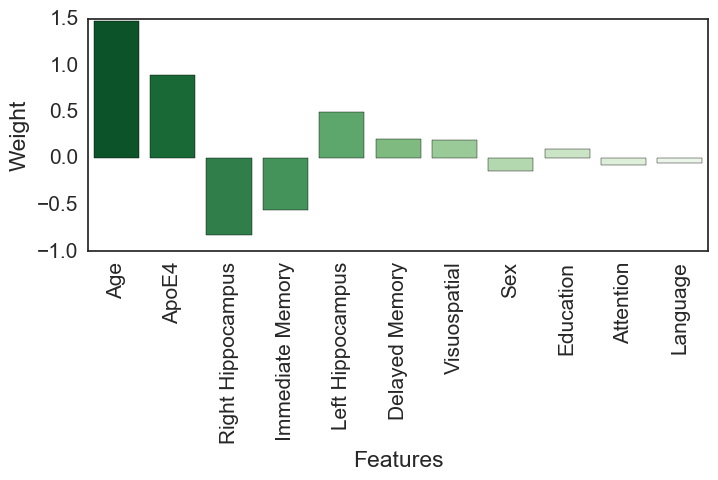

In [1414]:
plt.close()
fig,ax = plt.subplots(figsize=(8,3))
fig = sns.barplot(x = jnk[abs(jnk.weights)>0].index,
            y='weights',
            data=jnk[abs(jnk.weights)>0], palette='Greens_r')
for item in fig.get_xticklabels():
    item.set_rotation(90)
sns.plt.xlabel('Features')
sns.plt.ylabel('Weight')
fig = fig.get_figure() 
#fig.savefig(
#        '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/tPSO_Manuscript/Prediction/Revisions/manuscript/DEMO_weight_values.pdf',
#        bbox_inches='tight')
plt.show()

In [523]:
demos = ['Age', 'Gender', 'Education', 'TIV', 'FD']
apoe = ['ApoE4']
cog = cog_cols + ['MoCA']
hipps = ['lhipp','rhipp']
iter_train = pandas.DataFrame(nmm_train, copy=True).loc[super_train.index]
iter_test = pandas.DataFrame(nmm_test, copy = True).loc[super_test.index]
combos = list(itertools.product([0,1],repeat=4))
ps = [None, 0.5, 0.2, 0.1, 0.05, 0.01, 0.005, 0.001]

In [484]:
models = pandas.DataFrame(index = range(768), columns = ['validation','test','ld','p',
                                                        'demos','apoe','cog','hipps'])

In [556]:
reload(kfl)

<module 'kfold_learning' from '/Users/jakevogel/git/hack_projects/kfold_learning.py'>

In [978]:
cnt=0
for sheet in ld_sheetz:
    dens = sheet.split('_')[3]
    print('>'*15,'working on density',dens,'<'*15)
    rsdf = pandas.read_csv(sheet, index_col=0).transpose()
    rsdf.index = ld_05[ld_05.columns[1]]
    nids = []
    for sid in rsdf.index:
        nids.append(idz.loc[int(sid[1:7])][idz.columns[0]])
    rsdf.index = nids
    nmmdf_train = pandas.concat([gm2_train[gm2_train.columns[:444]], 
                                 rsdf.loc[gm2_train.index]], axis=1).loc[super_train.index]
    nmmdf_test = pandas.concat([gm2_test[gm2_test.columns[:444]], 
                                rsdf.loc[gm2_test.index]], axis=1).loc[super_test.index]
    ldy = ld_05.loc[super_train.index].tPSO
    ldt_y = ld_05.loc[super_test.index].tPSO
    for p in ps:
        print('*'*10,'working on p',p,'<'*10)
        p_cutoff = p
        folds = 3
        for c,combo in enumerate(combos):
            print('working on combo',c)
            addcols = []
            if combo[0] == 1:
                addcols += demos
            if combo[1] == 1:
                addcols += apoe 
            if combo[2] == 1:
                addcols += cog
            if combo[3] == 1:
                addcols += hipps
            if len(addcols) > 0:
                for col in addcols:
                    nmmdf_train[col] = super_train[col]
                    nmmdf_test[col] = super_test[col]
            val, tst = kfl.kfold_feature_learning(nmmdf_train, nmmdf_test, ldy, ldt_y, 
                                                  folds = folds, p_cutoff = p_cutoff, 
                                                  output='scores', scale=True,
                                                  keep_cols = addcols, verbose=False)
            models.ix[cnt,'ld'] = dens
            models.ix[cnt,'p'] = p
            models.loc[cnt,['demos','apoe','cog','hipps']] = list(combo)
            models.ix[cnt,'validation'] = val
            models.ix[cnt,'test'] = tst
            cnt += 1
            models.to_csv('/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/tPSO_Manuscript/Prediction/Revisions/data/model_fits.csv')

>>>>>>>>>>>>>>> working on density 10 <<<<<<<<<<<<<<<
********** working on p None <<<<<<<<<<
working on combo 0
testing prediction accuracy2 is 6.16362552299 percent 
 p = 0.00543175298019 
 r = 0.248266500418
working on combo 1
testing prediction accuracy2 is 6.16362552299 percent 
 p = 0.00543175298019 
 r = 0.248266500418
working on combo 2
testing prediction accuracy2 is 6.16362552299 percent 
 p = 0.00543175298019 
 r = 0.248266500418
working on combo 3
testing prediction accuracy2 is 6.16362552299 percent 
 p = 0.00543175298019 
 r = 0.248266500418
working on combo 4
testing prediction accuracy2 is 6.16362552299 percent 
 p = 0.00543175298019 
 r = 0.248266500418
working on combo 5
testing prediction accuracy2 is 6.16362552299 percent 
 p = 0.00543175298019 
 r = 0.248266500418
working on combo 6
testing prediction accuracy2 is 6.16362552299 percent 
 p = 0.00543175298019 
 r = 0.248266500418
working on combo 7
testing prediction accuracy2 is 6.16362552299 percent 
 p = 0.005431

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 57.3390060676 percent 
 p = 2.55838411124e-24 
 r = 0.757225237744
working on combo 1


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 57.3343908284 percent 
 p = 2.57542319853e-24 
 r = 0.757194762452
working on combo 2


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 57.8123578435 percent 
 p = 1.29015064925e-24 
 r = 0.760344381472
working on combo 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 57.8011998313 percent 
 p = 1.3112545604e-24 
 r = 0.760271003204
working on combo 4


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 57.3116995936 percent 
 p = 2.66083487691e-24 
 r = 0.757044910118
working on combo 5


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 57.3153930139 percent 
 p = 2.64674506517e-24 
 r = 0.757069303393
working on combo 6


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 57.7922680978 percent 
 p = 1.32839218993e-24 
 r = 0.760212260476
working on combo 7


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 57.7869602221 percent 
 p = 1.33868078886e-24 
 r = 0.760177349189
working on combo 8


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 57.3263326188 percent 
 p = 2.6054415093e-24 
 r = 0.757141549638
working on combo 9


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 57.3293053323 percent 
 p = 2.59432774614e-24 
 r = 0.757161180544
working on combo 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 57.8079360586 percent 
 p = 1.29847359561e-24 
 r = 0.760315303401
working on combo 11


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 57.7987672791 percent 
 p = 1.31590030987e-24 
 r = 0.760255005107
working on combo 12


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 57.2998285574 percent 
 p = 2.70662262359e-24 
 r = 0.75696650228
working on combo 13


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 57.3100372252 percent 
 p = 2.66720060564e-24 
 r = 0.757033930714
working on combo 14


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 57.781370762 percent 
 p = 1.34959995159e-24 
 r = 0.760140584116
working on combo 15


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 57.7782506677 percent 
 p = 1.3557332008e-24 
 r = 0.760120060699
********** working on p 0.2 <<<<<<<<<<
working on combo 0


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 61.7282214167 percent 
 p = 3.28155903981e-27 
 r = 0.785673096247
working on combo 1


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 59.4276255933 percent 
 p = 1.17644667927e-25 
 r = 0.77089315468
working on combo 2


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 55.8551628035 percent 
 p = 2.0858715541e-23 
 r = 0.747363116587
working on combo 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 55.8546964326 percent 
 p = 2.08722466567e-23 
 r = 0.747359996471
working on combo 4


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 61.7279595781 percent 
 p = 3.28293561567e-27 
 r = 0.785671429912
working on combo 5


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 59.4276033201 percent 
 p = 1.17648629077e-25 
 r = 0.770893010216
working on combo 6


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 55.8550702994 percent 
 p = 2.08613987347e-23 
 r = 0.747362497717
working on combo 7


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 55.8546144581 percent 
 p = 2.08746259261e-23 
 r = 0.747359448044
working on combo 8


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 59.9272449686 percent 
 p = 5.50234157167e-26 
 r = 0.77412689508
working on combo 9


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 59.4275598134 percent 
 p = 1.17656366837e-25 
 r = 0.770892728033
working on combo 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 55.8532617435 percent 
 p = 2.09139263688e-23 
 r = 0.74735039803
working on combo 11


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 55.853420735 percent 
 p = 2.09093034126e-23 
 r = 0.74735146173
working on combo 12


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 59.9272607277 percent 
 p = 5.50220887329e-26 
 r = 0.774126996866
working on combo 13


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 59.4275552006 percent 
 p = 1.17657187274e-25 
 r = 0.770892698114
working on combo 14


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 55.8532617435 percent 
 p = 2.09139263688e-23 
 r = 0.74735039803
working on combo 15


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 55.853420735 percent 
 p = 2.09093034126e-23 
 r = 0.74735146173
********** working on p 0.1 <<<<<<<<<<
working on combo 0


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 45.7897940237 percent 
 p = 6.34419999648e-18 
 r = 0.676681564872
working on combo 1


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 45.7897875295 percent 
 p = 6.34424679267e-18 
 r = 0.676681516886
working on combo 2


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 45.5765709328 percent 
 p = 8.07889005358e-18 
 r = 0.675104221086
working on combo 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 45.5765482904 percent 
 p = 8.07909702575e-18 
 r = 0.67510405339
working on combo 4


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 47.424439023 percent 
 p = 9.63577956485e-19 
 r = 0.688654042484
working on combo 5


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 47.4272157791 percent 
 p = 9.60451320651e-19 
 r = 0.688674202937
working on combo 6


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 47.218943735 percent 
 p = 1.22501918385e-18 
 r = 0.687160416024
working on combo 7


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 47.2754844038 percent 
 p = 1.14682546163e-18 
 r = 0.687571701016
working on combo 8


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 46.1271306392 percent 
 p = 4.31984872315e-18 
 r = 0.679169571162
working on combo 9


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 46.1271225692 percent 
 p = 4.31988856182e-18 
 r = 0.679169511751
working on combo 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 46.0028932961 percent 
 p = 4.97803448131e-18 
 r = 0.678254327639
working on combo 11


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 46.0028803264 percent 
 p = 4.97810809659e-18 
 r = 0.678254232028
working on combo 12


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 48.0525433414 percent 
 p = 4.59965424597e-19 
 r = 0.693199418215
working on combo 13


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 48.0525413392 percent 
 p = 4.59966515274e-19 
 r = 0.693199403774
working on combo 14


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 47.9631761533 percent 
 p = 5.11272405037e-19 
 r = 0.692554518816
working on combo 15


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 47.9631452642 percent 
 p = 5.1129107765e-19 
 r = 0.692554295808
********** working on p 0.05 <<<<<<<<<<
working on combo 0


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 42.9674517297 percent 
 p = 1.44629594224e-16 
 r = 0.655495627214
working on combo 1


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 42.9256024854 percent 
 p = 1.51318945732e-16 
 r = 0.655176331116
working on combo 2


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 42.7893329559 percent 
 p = 1.75281167333e-16 
 r = 0.654135559009
working on combo 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 42.7444261617 percent 
 p = 1.83967654055e-16 
 r = 0.653792215935
working on combo 4


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 46.1804665959 percent 
 p = 4.06429348728e-18 
 r = 0.679562113393
working on combo 5


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 46.1246192305 percent 
 p = 4.33226407658e-18 
 r = 0.679151082091
working on combo 6


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 45.9091419069 percent 
 p = 5.53913909717e-18 
 r = 0.677562852486
working on combo 7


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 45.8703345972 percent 
 p = 5.78921249358e-18 
 r = 0.677276417699
working on combo 8


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 45.2471973981 percent 
 p = 1.1714420459e-17 
 r = 0.672660370455
working on combo 9


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 45.2357535385 percent 
 p = 1.18661643773e-17 
 r = 0.672575300903
working on combo 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 44.6155969901 percent 
 p = 2.37419995808e-17 
 r = 0.667949077326
working on combo 11


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 44.5704006537 percent 
 p = 2.49654663728e-17 
 r = 0.667610669879
working on combo 12


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 49.0650969088 percent 
 p = 1.37045379433e-19 
 r = 0.700464823591
working on combo 13


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 49.0376449619 percent 
 p = 1.4166298352e-19 
 r = 0.70026884096
working on combo 14


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 49.3278703128 percent 
 p = 9.97045957781e-20 
 r = 0.702338026258
working on combo 15


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 49.3080906144 percent 
 p = 1.02126526482e-19 
 r = 0.702197198901
********** working on p 0.01 <<<<<<<<<<
working on combo 0


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 27.080919825 percent 
 p = 5.83279507745e-10 
 r = 0.520393311112
working on combo 1


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 27.1512013772 percent 
 p = 5.49285626015e-10 
 r = 0.521068146956
working on combo 2


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 27.2540807176 percent 
 p = 5.03016209342e-10 
 r = 0.522054410168
working on combo 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 27.1915018306 percent 
 p = 5.30681473284e-10 
 r = 0.521454713571
working on combo 4


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 30.860633988 percent 
 p = 2.13250994673e-11 
 r = 0.555523482744
working on combo 5


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 31.0271862437 percent 
 p = 1.83604794105e-11 
 r = 0.557020522456
working on combo 6


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 30.896448222 percent 
 p = 2.06502312969e-11 
 r = 0.555845735992
working on combo 7


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 30.7724720704 percent 
 p = 2.30803087617e-11 
 r = 0.55472941215
working on combo 8


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 30.8998753668 percent 
 p = 2.05867651175e-11 
 r = 0.555876563337
working on combo 9


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 30.9337256141 percent 
 p = 1.99701315115e-11 
 r = 0.556180956291
working on combo 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 30.8302750149 percent 
 p = 2.19141441549e-11 
 r = 0.555250168977
working on combo 11


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 30.8302750149 percent 
 p = 2.19141441549e-11 
 r = 0.555250168977
working on combo 12


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 34.8431195834 percent 
 p = 5.39592487851e-13 
 r = 0.590280607706
working on combo 13


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 34.8186763686 percent 
 p = 5.5226578287e-13 
 r = 0.590073523967
working on combo 14


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 35.0060386877 percent 
 p = 4.62139176955e-13 
 r = 0.591659012335
working on combo 15


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 34.7233222474 percent 
 p = 6.04567478816e-13 
 r = 0.589264984938
********** working on p 0.005 <<<<<<<<<<
working on combo 0
testing prediction accuracy2 is 22.9924500029 percent 
 p = 1.75618786504e-08 
 r = 0.479504431709
working on combo 1


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 18.5240906899 percent 
 p = 6.06087116633e-07 
 r = 0.430396220823
working on combo 2


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 22.9664895069 percent 
 p = 1.79361968869e-08 
 r = 0.479233653941
working on combo 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 10.4205004788 percent 
 p = 0.000255555107642 
 r = 0.322807999883
working on combo 4


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 26.3890605145 percent 
 p = 1.05041569398e-09 
 r = 0.513702837392
working on combo 5


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 23.4695250102 percent 
 p = 1.19056771791e-08 
 r = 0.484453558251
working on combo 6


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 26.3716652598 percent 
 p = 1.06599738349e-09 
 r = 0.513533497056
working on combo 7


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 26.2594407641 percent 
 p = 1.17213932846e-09 
 r = 0.512439662439
working on combo 8


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 26.2902602793 percent 
 p = 1.14199489189e-09 
 r = 0.512740287859
working on combo 9


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 26.3470188803 percent 
 p = 1.08846479388e-09 
 r = 0.513293472395
working on combo 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 26.4223572726 percent 
 p = 1.02121357184e-09 
 r = 0.514026821019
working on combo 11


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 26.2344281429 percent 
 p = 1.19717921036e-09 
 r = 0.512195549989
working on combo 12


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 30.9437626241 percent 
 p = 1.97908139732e-11 
 r = 0.556271180487
working on combo 13


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 30.4934632727 percent 
 p = 2.96264739937e-11 
 r = 0.55220886694
working on combo 14


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 31.3129426842 percent 
 p = 1.4190682463e-11 
 r = 0.55957968766
working on combo 15


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 31.0119084529 percent 
 p = 1.86145816725e-11 
 r = 0.556883367079
********** working on p 0.001 <<<<<<<<<<
working on combo 0
testing prediction accuracy2 is 17.3255659885 percent 
 p = 1.52336666257e-06 
 r = 0.416239906647
working on combo 1


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 17.4275218041 percent 
 p = 1.40909523494e-06 
 r = 0.417462834323
working on combo 2


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 18.905806362 percent 
 p = 4.50845568105e-07 
 r = 0.434808076765
working on combo 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 18.904421766 percent 
 p = 4.51330679553e-07 
 r = 0.434792154552
working on combo 4


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 20.9414023733 percent 
 p = 9.11818240435e-08 
 r = 0.457617770342
working on combo 5


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 21.0222941861 percent 
 p = 8.55081238761e-08 
 r = 0.458500754483
working on combo 6


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 22.162850509 percent 
 p = 3.43491713086e-08 
 r = 0.470774367495
working on combo 7


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 22.135235161 percent 
 p = 3.51209966526e-08 
 r = 0.47048097901
working on combo 8


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 19.0814914899 percent 
 p = 3.93288425445e-07 
 r = 0.43682366568
working on combo 9


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 18.2267039738 percent 
 p = 7.62612768389e-07 
 r = 0.426927440835
working on combo 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 18.2658062191 percent 
 p = 7.39951196435e-07 
 r = 0.427385145029
working on combo 11


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 18.1840402646 percent 
 p = 7.8812007251e-07 
 r = 0.426427488145
working on combo 12


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 24.1739500061 percent 
 p = 6.6795317682e-09 
 r = 0.491670113044
working on combo 13


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 24.5733861796 percent 
 p = 4.80258470028e-09 
 r = 0.495715504897
working on combo 14


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 23.7143905339 percent 
 p = 9.74402784271e-09 
 r = 0.486974234779
working on combo 15


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 24.6458070628 percent 
 p = 4.5229842086e-09 
 r = 0.496445435701
>>>>>>>>>>>>>>> working on density 2 <<<<<<<<<<<<<<<
********** working on p None <<<<<<<<<<
working on combo 0
testing prediction accuracy2 is 59.286786482 percent 
 p = 1.45504459088e-25 
 r = 0.769979132717
working on combo 1
testing prediction accuracy2 is 59.286786482 percent 
 p = 1.45504459088e-25 
 r = 0.769979132717
working on combo 2
testing prediction accuracy2 is 59.286786482 percent 
 p = 1.45504459088e-25 
 r = 0.769979132717
working on combo 3
testing prediction accuracy2 is 59.286786482 percent 
 p = 1.45504459088e-25 
 r = 0.769979132717
working on combo 4
testing prediction accuracy2 is 59.286786482 percent 
 p = 1.45504459088e-25 
 r = 0.769979132717
working on combo 5
testing prediction accuracy2 is 59.286786482 percent 
 p = 1.45504459088e-25 
 r = 0.769979132717
working on combo 6
testing prediction accuracy2 is 59.286786482 percent 
 p = 1.45504459088e-25 
 r = 0.769

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 75.431434135 percent 
 p = 5.38429338761e-39 
 r = 0.868512718013
working on combo 1


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 75.431434135 percent 
 p = 5.38429338761e-39 
 r = 0.868512718013
working on combo 2


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 73.9066399097 percent 
 p = 2.14107026397e-37 
 r = 0.85968971094
working on combo 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 73.9066399097 percent 
 p = 2.14107026397e-37 
 r = 0.85968971094
working on combo 4


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 75.431434135 percent 
 p = 5.38429338761e-39 
 r = 0.868512718013
working on combo 5


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 75.431434135 percent 
 p = 5.38429338761e-39 
 r = 0.868512718013
working on combo 6


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 73.9066399097 percent 
 p = 2.14107026397e-37 
 r = 0.85968971094
working on combo 7


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 73.9066399097 percent 
 p = 2.14107026397e-37 
 r = 0.85968971094
working on combo 8


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 76.3301147409 percent 
 p = 5.51325479527e-40 
 r = 0.873671075067
working on combo 9


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 76.3301147409 percent 
 p = 5.51325479527e-40 
 r = 0.873671075067
working on combo 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 74.5910036868 percent 
 p = 4.21288861429e-38 
 r = 0.863660834395
working on combo 11


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 74.5910036868 percent 
 p = 4.21288861429e-38 
 r = 0.863660834395
working on combo 12


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 76.3301147409 percent 
 p = 5.51325479527e-40 
 r = 0.873671075067
working on combo 13


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 76.3301147409 percent 
 p = 5.51325479527e-40 
 r = 0.873671075067
working on combo 14


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 74.5910036868 percent 
 p = 4.21288861429e-38 
 r = 0.863660834395
working on combo 15


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 74.5910036868 percent 
 p = 4.21288861429e-38 
 r = 0.863660834395
********** working on p 0.2 <<<<<<<<<<
working on combo 0


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 68.9771530799 percent 
 p = 8.50230695755e-33 
 r = 0.830524852607
working on combo 1


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 69.4806863504 percent 
 p = 3.12229118025e-33 
 r = 0.833550756405
working on combo 2


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 67.1522841212 percent 
 p = 2.81487164703e-31 
 r = 0.819464972535
working on combo 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 67.9982252994 percent 
 p = 5.696473024e-32 
 r = 0.82461036435
working on combo 4


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 69.5219297378 percent 
 p = 2.874235769e-33 
 r = 0.83379811548
working on combo 5


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 69.5193078981 percent 
 p = 2.88941041495e-33 
 r = 0.833782393062
working on combo 6


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 67.5385715891 percent 
 p = 1.36411764364e-31 
 r = 0.821818541949
working on combo 7


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 68.0540896645 percent 
 p = 5.11853145542e-32 
 r = 0.824949026695
working on combo 8


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 68.037692128 percent 
 p = 5.28191094056e-32 
 r = 0.824849635558
working on combo 9


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 68.8935221174 percent 
 p = 1.0025700853e-32 
 r = 0.830021217304
working on combo 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 65.6528070301 percent 
 p = 4.3330737746e-30 
 r = 0.81026419784
working on combo 11


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 66.3061240508 percent 
 p = 1.33641243547e-30 
 r = 0.814285724121
working on combo 12


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 68.9563132558 percent 
 p = 8.85913017807e-33 
 r = 0.830399381357
working on combo 13


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 69.7390447096 percent 
 p = 1.85552140416e-33 
 r = 0.835099064241
working on combo 14


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 66.7800215986 percent 
 p = 5.61282593094e-31 
 r = 0.817190440464
working on combo 15


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 67.6215548694 percent 
 p = 1.16622293053e-31 
 r = 0.822323262892
********** working on p 0.1 <<<<<<<<<<
working on combo 0


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 59.646010421 percent 
 p = 8.44920772587e-26 
 r = 0.772308296091
working on combo 1


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 59.5311611822 percent 
 p = 1.00580475704e-25 
 r = 0.771564392531
working on combo 2


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 59.6791218587 percent 
 p = 8.03438097297e-26 
 r = 0.772522633058
working on combo 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 59.6791262088 percent 
 p = 8.03432781263e-26 
 r = 0.772522661213
working on combo 4


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 60.7318276302 percent 
 p = 1.58638184239e-26 
 r = 0.77930627888
working on combo 5


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 60.4938527783 percent 
 p = 2.29774323615e-26 
 r = 0.777777942463
working on combo 6


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 60.6133988889 percent 
 p = 1.90808350437e-26 
 r = 0.77854607371
working on combo 7


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 60.6133981871 percent 
 p = 1.90808558883e-26 
 r = 0.778546069203
working on combo 8


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 60.1481940957 percent 
 p = 3.92009355069e-26 
 r = 0.775552668074
working on combo 9


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 60.1481925968 percent 
 p = 3.9201025923e-26 
 r = 0.775552658411
working on combo 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 59.7862633454 percent 
 p = 6.82471434466e-26 
 r = 0.773215774188
working on combo 11


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 59.7862704335 percent 
 p = 6.8246405718e-26 
 r = 0.773215820024
working on combo 12


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 61.6740725683 percent 
 p = 3.57866961597e-27 
 r = 0.785328418996
working on combo 13


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 61.6740716581 percent 
 p = 3.57867482635e-27 
 r = 0.785328413201
working on combo 14


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  Converge

testing prediction accuracy2 is 61.3200312014 percent 
 p = 6.28839339343e-27 
 r = 0.783071077243
working on combo 15


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  Converge

testing prediction accuracy2 is 61.320035199 percent 
 p = 6.28835354901e-27 
 r = 0.783071102768
********** working on p 0.05 <<<<<<<<<<
working on combo 0


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 52.1622004858 percent 
 p = 2.8978733365e-21 
 r = 0.722234037455
working on combo 1


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 52.1615081708 percent 
 p = 2.90045136392e-21 
 r = 0.722229244567
working on combo 2


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 52.3730871556 percent 
 p = 2.20894470816e-21 
 r = 0.723692525563
working on combo 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 52.4342560353 percent 
 p = 2.04123264624e-21 
 r = 0.724115018732
working on combo 4


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 53.2053103315 percent 
 p = 7.47919837319e-22 
 r = 0.72941970313
working on combo 5


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 53.2146677527 percent 
 p = 7.38788149569e-22 
 r = 0.729483843226
working on combo 6


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 53.0727264219 percent 
 p = 8.89886836949e-22 
 r = 0.728510304813
working on combo 7


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 52.8061415258 percent 
 p = 1.26027697431e-21 
 r = 0.726678343738
working on combo 8


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 54.4733780963 percent 
 p = 1.38384941757e-22 
 r = 0.738060824704
working on combo 9


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 54.4899887089 percent 
 p = 1.35318458361e-22 
 r = 0.738173344878
working on combo 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 54.1557035831 percent 
 p = 2.12097412525e-22 
 r = 0.735905588939
working on combo 11


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 54.1761442888 percent 
 p = 2.06367412241e-22 
 r = 0.736044457141
working on combo 12


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 56.886163587 percent 
 p = 4.89066555044e-24 
 r = 0.754229166679
working on combo 13


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 56.9033799812 percent 
 p = 4.7722487453e-24 
 r = 0.754343290427
working on combo 14


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 56.2023127815 percent 
 p = 1.28477317937e-23 
 r = 0.749682017802
working on combo 15


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 55.9680415581 percent 
 p = 1.78252031602e-23 
 r = 0.748117915559
********** working on p 0.01 <<<<<<<<<<
working on combo 0


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 37.771327299 percent 
 p = 3.14136769803e-14 
 r = 0.614583820963
working on combo 1


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 37.812984531 percent 
 p = 3.01403844625e-14 
 r = 0.614922633597
working on combo 2


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 37.7948216725 percent 
 p = 3.06891785582e-14 
 r = 0.614774931764
working on combo 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 40.8061590182 percent 
 p = 1.43361587448e-15 
 r = 0.638796986673
working on combo 4


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 40.8145276346 percent 
 p = 1.42116444702e-15 
 r = 0.638862486256
working on combo 5


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 40.866605681 percent 
 p = 1.34603675353e-15 
 r = 0.639269940486
working on combo 6


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 40.7419377532 percent 
 p = 1.53281024756e-15 
 r = 0.638294115226
working on combo 7


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 40.791401489 percent 
 p = 1.45583533297e-15 
 r = 0.638681465905
working on combo 8


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 40.604871439 percent 
 p = 1.76766078242e-15 
 r = 0.637219518212
working on combo 9


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 40.6751093828 percent 
 p = 1.64320223621e-15 
 r = 0.637770408398
working on combo 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 41.137226959 percent 
 p = 1.01428400013e-15 
 r = 0.641383091132
working on combo 11


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 41.1708453209 percent 
 p = 9.79160916298e-16 
 r = 0.641645114693
working on combo 12


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 44.6599601026 percent 
 p = 2.25985335455e-17 
 r = 0.668281079357
working on combo 13


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 44.6576718285 percent 
 p = 2.26561652411e-17 
 r = 0.668263958541
working on combo 14


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 45.2352487389 percent 
 p = 1.18729023058e-17 
 r = 0.672571548156
working on combo 15


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 44.7649603708 percent 
 p = 2.0103663153e-17 
 r = 0.66906621773
********** working on p 0.005 <<<<<<<<<<
working on combo 0
testing prediction accuracy2 is 29.8483555127 percent 
 p = 5.25823056246e-11 
 r = 0.546336485261
working on combo 1


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 29.8334849452 percent 
 p = 5.32791848548e-11 
 r = 0.546200374818
working on combo 2


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 29.924166874 percent 
 p = 4.91667285892e-11 
 r = 0.547029860922
working on combo 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 29.8924965804 percent 
 p = 5.056616595e-11 
 r = 0.546740309291
working on combo 4


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 32.280046581 percent 
 p = 5.88916869346e-12 
 r = 0.568155318385
working on combo 5


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 32.2958641751 percent 
 p = 5.80448895753e-12 
 r = 0.568294502658
working on combo 6


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 32.1038624118 percent 
 p = 6.91864190126e-12 
 r = 0.566602703945
working on combo 7


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 32.236797188 percent 
 p = 6.12696447889e-12 
 r = 0.567774578403
working on combo 8


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 32.0623624764 percent 
 p = 7.1858197969e-12 
 r = 0.566236368281
working on combo 9


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 33.3196174705 percent 
 p = 2.25762765444e-12 
 r = 0.577231474112
working on combo 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 34.2456419857 percent 
 p = 9.49463032803e-13 
 r = 0.585197761322
working on combo 11


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 34.020580275 percent 
 p = 1.17318849498e-12 
 r = 0.583271637189
working on combo 12


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 35.5430392857 percent 
 p = 2.76575681424e-13 
 r = 0.596179832649
working on combo 13


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 36.6314874014 percent 
 p = 9.64635404622e-14 
 r = 0.605239517888
working on combo 14


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 37.9514184016 percent 
 p = 2.62632106659e-14 
 r = 0.616047225476
working on combo 15


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 38.1881120991 percent 
 p = 2.07396161918e-14 
 r = 0.617965307271
********** working on p 0.001 <<<<<<<<<<
working on combo 0
testing prediction accuracy2 is 16.2169696364 percent 
 p = 3.5389146683e-06 
 r = 0.402702987776
working on combo 1


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 16.1425211386 percent 
 p = 3.74382504022e-06 
 r = 0.401777564563
working on combo 2


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 16.2308886187 percent 
 p = 3.50185250932e-06 
 r = 0.402875770166
working on combo 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 16.188424964 percent 
 p = 3.61613682941e-06 
 r = 0.402348418214
working on combo 4


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 19.6144860735 percent 
 p = 2.59469305828e-07 
 r = 0.442882445729
working on combo 5


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 19.5682324471 percent 
 p = 2.69030222551e-07 
 r = 0.44235994899
working on combo 6


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 19.8121335116 percent 
 p = 2.2225233446e-07 
 r = 0.445108228543
working on combo 7


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 18.9511935326 percent 
 p = 4.35225274467e-07 
 r = 0.435329685786
working on combo 8


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 18.013956311 percent 
 p = 8.98448527544e-07 
 r = 0.424428513546
working on combo 9


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 17.3266292746 percent 
 p = 1.52212898916e-06 
 r = 0.416252678966
working on combo 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 18.3869870586 percent 
 p = 6.73858919611e-07 
 r = 0.428800502082
working on combo 11


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 19.1992181171 percent 
 p = 3.58841088807e-07 
 r = 0.438169123936
working on combo 12


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 22.5435835449 percent 
 p = 2.52669502982e-08 
 r = 0.474800837667
working on combo 13


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 21.6176346245 percent 
 p = 5.31975230226e-08 
 r = 0.464947681191
working on combo 14


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 23.6954687596 percent 
 p = 9.89627016492e-09 
 r = 0.486779917001
working on combo 15


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 25.1084402488 percent 
 p = 3.07945878913e-09 
 r = 0.501083229103
>>>>>>>>>>>>>>> working on density 4 <<<<<<<<<<<<<<<
********** working on p None <<<<<<<<<<
working on combo 0
testing prediction accuracy2 is 57.8687550265 percent 
 p = 1.18849079263e-24 
 r = 0.760715157115
working on combo 1
testing prediction accuracy2 is 57.8687550265 percent 
 p = 1.18849079263e-24 
 r = 0.760715157115
working on combo 2
testing prediction accuracy2 is 57.8687550265 percent 
 p = 1.18849079263e-24 
 r = 0.760715157115
working on combo 3
testing prediction accuracy2 is 57.8687550265 percent 
 p = 1.18849079263e-24 
 r = 0.760715157115
working on combo 4


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 59.9951955829 percent 
 p = 4.95847200057e-26 
 r = 0.774565656242
working on combo 5


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 59.9951955829 percent 
 p = 4.95847200057e-26 
 r = 0.774565656242
working on combo 6


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 59.9951955829 percent 
 p = 4.95847200057e-26 
 r = 0.774565656242
working on combo 7


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 59.9951955829 percent 
 p = 4.95847200057e-26 
 r = 0.774565656242
working on combo 8
testing prediction accuracy2 is 62.1465777836 percent 
 p = 1.67289046161e-27 
 r = 0.788331007785
working on combo 9
testing prediction accuracy2 is 62.1465777836 percent 
 p = 1.67289046161e-27 
 r = 0.788331007785
working on combo 10
testing prediction accuracy2 is 62.1465777836 percent 
 p = 1.67289046161e-27 
 r = 0.788331007785
working on combo 11
testing prediction accuracy2 is 62.1465777836 percent 
 p = 1.67289046161e-27 
 r = 0.788331007785
working on combo 12
testing prediction accuracy2 is 62.1465777836 percent 
 p = 1.67289046161e-27 
 r = 0.788331007785
working on combo 13
testing prediction accuracy2 is 62.1465777836 percent 
 p = 1.67289046161e-27 
 r = 0.788331007785
working on combo 14
testing prediction accuracy2 is 62.1465777836 percent 
 p = 1.67289046161e-27 
 r = 0.788331007785
working on combo 15
testing prediction accuracy2 is 62.1465777836 perc

/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 57.135205399 percent 
 p = 3.42747413273e-24 
 r = 0.755878332796
working on combo 2


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 57.5512880409 percent 
 p = 1.88378606993e-24 
 r = 0.758625652354
working on combo 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 57.5549610328 percent 
 p = 1.87381068487e-24 
 r = 0.758649860165
working on combo 4


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 57.2596439683 percent 
 p = 2.86744703957e-24 
 r = 0.756701023973
working on combo 5


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 57.2596057401 percent 
 p = 2.8676044231e-24 
 r = 0.756700771376
working on combo 6


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 57.5494729551 percent 
 p = 1.88873488621e-24 
 r = 0.758613689272
working on combo 7


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 57.5523692173 percent 
 p = 1.88084431672e-24 
 r = 0.758632778209
working on combo 8


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 57.6226798697 percent 
 p = 1.69893602509e-24 
 r = 0.759096040496
working on combo 9


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 57.6230288707 percent 
 p = 1.69807774026e-24 
 r = 0.759098339286
working on combo 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 57.559227743 percent 
 p = 1.86228807453e-24 
 r = 0.758677980061
working on combo 11


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 57.5611214136 percent 
 p = 1.8571964204e-24 
 r = 0.758690460027
working on combo 12


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 57.26281101 percent 
 p = 2.8544379609e-24 
 r = 0.756721950322
working on combo 13


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 57.2630408375 percent 
 p = 2.85349617449e-24 
 r = 0.756723468894
working on combo 14


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 57.5581974633 percent 
 p = 1.86506403092e-24 
 r = 0.758671190064
working on combo 15


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 57.5595504733 percent 
 p = 1.86141935564e-24 
 r = 0.758680106984
********** working on p 0.2 <<<<<<<<<<
working on combo 0


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 62.5060325293 percent 
 p = 9.32133290561e-28 
 r = 0.790607567187
working on combo 1


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 62.5591831033 percent 
 p = 8.54509843001e-28 
 r = 0.790943633284
working on combo 2


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 62.8186595293 percent 
 p = 5.57961499261e-28 
 r = 0.792582232512
working on combo 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 62.5037147713 percent 
 p = 9.35671640013e-28 
 r = 0.79059290897
working on combo 4


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 62.3829320995 percent 
 p = 1.13954478919e-27 
 r = 0.789828665595
working on combo 5


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 62.626875141 percent 
 p = 7.64800220536e-28 
 r = 0.79137143707
working on combo 6


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  Converge

testing prediction accuracy2 is 62.8182669888 percent 
 p = 5.58322643741e-28 
 r = 0.792579756169
working on combo 7


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 62.8695109108 percent 
 p = 5.13069466533e-28 
 r = 0.792902963236
working on combo 8


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 61.9540721674 percent 
 p = 2.28301606439e-27 
 r = 0.787109091343
working on combo 9


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 62.2364308513 percent 
 p = 1.44611461831e-27 
 r = 0.788900696231
working on combo 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 61.7442307203 percent 
 p = 3.19846269958e-27 
 r = 0.78577497237
working on combo 11


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 62.2261973402 percent 
 p = 1.47033257216e-27 
 r = 0.788835834253
working on combo 12


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 61.9582667544 percent 
 p = 2.2676379864e-27 
 r = 0.787135736416
working on combo 13


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 62.4383836914 percent 
 p = 1.04102828572e-27 
 r = 0.790179623196
working on combo 14


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  Converge

testing prediction accuracy2 is 61.6704299166 percent 
 p = 3.59958048288e-27 
 r = 0.785305226753
working on combo 15


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  Converge

testing prediction accuracy2 is 62.762435055 percent 
 p = 6.12102088333e-28 
 r = 0.792227461371
********** working on p 0.1 <<<<<<<<<<
working on combo 0


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 53.4604634712 percent 
 p = 5.34565587082e-22 
 r = 0.731166625819
working on combo 1


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 52.9263577818 percent 
 p = 1.07750196651e-21 
 r = 0.727505036284
working on combo 2


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 52.7737162644 percent 
 p = 1.31459174423e-21 
 r = 0.726455203467
working on combo 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 52.842333301 percent 
 p = 1.20225836168e-21 
 r = 0.726927323059
working on combo 4


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 54.917513832 percent 
 p = 7.57991341933e-23 
 r = 0.741063518411
working on combo 5


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 54.939241249 percent 
 p = 7.35885026621e-23 
 r = 0.7412101001
working on combo 6


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 55.2639306227 percent 
 p = 4.72047184366e-23 
 r = 0.743397138969
working on combo 7


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 55.2922955466 percent 
 p = 4.54019566916e-23 
 r = 0.743587893571
working on combo 8


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 53.5884085133 percent 
 p = 4.51404497415e-22 
 r = 0.732041040607
working on combo 9


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 53.8851492582 percent 
 p = 3.04422478776e-22 
 r = 0.734065046561
working on combo 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 52.9588509978 percent 
 p = 1.03275183188e-21 
 r = 0.727728321544
working on combo 11


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 53.10120476 percent 
 p = 8.57313955351e-22 
 r = 0.728705734574
working on combo 12


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 55.9520862071 percent 
 p = 1.82260483224e-23 
 r = 0.748011271353
working on combo 13


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 56.1607929988 percent 
 p = 1.36171021933e-23 
 r = 0.749405050682
working on combo 14


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 56.0662547484 percent 
 p = 1.5542044201e-23 
 r = 0.748774029654
working on combo 15


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 55.0078968966 percent 
 p = 6.70118975771e-23 
 r = 0.741673087665
********** working on p 0.05 <<<<<<<<<<
working on combo 0


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 47.0648834388 percent 
 p = 1.46569245786e-18 
 r = 0.686038507948
working on combo 1


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 46.9314583507 percent 
 p = 1.71131161731e-18 
 r = 0.6850653863
working on combo 2


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 47.0053428721 percent 
 p = 1.57068715195e-18 
 r = 0.685604425832
working on combo 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 46.8747936516 percent 
 p = 1.82748946116e-18 
 r = 0.684651689924
working on combo 4


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 50.3264759604 percent 
 p = 2.93226583238e-20 
 r = 0.70941155869
working on combo 5


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 50.1877253503 percent 
 p = 3.48080631531e-20 
 r = 0.708432956251
working on combo 6


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 50.3761627311 percent 
 p = 2.75729592586e-20 
 r = 0.709761669373
working on combo 7


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 50.2231072181 percent 
 p = 3.33201939119e-20 
 r = 0.708682631494
working on combo 8


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 49.4816046221 percent 
 p = 8.27112298706e-20 
 r = 0.703431621567
working on combo 9


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 49.6250442479 percent 
 p = 6.9443008941e-20 
 r = 0.70445045424
working on combo 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 48.9442767047 percent 
 p = 1.58543601268e-19 
 r = 0.699601863239
working on combo 11


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 49.1269695985 percent 
 p = 1.27174184076e-19 
 r = 0.700906338953
working on combo 12


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 53.5671468744 percent 
 p = 4.64283246746e-22 
 r = 0.731895804568
working on combo 13


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 53.7176894747 percent 
 p = 3.80330095065e-22 
 r = 0.732923525852
working on combo 14


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 53.7038038292 percent 
 p = 3.87402252306e-22 
 r = 0.732828791937
working on combo 15


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 53.877318124 percent 
 p = 3.07613786604e-22 
 r = 0.734011703748
********** working on p 0.01 <<<<<<<<<<
working on combo 0
testing prediction accuracy2 is 37.8988558517 percent 
 p = 2.76738183642e-14 
 r = 0.615620466291
working on combo 1


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 40.2399958487 percent 
 p = 2.57948115702e-15 
 r = 0.634350028365
working on combo 2


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 40.3895251526 percent 
 p = 2.20997385857e-15 
 r = 0.635527537976
working on combo 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 40.4761524151 percent 
 p = 2.02028551692e-15 
 r = 0.636208711156
working on combo 4


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 41.5934948876 percent 
 p = 6.27629783776e-16 
 r = 0.644930189149
working on combo 5


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 41.7168340412 percent 
 p = 5.50910433003e-16 
 r = 0.645885702281
working on combo 6


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 41.6227446323 percent 
 p = 6.08535774213e-16 
 r = 0.645156916047
working on combo 7


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 41.6968743664 percent 
 p = 5.62667717865e-16 
 r = 0.64573116981
working on combo 8


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 40.3212920774 percent 
 p = 2.37163072004e-15 
 r = 0.634990488728
working on combo 9


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 41.4972272745 percent 
 p = 6.94731842998e-16 
 r = 0.644183415454
working on combo 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 40.9225274972 percent 
 p = 1.26971441723e-15 
 r = 0.639707179084
working on combo 11


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 41.1323869651 percent 
 p = 1.01944168644e-15 
 r = 0.641345359109
working on combo 12


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 45.3488016738 percent 
 p = 1.04482545533e-17 
 r = 0.673415188972
working on combo 13


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 45.410052047 percent 
 p = 9.75108779246e-18 
 r = 0.673869809733
working on combo 14


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 45.5566899965 percent 
 p = 8.26264340613e-18 
 r = 0.674956961565
working on combo 15


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 45.5149852647 percent 
 p = 8.66157347419e-18 
 r = 0.674647947189
********** working on p 0.005 <<<<<<<<<<
working on combo 0
testing prediction accuracy2 is 31.8449178674 percent 
 p = 8.76074704783e-12 
 r = 0.564313014801
working on combo 1


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 21.6268774701 percent 
 p = 5.28056713568e-08 
 r = 0.465047067189
working on combo 2


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 31.6936030604 percent 
 p = 1.00525890538e-11 
 r = 0.562970719136
working on combo 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 31.7765411522 percent 
 p = 9.32289538367e-12 
 r = 0.563706848922
working on combo 4


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 35.8713162032 percent 
 p = 2.01666900049e-13 
 r = 0.598926675004
working on combo 5


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 35.638040756 percent 
 p = 2.52455182864e-13 
 r = 0.596976052753
working on combo 6


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 35.3298418379 percent 
 p = 3.3926957157e-13 
 r = 0.594389113611
working on combo 7


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 35.4070317142 percent 
 p = 3.15102372003e-13 
 r = 0.595038080413
working on combo 8


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 35.0152535893 percent 
 p = 4.58101559585e-13 
 r = 0.591736880626
working on combo 9


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 35.4143127369 percent 
 p = 3.12912231098e-13 
 r = 0.595099258417
working on combo 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 34.8864064697 percent 
 p = 5.1784785438e-13 
 r = 0.590647157529
working on combo 11


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 34.93803752 percent 
 p = 4.93037634763e-13 
 r = 0.591084067794
working on combo 12


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 40.1798653944 percent 
 p = 2.74465366364e-15 
 r = 0.633875897904
working on combo 13


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 41.0295866159 percent 
 p = 1.13529324679e-15 
 r = 0.640543414734
working on combo 14


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 39.9776203717 percent 
 p = 3.38031252065e-15 
 r = 0.632278580783
working on combo 15


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 39.9598071461 percent 
 p = 3.44279341478e-15 
 r = 0.632137699762
********** working on p 0.001 <<<<<<<<<<
working on combo 0
testing prediction accuracy2 is 13.922410244 percent 
 p = 1.97163035741e-05 
 r = 0.373127461386
working on combo 1


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 13.963097722 percent 
 p = 1.91305039452e-05 
 r = 0.373672285861
working on combo 2


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 14.8933742816 percent 
 p = 9.57202436081e-06 
 r = 0.385919347553
working on combo 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 14.891872055 percent 
 p = 9.58277618653e-06 
 r = 0.385899884102
working on combo 4


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 17.4463959065 percent 
 p = 1.3888894606e-06 
 r = 0.417688830429
working on combo 5


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 17.4515978277 percent 
 p = 1.38337097191e-06 
 r = 0.417751096081
working on combo 6


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 17.9952065966 percent 
 p = 9.11506689015e-07 
 r = 0.424207574149
working on combo 7


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 17.9952065966 percent 
 p = 9.11506689015e-07 
 r = 0.424207574149
working on combo 8


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 15.2413743312 percent 
 p = 7.37710619876e-06 
 r = 0.390402027803
working on combo 9


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 14.9291796113 percent 
 p = 9.31925572194e-06 
 r = 0.38638296561
working on combo 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 14.9496453623 percent 
 p = 9.17775203843e-06 
 r = 0.386647712554
working on combo 11


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 14.7696587685 percent 
 p = 1.04986739347e-05 
 r = 0.384313137539
working on combo 12


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 19.8162341371 percent 
 p = 2.21538799147e-07 
 r = 0.445154289399
working on combo 13


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 19.258192486 percent 
 p = 3.42721732641e-07 
 r = 0.438841571481
working on combo 14


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 20.628689485 percent 
 p = 1.16824662096e-07 
 r = 0.454188171191
working on combo 15


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 21.5428362225 percent 
 p = 5.64758959428e-08 
 r = 0.464142609792
>>>>>>>>>>>>>>> working on density 5 <<<<<<<<<<<<<<<
********** working on p None <<<<<<<<<<
working on combo 0
testing prediction accuracy2 is 53.5900016378 percent 
 p = 4.50453779707e-22 
 r = 0.732051921914
working on combo 1
testing prediction accuracy2 is 53.5900016378 percent 
 p = 4.50453779707e-22 
 r = 0.732051921914
working on combo 2
testing prediction accuracy2 is 53.5900016378 percent 
 p = 4.50453779707e-22 
 r = 0.732051921914
working on combo 3
testing prediction accuracy2 is 53.5900016378 percent 
 p = 4.50453779707e-22 
 r = 0.732051921914
working on combo 4
testing prediction accuracy2 is 60.0805508389 percent 
 p = 4.34973628176e-26 
 r = 0.775116448277
working on combo 5
testing prediction accuracy2 is 60.0805508389 percent 
 p = 4.34973628176e-26 
 r = 0.775116448277
working on combo 6
testing prediction accuracy2 is 60.0805508389 percent 
 p = 4.34973628176e-26 
 r

/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 55.8030832443 percent 
 p = 2.24243432792e-23 
 r = 0.747014613273
working on combo 2


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 55.8030392645 percent 
 p = 2.24257130763e-23 
 r = 0.747014318902
working on combo 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 55.8030642307 percent 
 p = 2.24249354667e-23 
 r = 0.747014486009
working on combo 4


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 55.803063728 percent 
 p = 2.24249511244e-23 
 r = 0.747014482644
working on combo 5


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 55.8030832443 percent 
 p = 2.24243432792e-23 
 r = 0.747014613273
working on combo 6


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 55.8030392645 percent 
 p = 2.24257130763e-23 
 r = 0.747014318902
working on combo 7


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 55.8030642307 percent 
 p = 2.24249354667e-23 
 r = 0.747014486009
working on combo 8


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 55.8029813804 percent 
 p = 2.24275160581e-23 
 r = 0.747013931466
working on combo 9


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 55.8030047886 percent 
 p = 2.24267869178e-23 
 r = 0.747014088145
working on combo 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 55.8029630374 percent 
 p = 2.24280874399e-23 
 r = 0.74701380869
working on combo 11


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 55.8029906011 percent 
 p = 2.24272288415e-23 
 r = 0.747013993183
working on combo 12


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 55.8029813804 percent 
 p = 2.24275160581e-23 
 r = 0.747013931466
working on combo 13


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 55.8030047886 percent 
 p = 2.24267869178e-23 
 r = 0.747014088145
working on combo 14


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 55.8029630374 percent 
 p = 2.24280874399e-23 
 r = 0.74701380869
working on combo 15


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 55.8029906011 percent 
 p = 2.24272288415e-23 
 r = 0.747013993183
********** working on p 0.2 <<<<<<<<<<
working on combo 0


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 61.517917288 percent 
 p = 4.59174411339e-27 
 r = 0.784333585205
working on combo 1


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 60.2169484934 percent 
 p = 3.52622531049e-26 
 r = 0.775995802137
working on combo 2


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 61.1207108015 percent 
 p = 8.61772825139e-27 
 r = 0.781797357386
working on combo 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 59.7345365292 percent 
 p = 7.38451763624e-26 
 r = 0.772881210337
working on combo 4


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 61.515880654 percent 
 p = 4.6066658592e-27 
 r = 0.784320601884
working on combo 5


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 60.2369527695 percent 
 p = 3.41912833893e-26 
 r = 0.776124685663
working on combo 6


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 61.1197371959 percent 
 p = 8.63096910355e-27 
 r = 0.781791130647
working on combo 7


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 59.7857485689 percent 
 p = 6.83007418123e-26 
 r = 0.773212445379
working on combo 8


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 63.3727590155 percent 
 p = 2.22317601207e-28 
 r = 0.796070091232
working on combo 9


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 63.8779831446 percent 
 p = 9.49133280969e-29 
 r = 0.799237030828
working on combo 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 59.0053044203 percent 
 p = 2.22029942781e-25 
 r = 0.768149102846
working on combo 11


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 59.6780912974 percent 
 p = 8.04698462806e-26 
 r = 0.772515962925
working on combo 12


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 63.3680352564 percent 
 p = 2.24081518633e-28 
 r = 0.796040421438
working on combo 13


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 63.8783428482 percent 
 p = 9.48554308042e-29 
 r = 0.799239281118
working on combo 14


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 59.0145172557 percent 
 p = 2.18989996345e-25 
 r = 0.76820906826
working on combo 15


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 59.6259477843 percent 
 p = 8.71073393849e-26 
 r = 0.77217839768
********** working on p 0.1 <<<<<<<<<<
working on combo 0


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 51.0107488221 percent 
 p = 1.24993173244e-20 
 r = 0.714218095697
working on combo 1


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 51.0197206722 percent 
 p = 1.23593920522e-20 
 r = 0.714280901832
working on combo 2


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 51.0160076081 percent 
 p = 1.24171131849e-20 
 r = 0.714254909735
working on combo 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 51.1398543711 percent 
 p = 1.06278501581e-20 
 r = 0.715121348941
working on combo 4


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 52.8446706209 percent 
 p = 1.19860312665e-21 
 r = 0.726943399591
working on combo 5


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 52.8522847311 percent 
 p = 1.18677140922e-21 
 r = 0.726995768427
working on combo 6


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 52.7453600678 percent 
 p = 1.36397378656e-21 
 r = 0.726260009004
working on combo 7


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 52.7790105901 percent 
 p = 1.30556860904e-21 
 r = 0.726491642004
working on combo 8


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 51.5600244774 percent 
 p = 6.25059081515e-21 
 r = 0.718053093283
working on combo 9


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 51.6423616482 percent 
 p = 5.6301021692e-21 
 r = 0.718626200804
working on combo 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 50.9451937667 percent 
 p = 1.35701168984e-20 
 r = 0.713759019324
working on combo 11


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 51.0116813445 percent 
 p = 1.24847013908e-20 
 r = 0.714224623942
working on combo 12


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 52.7853164263 percent 
 p = 1.29490104329e-21 
 r = 0.726535039942
working on combo 13


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 52.8924139665 percent 
 p = 1.12628731208e-21 
 r = 0.727271709656
working on combo 14


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 53.5912521297 percent 
 p = 4.49708912783e-22 
 r = 0.73206046287
working on combo 15


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 52.9201610435 percent 
 p = 1.08625027751e-21 
 r = 0.727462446065
********** working on p 0.05 <<<<<<<<<<
working on combo 0


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 44.444802634 percent 
 p = 2.87006382474e-17 
 r = 0.666669353083
working on combo 1


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 44.4034823536 percent 
 p = 3.00457559561e-17 
 r = 0.666359380167
working on combo 2


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 44.5191426161 percent 
 p = 2.64282141047e-17 
 r = 0.667226667753
working on combo 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 44.4197199205 percent 
 p = 2.95099244244e-17 
 r = 0.66648120694
working on combo 4


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 47.130599196 percent 
 p = 1.35781687396e-18 
 r = 0.686517291814
working on combo 5


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 47.0953502751 percent 
 p = 1.4146698244e-18 
 r = 0.68626052105
working on combo 6


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 47.3674825473 percent 
 p = 1.02996672065e-18 
 r = 0.688240383494
working on combo 7


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 47.2428451309 percent 
 p = 1.19134418443e-18 
 r = 0.687334308258
working on combo 8


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 46.0176943606 percent 
 p = 4.89471851442e-18 
 r = 0.678363430328
working on combo 9


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 46.1759183022 percent 
 p = 4.08549306904e-18 
 r = 0.679528647683
working on combo 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 44.1640931011 percent 
 p = 3.9150857814e-17 
 r = 0.664560705286
working on combo 11


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 44.2862287878 percent 
 p = 3.42097850387e-17 
 r = 0.665478991313
working on combo 12


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 51.098930858 percent 
 p = 1.11890549514e-20 
 r = 0.714835161824
working on combo 13


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 51.2226664739 percent 
 p = 9.57559893551e-21 
 r = 0.715700122076
working on combo 14


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 51.6333310201 percent 
 p = 5.6950813403e-21 
 r = 0.718563365474
working on combo 15


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 51.8659627826 percent 
 p = 4.23473176945e-21 
 r = 0.720180274532
********** working on p 0.01 <<<<<<<<<<
working on combo 0
testing prediction accuracy2 is 39.7882550204 percent 
 p = 4.10578998007e-15 
 r = 0.630779319734
working on combo 1


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 39.3906679818 percent 
 p = 6.16380545488e-15 
 r = 0.627619852951
working on combo 2


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 39.8708514129 percent 
 p = 3.77222808707e-15 
 r = 0.631433697334
working on combo 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 39.7165735397 percent 
 p = 4.4186839556e-15 
 r = 0.630210865819
working on combo 4


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 42.8583390551 percent 
 p = 1.62713893632e-16 
 r = 0.654662806757
working on combo 5


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 42.6531902357 percent 
 p = 2.02940980769e-16 
 r = 0.653094099159
working on combo 6


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 42.7632688793 percent 
 p = 1.80272425855e-16 
 r = 0.653936303315
working on combo 7


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 42.7105475544 percent 
 p = 1.90799991099e-16 
 r = 0.6535330715
working on combo 8


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 44.3897720872 percent 
 p = 3.05056344191e-17 
 r = 0.666256497808
working on combo 9


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 44.6513575442 percent 
 p = 2.28159459518e-17 
 r = 0.668216712932
working on combo 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 43.8006949308 percent 
 p = 5.83891781054e-17 
 r = 0.661820934474
working on combo 11


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 44.0807384669 percent 
 p = 4.29196579205e-17 
 r = 0.663933268235
working on combo 12


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 48.8420184769 percent 
 p = 1.79306280204e-19 
 r = 0.698870649526
working on combo 13


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 49.0852114021 percent 
 p = 1.33756318988e-19 
 r = 0.700608388489
working on combo 14


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 48.8392128953 percent 
 p = 1.79912110704e-19 
 r = 0.698850576985
working on combo 15


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 49.1550155344 percent 
 p = 1.22933453732e-19 
 r = 0.701106379478
********** working on p 0.005 <<<<<<<<<<
working on combo 0
testing prediction accuracy2 is 32.776513687 percent 
 p = 3.73215101699e-12 
 r = 0.572507761406
working on combo 1


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 26.2974938035 percent 
 p = 1.13503123521e-09 
 r = 0.512810820903
working on combo 2


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 32.5195623585 percent 
 p = 4.72779200315e-12 
 r = 0.570259259973
working on combo 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 32.4314606592 percent 
 p = 5.12608025404e-12 
 r = 0.569486265499
working on combo 4


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 36.251280478 percent 
 p = 1.39640025467e-13 
 r = 0.602090362637
working on combo 5


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 35.8663591258 percent 
 p = 2.02633427429e-13 
 r = 0.598885290567
working on combo 6


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 35.8863973195 percent 
 p = 1.98754216482e-13 
 r = 0.599052562965
working on combo 7


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 35.5606490144 percent 
 p = 2.71939544441e-13 
 r = 0.596327502421
working on combo 8


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 32.9387351965 percent 
 p = 3.2131362424e-12 
 r = 0.573922775263
working on combo 9


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 33.1083124871 percent 
 p = 2.74656420172e-12 
 r = 0.57539823155
working on combo 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 32.8101432123 percent 
 p = 3.61818171798e-12 
 r = 0.572801389771
working on combo 11


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 32.8799056334 percent 
 p = 3.39257599804e-12 
 r = 0.573410024619
working on combo 12


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 37.2291561284 percent 
 p = 5.36963287095e-14 
 r = 0.610156997242
working on combo 13


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 36.949050363 percent 
 p = 7.07084235241e-14 
 r = 0.607857305319
working on combo 14


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 36.9813387735 percent 
 p = 6.85045203331e-14 
 r = 0.608122839347
working on combo 15


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 36.8743492584 percent 
 p = 7.60783344511e-14 
 r = 0.607242531929
********** working on p 0.001 <<<<<<<<<<
working on combo 0
testing prediction accuracy2 is 15.4382926519 percent 
 p = 6.36388540023e-06 
 r = 0.392915928055
working on combo 1


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 15.3538838041 percent 
 p = 6.78015965118e-06 
 r = 0.391840322123
working on combo 2


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 16.3386000518 percent 
 p = 3.22771799267e-06 
 r = 0.404210341924
working on combo 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 16.3480369167 percent 
 p = 3.20473553172e-06 
 r = 0.404327057179
working on combo 4


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 18.6550518987 percent 
 p = 5.47649934515e-07 
 r = 0.431914944158
working on combo 5


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 18.5826709673 percent 
 p = 5.79223816142e-07 
 r = 0.431076222579
working on combo 6


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 19.2179742653 percent 
 p = 3.53635032515e-07 
 r = 0.438383100328
working on combo 7


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 19.2179742653 percent 
 p = 3.53635032515e-07 
 r = 0.438383100328
working on combo 8


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 17.0894077449 percent 
 p = 1.82437218576e-06 
 r = 0.413393368898
working on combo 9


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 17.3244158769 percent 
 p = 1.5247065201e-06 
 r = 0.416226090928
working on combo 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 16.5853462338 percent 
 p = 2.67707244592e-06 
 r = 0.407251104772
working on combo 11


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 16.4515725025 percent 
 p = 2.96295844314e-06 
 r = 0.405605380912
working on combo 12


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 21.3074668115 percent 
 p = 6.81470342912e-08 
 r = 0.461600117109
working on combo 13


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 20.7759051835 percent 
 p = 1.03971292269e-07 
 r = 0.455805936595
working on combo 14


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 21.9593322453 percent 
 p = 4.04545574236e-08 
 r = 0.468607855731
working on combo 15


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 23.0034102863 percent 
 p = 1.74061663974e-08 
 r = 0.479618705706
>>>>>>>>>>>>>>> working on density 6 <<<<<<<<<<<<<<<
********** working on p None <<<<<<<<<<
working on combo 0
testing prediction accuracy2 is 49.3327009839 percent 
 p = 9.91217433014e-20 
 r = 0.702372415346
working on combo 1
testing prediction accuracy2 is 49.3327009839 percent 
 p = 9.91217433014e-20 
 r = 0.702372415346
working on combo 2
testing prediction accuracy2 is 49.3327009839 percent 
 p = 9.91217433014e-20 
 r = 0.702372415346
working on combo 3
testing prediction accuracy2 is 49.3327009839 percent 
 p = 9.91217433014e-20 
 r = 0.702372415346
working on combo 4
testing prediction accuracy2 is 57.1847964343 percent 
 p = 3.19245067432e-24 
 r = 0.756206297477
working on combo 5
testing prediction accuracy2 is 57.1847964343 percent 
 p = 3.19245067432e-24 
 r = 0.756206297477
working on combo 6
testing prediction accuracy2 is 57.1847964343 percent 
 p = 3.19245067432e-24 
 r

/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 59.1066260668 percent 
 p = 1.90761555587e-25 
 r = 0.768808338058
working on combo 2


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 59.1066260668 percent 
 p = 1.90761555587e-25 
 r = 0.768808338058
working on combo 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 59.1066260668 percent 
 p = 1.90761555587e-25 
 r = 0.768808338058
working on combo 4


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 59.1066260668 percent 
 p = 1.90761555587e-25 
 r = 0.768808338058
working on combo 5


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 59.1066260668 percent 
 p = 1.90761555587e-25 
 r = 0.768808338058
working on combo 6


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 59.1066260668 percent 
 p = 1.90761555587e-25 
 r = 0.768808338058
working on combo 7


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 59.1066260668 percent 
 p = 1.90761555587e-25 
 r = 0.768808338058
working on combo 8


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 59.1066260668 percent 
 p = 1.90761555587e-25 
 r = 0.768808338058
working on combo 9


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 59.1066260668 percent 
 p = 1.90761555587e-25 
 r = 0.768808338058
working on combo 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 59.1066260668 percent 
 p = 1.90761555587e-25 
 r = 0.768808338058
working on combo 11


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 59.1066260668 percent 
 p = 1.90761555587e-25 
 r = 0.768808338058
working on combo 12


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 59.1066260668 percent 
 p = 1.90761555587e-25 
 r = 0.768808338058
working on combo 13


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 59.1066260668 percent 
 p = 1.90761555587e-25 
 r = 0.768808338058
working on combo 14


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 59.1066260668 percent 
 p = 1.90761555587e-25 
 r = 0.768808338058
working on combo 15


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 59.1066260668 percent 
 p = 1.90761555587e-25 
 r = 0.768808338058
********** working on p 0.2 <<<<<<<<<<
working on combo 0


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 60.2526964088 percent 
 p = 3.33709773604e-26 
 r = 0.776226103715
working on combo 1


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 60.0556073226 percent 
 p = 4.51958929966e-26 
 r = 0.774955529838
working on combo 2


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 58.3223436555 percent 
 p = 6.11765503872e-25 
 r = 0.763690668108
working on combo 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 58.2097626368 percent 
 p = 7.21867878618e-25 
 r = 0.762953226855
working on combo 4


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 60.2526898363 percent 
 p = 3.33713157417e-26 
 r = 0.776226061378
working on combo 5


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 60.0554366279 percent 
 p = 4.52077383672e-26 
 r = 0.774954428518
working on combo 6


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 58.3223396555 percent 
 p = 6.1176910584e-25 
 r = 0.763690641919
working on combo 7


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 58.2099376638 percent 
 p = 7.21682421993e-25 
 r = 0.76295437389
working on combo 8


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 59.9154107017 percent 
 p = 5.6028854923e-26 
 r = 0.774050455085
working on combo 9


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 59.8067094705 percent 
 p = 6.61514363561e-26 
 r = 0.77334797776
working on combo 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 58.4619480652 percent 
 p = 4.97958045092e-25 
 r = 0.764604133295
working on combo 11


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 58.4194701817 percent 
 p = 5.30180648343e-25 
 r = 0.764326305852
working on combo 12


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 59.9154107017 percent 
 p = 5.6028854923e-26 
 r = 0.774050455085
working on combo 13


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 59.8067086783 percent 
 p = 6.61515163219e-26 
 r = 0.773347972638
working on combo 14


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 58.4619480652 percent 
 p = 4.97958045092e-25 
 r = 0.764604133295
working on combo 15


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 58.4194701817 percent 
 p = 5.30180648343e-25 
 r = 0.764326305852
********** working on p 0.1 <<<<<<<<<<
working on combo 0


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 44.0128716289 percent 
 p = 4.62500100041e-17 
 r = 0.66342197453
working on combo 1


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 44.1134188236 percent 
 p = 4.14012987646e-17 
 r = 0.664179334394
working on combo 2


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 44.4226940273 percent 
 p = 2.94128045096e-17 
 r = 0.666503518575
working on combo 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 44.6724052347 percent 
 p = 2.22876116058e-17 
 r = 0.668374185877
working on combo 4


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 46.0749007051 percent 
 p = 4.58540741441e-18 
 r = 0.678784949046
working on combo 5


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 46.1716630004 percent 
 p = 4.10542552537e-18 
 r = 0.679497336275
working on combo 6


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 46.5358446162 percent 
 p = 2.70312141764e-18 
 r = 0.682171859697
working on combo 7


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 46.7827286637 percent 
 p = 2.03300313997e-18 
 r = 0.683979010378
working on combo 8


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 43.8933098453 percent 
 p = 5.27467528787e-17 
 r = 0.662520262674
working on combo 9


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 44.385145275 percent 
 p = 3.06623877276e-17 
 r = 0.666221774449
working on combo 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 44.3833071172 percent 
 p = 3.07248830667e-17 
 r = 0.666207978916
working on combo 11


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 44.7357501352 percent 
 p = 2.076912711e-17 
 r = 0.668847891042
working on combo 12


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 45.5474269402 percent 
 p = 8.34965761141e-18 
 r = 0.67488833847
working on combo 13


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 46.0569097957 percent 
 p = 4.68054984755e-18 
 r = 0.678652413211
working on combo 14


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 46.0682315414 percent 
 p = 4.62045228261e-18 
 r = 0.678735821519
working on combo 15


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 46.4282400127 percent 
 p = 3.05926429163e-18 
 r = 0.681382711937
********** working on p 0.05 <<<<<<<<<<
working on combo 0


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 42.713504074 percent 
 p = 1.90193933643e-16 
 r = 0.653555690619
working on combo 1


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 42.6019025537 percent 
 p = 2.14439071447e-16 
 r = 0.652701329505
working on combo 2


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 42.9199603656 percent 
 p = 1.52243786881e-16 
 r = 0.655133271675
working on combo 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 42.8060529635 percent 
 p = 1.72151165298e-16 
 r = 0.65426334884
working on combo 4


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 45.5907676621 percent 
 p = 7.95014119495e-18 
 r = 0.675209357622
working on combo 5


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 45.5146980226 percent 
 p = 8.66438579381e-18 
 r = 0.674645818357
working on combo 6


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 45.8082603533 percent 
 p = 6.21250023982e-18 
 r = 0.676817998825
working on combo 7


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 45.7001021572 percent 
 p = 7.02398433903e-18 
 r = 0.676018506827
working on combo 8


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 45.0845072776 percent 
 p = 1.40629577316e-17 
 r = 0.671449977866
working on combo 9


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 45.2682322474 percent 
 p = 1.14404661354e-17 
 r = 0.672816707933
working on combo 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 44.9773874291 percent 
 p = 1.58562783074e-17 
 r = 0.670651827919
working on combo 11


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 45.0870988234 percent 
 p = 1.40221429585e-17 
 r = 0.671469275719
working on combo 12


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 47.841388126 percent 
 p = 5.90359394772e-19 
 r = 0.691674693233
working on combo 13


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 47.9920376879 percent 
 p = 4.94115465023e-19 
 r = 0.692762857606
working on combo 14


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 48.8835410409 percent 
 p = 1.70571235931e-19 
 r = 0.699167655437
working on combo 15


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 48.9836552968 percent 
 p = 1.5119548807e-19 
 r = 0.699883242383
********** working on p 0.01 <<<<<<<<<<
working on combo 0
testing prediction accuracy2 is 29.8751151975 percent 
 p = 5.13508062208e-11 
 r = 0.546581331528
working on combo 1


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 30.0630622976 percent 
 p = 4.34664609459e-11 
 r = 0.548297932675
working on combo 2


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 29.958323392 percent 
 p = 4.77001699841e-11 
 r = 0.547341971641
working on combo 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 30.0483927623 percent 
 p = 4.40363432107e-11 
 r = 0.548164142956
working on combo 4


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 33.8585387588 percent 
 p = 1.36565693543e-12 
 r = 0.581880904987
working on combo 5


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 33.9884852724 percent 
 p = 1.20905847921e-12 
 r = 0.582996443148
working on combo 6


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 33.7946781736 percent 
 p = 1.44977107738e-12 
 r = 0.58133190325
working on combo 7


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 33.8340152249 percent 
 p = 1.39737408693e-12 
 r = 0.581670140414
working on combo 8


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 33.4074334782 percent 
 p = 2.08062751856e-12 
 r = 0.577991639025
working on combo 9


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 33.3383727786 percent 
 p = 2.21862102378e-12 
 r = 0.577393910417
working on combo 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 33.3235225862 percent 
 p = 2.24945066645e-12 
 r = 0.577265299374
working on combo 11


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 33.3379266949 percent 
 p = 2.21954102307e-12 
 r = 0.577390047498
working on combo 12


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 38.1365619448 percent 
 p = 2.18356964975e-14 
 r = 0.617548070557
working on combo 13


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 38.0999104958 percent 
 p = 2.26494800642e-14 
 r = 0.617251249458
working on combo 14


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 38.4155189927 percent 
 p = 1.6516518406e-14 
 r = 0.619802541078
working on combo 15


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 38.3188661009 percent 
 p = 1.81965360197e-14 
 r = 0.6190223429
********** working on p 0.005 <<<<<<<<<<
working on combo 0
testing prediction accuracy2 is 29.6545893339 percent 
 p = 6.24102944118e-11 
 r = 0.544560275212
working on combo 1


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 29.6439858973 percent 
 p = 6.29974470865e-11 
 r = 0.544462908721
working on combo 2


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 29.6762986349 percent 
 p = 6.12249301431e-11 
 r = 0.544759567469
working on combo 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 29.6381366267 percent 
 p = 6.3323668268e-11 
 r = 0.544409190101
working on combo 4


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 32.8908213754 percent 
 p = 3.35855177044e-12 
 r = 0.573505199413
working on combo 5


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 32.8877009336 percent 
 p = 3.36824370363e-12 
 r = 0.573477993768
working on combo 6


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 33.0303585696 percent 
 p = 2.95211700253e-12 
 r = 0.574720441342
working on combo 7


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 32.9888775896 percent 
 p = 3.06759558781e-12 
 r = 0.574359448339
working on combo 8


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 30.6222131287 percent 
 p = 2.64053434687e-11 
 r = 0.553373410354
working on combo 9


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 30.6965642784 percent 
 p = 2.47049771341e-11 
 r = 0.554044802146
working on combo 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 30.4423829339 percent 
 p = 3.10090226992e-11 
 r = 0.551746163865
working on combo 11


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 30.445130526 percent 
 p = 3.09330652555e-11 
 r = 0.551771062362
working on combo 12


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 34.9987623782 percent 
 p = 4.65352113576e-13 
 r = 0.591597518404
working on combo 13


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 35.0716075196 percent 
 p = 4.34154315806e-13 
 r = 0.592212863079
working on combo 14


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 35.2299196191 percent 
 p = 3.73280198211e-13 
 r = 0.593547972949
working on combo 15


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 35.2103164282 percent 
 p = 3.80336003833e-13 
 r = 0.59338281428
********** working on p 0.001 <<<<<<<<<<
working on combo 0
testing prediction accuracy2 is 13.922410244 percent 
 p = 1.97163035741e-05 
 r = 0.373127461386
working on combo 1


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 13.963097722 percent 
 p = 1.91305039452e-05 
 r = 0.373672285861
working on combo 2


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 14.8933742816 percent 
 p = 9.57202436081e-06 
 r = 0.385919347553
working on combo 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 14.891872055 percent 
 p = 9.58277618653e-06 
 r = 0.385899884102
working on combo 4


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 17.4463959065 percent 
 p = 1.3888894606e-06 
 r = 0.417688830429
working on combo 5


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 17.4515978277 percent 
 p = 1.38337097191e-06 
 r = 0.417751096081
working on combo 6


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 17.9952065966 percent 
 p = 9.11506689015e-07 
 r = 0.424207574149
working on combo 7


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 17.9952065966 percent 
 p = 9.11506689015e-07 
 r = 0.424207574149
working on combo 8


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 15.2413743312 percent 
 p = 7.37710619876e-06 
 r = 0.390402027803
working on combo 9


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 14.9291796113 percent 
 p = 9.31925572194e-06 
 r = 0.38638296561
working on combo 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 14.9496453623 percent 
 p = 9.17775203843e-06 
 r = 0.386647712554
working on combo 11


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 14.7696587685 percent 
 p = 1.04986739347e-05 
 r = 0.384313137539
working on combo 12


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 19.8162341371 percent 
 p = 2.21538799147e-07 
 r = 0.445154289399
working on combo 13


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 19.258192486 percent 
 p = 3.42721732641e-07 
 r = 0.438841571481
working on combo 14


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 20.628689485 percent 
 p = 1.16824662096e-07 
 r = 0.454188171191
working on combo 15


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 21.5428362225 percent 
 p = 5.64758959428e-08 
 r = 0.464142609792
>>>>>>>>>>>>>>> working on density 8 <<<<<<<<<<<<<<<
********** working on p None <<<<<<<<<<
working on combo 0
testing prediction accuracy2 is 15.075011551 percent 
 p = 8.35614153655e-06 
 r = 0.388265521917
working on combo 1
testing prediction accuracy2 is 15.075011551 percent 
 p = 8.35614153655e-06 
 r = 0.388265521917
working on combo 2
testing prediction accuracy2 is 15.075011551 percent 
 p = 8.35614153655e-06 
 r = 0.388265521917
working on combo 3
testing prediction accuracy2 is 15.075011551 percent 
 p = 8.35614153655e-06 
 r = 0.388265521917
working on combo 4
testing prediction accuracy2 is 15.075011551 percent 
 p = 8.35614153655e-06 
 r = 0.388265521917
working on combo 5
testing prediction accuracy2 is 15.075011551 percent 
 p = 8.35614153655e-06 
 r = 0.388265521917
working on combo 6
testing prediction accuracy2 is 15.075011551 percent 
 p = 8.35614153655e-06 
 r = 0.38

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 56.2091357609 percent 
 p = 1.27254599942e-23 
 r = 0.749727522243
working on combo 1


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 56.2160892102 percent 
 p = 1.26020281633e-23 
 r = 0.749773893986
working on combo 2


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 56.1952843711 percent 
 p = 1.2974893601e-23 
 r = 0.749635140392
working on combo 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 56.2086465604 percent 
 p = 1.2734188522e-23 
 r = 0.749724259714
working on combo 4


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 56.1861678345 percent 
 p = 1.31416811859e-23 
 r = 0.749574331434
working on combo 5


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 56.1898059848 percent 
 p = 1.30748695788e-23 
 r = 0.74959859915
working on combo 6


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 56.1828975012 percent 
 p = 1.32020247457e-23 
 r = 0.749552516514
working on combo 7


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 57.1365652916 percent 
 p = 3.42080788087e-24 
 r = 0.755887328189
working on combo 8


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 60.7217141025 percent 
 p = 1.61162906419e-26 
 r = 0.779241388163
working on combo 9


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 60.7217141025 percent 
 p = 1.61162906419e-26 
 r = 0.779241388163
working on combo 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 60.7217141025 percent 
 p = 1.61162906419e-26 
 r = 0.779241388163
working on combo 11


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 60.7217141025 percent 
 p = 1.61162906419e-26 
 r = 0.779241388163
working on combo 12


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 60.7217141025 percent 
 p = 1.61162906419e-26 
 r = 0.779241388163
working on combo 13


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 60.7217141025 percent 
 p = 1.61162906419e-26 
 r = 0.779241388163
working on combo 14


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 60.7217141025 percent 
 p = 1.61162906419e-26 
 r = 0.779241388163
working on combo 15


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 60.7217141025 percent 
 p = 1.61162906419e-26 
 r = 0.779241388163
********** working on p 0.2 <<<<<<<<<<
working on combo 0


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 61.8646660063 percent 
 p = 2.63630971638e-27 
 r = 0.786540946209
working on combo 1


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 61.8344628964 percent 
 p = 2.76740708794e-27 
 r = 0.786348923166
working on combo 2


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 59.9705533352 percent 
 p = 5.14930113356e-26 
 r = 0.77440656851
working on combo 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 60.0380072396 percent 
 p = 4.64334687206e-26 
 r = 0.774841966078
working on combo 4


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 61.8646660063 percent 
 p = 2.63630971638e-27 
 r = 0.786540946209
working on combo 5


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 61.8344628964 percent 
 p = 2.76740708794e-27 
 r = 0.786348923166
working on combo 6


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 60.167465912 percent 
 p = 3.80552357609e-26 
 r = 0.77567690382
working on combo 7


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 60.0380072396 percent 
 p = 4.64334687206e-26 
 r = 0.774841966078
working on combo 8


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 61.8477974864 percent 
 p = 2.70875559089e-27 
 r = 0.786433706592
working on combo 9


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 61.8557012622 percent 
 p = 2.6745703162e-27 
 r = 0.786483955731
working on combo 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 60.2712862215 percent 
 p = 3.24272783145e-26 
 r = 0.776345839311
working on combo 11


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 60.3740107451 percent 
 p = 2.7667041145e-26 
 r = 0.777007147619
working on combo 12


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 61.8477974864 percent 
 p = 2.70875559089e-27 
 r = 0.786433706592
working on combo 13


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 61.8557012622 percent 
 p = 2.6745703162e-27 
 r = 0.786483955731
working on combo 14


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 60.2712862215 percent 
 p = 3.24272783145e-26 
 r = 0.776345839311
working on combo 15


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 60.3740107451 percent 
 p = 2.7667041145e-26 
 r = 0.777007147619
********** working on p 0.1 <<<<<<<<<<
working on combo 0


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 42.7781278919 percent 
 p = 1.7741004111e-16 
 r = 0.654049905527
working on combo 1


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 42.7781204213 percent 
 p = 1.77411468935e-16 
 r = 0.654049848416
working on combo 2


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 42.6592630982 percent 
 p = 2.01620357244e-16 
 r = 0.653140590518
working on combo 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 42.659224133 percent 
 p = 2.01628803722e-16 
 r = 0.653140292227
working on combo 4


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 44.8691144865 percent 
 p = 1.789724072e-17 
 r = 0.669844119826
working on combo 5


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 44.8691052373 percent 
 p = 1.789742566e-17 
 r = 0.669844050786
working on combo 6


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 44.4089435135 percent 
 p = 2.98644803956e-17 
 r = 0.666400356494
working on combo 7


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 44.4089033835 percent 
 p = 2.98658085212e-17 
 r = 0.666400055398
working on combo 8


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 42.9197030104 percent 
 p = 1.52286104244e-16 
 r = 0.655131307529
working on combo 9


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 42.9196586493 percent 
 p = 1.52293399792e-16 
 r = 0.655130968962
working on combo 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 42.8358395668 percent 
 p = 1.66710794369e-16 
 r = 0.654490943916
working on combo 11


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 42.8738061976 percent 
 p = 1.60021101752e-16 
 r = 0.654780926705
working on combo 12


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 44.742896047 percent 
 p = 2.06043540862e-17 
 r = 0.668901308468
working on combo 13


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 44.7428494591 percent 
 p = 2.06054241485e-17 
 r = 0.668900960226
working on combo 14


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 44.6682932781 percent 
 p = 2.23898737719e-17 
 r = 0.668343424282
working on combo 15


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 44.7079666175 percent 
 p = 2.1422182372e-17 
 r = 0.668640161952
********** working on p 0.05 <<<<<<<<<<
working on combo 0


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 43.609079348 percent 
 p = 7.20150984773e-17 
 r = 0.66037170857
working on combo 1


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 43.318630575 percent 
 p = 9.88378963479e-17 
 r = 0.658168903664
working on combo 2


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 43.3475936675 percent 
 p = 9.57730135817e-17 
 r = 0.658388894708
working on combo 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 43.1699161077 percent 
 p = 1.16160769188e-16 
 r = 0.657038173227
working on combo 4


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 45.6818939912 percent 
 p = 7.17049443892e-18 
 r = 0.675883821313
working on combo 5


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 45.4988373239 percent 
 p = 8.82107679704e-18 
 r = 0.674528259778
working on combo 6


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 45.499453428 percent 
 p = 8.81493845247e-18 
 r = 0.674532826688
working on combo 7


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 45.4880861173 percent 
 p = 8.92887247539e-18 
 r = 0.674448560806
working on combo 8


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 45.5222603324 percent 
 p = 8.59064374031e-18 
 r = 0.674701862547
working on combo 9


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 45.6780620544 percent 
 p = 7.20170862269e-18 
 r = 0.675855473119
working on combo 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 45.5442112075 percent 
 p = 8.3800755485e-18 
 r = 0.674864513866
working on combo 11


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 45.5864276285 percent 
 p = 7.98928477885e-18 
 r = 0.675177218428
working on combo 12


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 48.3882438284 percent 
 p = 3.08679070474e-19 
 r = 0.695616588563
working on combo 13


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 48.3673834043 percent 
 p = 3.16448593925e-19 
 r = 0.695466630431
working on combo 14


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 49.0099724411 percent 
 p = 1.46472567241e-19 
 r = 0.700071228099
working on combo 15


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 49.0039770599 percent 
 p = 1.47535572668e-19 
 r = 0.700028406994
********** working on p 0.01 <<<<<<<<<<
working on combo 0


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


testing prediction accuracy2 is 29.6352122332 percent 
 p = 6.34873886176e-11 
 r = 0.544382331025
working on combo 1


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 29.7153409295 percent 
 p = 5.91486918334e-11 
 r = 0.545117793963
working on combo 2


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 29.7629474486 percent 
 p = 5.67106621813e-11 
 r = 0.545554281888
working on combo 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 29.8072486928 percent 
 p = 5.45309426558e-11 
 r = 0.54596015141
working on combo 4


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 33.8278341756 percent 
 p = 1.40548201378e-12 
 r = 0.581617006075
working on combo 5


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 34.0605156107 percent 
 p = 1.13001614036e-12 
 r = 0.58361387587
working on combo 6


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 33.9783726587 percent 
 p = 1.22058263681e-12 
 r = 0.582909707062
working on combo 7


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 34.1183927981 percent 
 p = 1.0702103867e-12 
 r = 0.584109517112
working on combo 8


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 33.0553510097 percent 
 p = 2.88461838365e-12 
 r = 0.574937831506
working on combo 9


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 33.0704082745 percent 
 p = 2.84468826043e-12 
 r = 0.575068763492
working on combo 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 33.1234699878 percent 
 p = 2.70826502075e-12 
 r = 0.575529929611
working on combo 11


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 33.0623455012 percent 
 p = 2.86600163336e-12 
 r = 0.574998656531
working on combo 12


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 38.4077258805 percent 
 p = 1.66461188566e-14 
 r = 0.619739670188
working on combo 13


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 38.3558202518 percent 
 p = 1.75352187086e-14 
 r = 0.619320758992
working on combo 14


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 38.7380777204 percent 
 p = 1.19413584886e-14 
 r = 0.622399210478
working on combo 15


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mt

testing prediction accuracy2 is 38.6396514877 percent 
 p = 1.31860136211e-14 
 r = 0.62160800741
********** working on p 0.005 <<<<<<<<<<
working on combo 0
testing prediction accuracy2 is 25.0890383836 percent 
 p = 3.12964330584e-09 
 r = 0.500889592461
working on combo 1


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 20.5506491684 percent 
 p = 1.24261370498e-07 
 r = 0.453328238348
working on combo 2


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 25.2886033804 percent 
 p = 2.64974412742e-09 
 r = 0.502877752346
working on combo 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 21.929516386 percent 
 p = 4.14345687159e-08 
 r = 0.468289615367
working on combo 4


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 28.5284787341 percent 
 p = 1.6748230519e-10 
 r = 0.534120573785
working on combo 5


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 29.081647688 percent 
 p = 1.03317630588e-10 
 r = 0.539274027634
working on combo 6


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 28.5967969439 percent 
 p = 1.57812380398e-10 
 r = 0.53475973057
working on combo 7


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 28.6372233315 percent 
 p = 1.52351554236e-10 
 r = 0.535137583538
working on combo 8


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 28.6953462965 percent 
 p = 1.44824984644e-10 
 r = 0.535680373884
working on combo 9


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 29.0965424597 percent 
 p = 1.01977480647e-10 
 r = 0.539412110169
working on combo 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 29.0694833305 percent 
 p = 1.04424968068e-10 
 r = 0.53916123127
working on combo 11


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 29.0401805888 percent 
 p = 1.07140655697e-10 
 r = 0.538889418979
working on combo 12


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 33.7891251422 percent 
 p = 1.45732184601e-12 
 r = 0.581284140006
working on combo 13


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 33.6905232419 percent 
 p = 1.5980288233e-12 
 r = 0.580435381777
working on combo 14


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 34.1021146922 percent 
 p = 1.08670854947e-12 
 r = 0.583970159273
working on combo 15


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

testing prediction accuracy2 is 33.8537002238 percent 
 p = 1.37185813807e-12 
 r = 0.581839326823
********** working on p 0.001 <<<<<<<<<<
working on combo 0
testing prediction accuracy2 is 17.0449296817 percent 
 p = 1.88730465031e-06 
 r = 0.412855055457
working on combo 1


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 17.1408878702 percent 
 p = 1.75411573371e-06 
 r = 0.414015553695
working on combo 2


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 18.5654904343 percent 
 p = 5.8697818246e-07 
 r = 0.430876901613
working on combo 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 18.5644470004 percent 
 p = 5.87452417854e-07 
 r = 0.430864793182
working on combo 4


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 20.4397370381 percent 
 p = 1.35639989601e-07 
 r = 0.452103274021
working on combo 5


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 20.5094204075 percent 
 p = 1.28376706357e-07 
 r = 0.452873275956
working on combo 6


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 21.5441444802 percent 
 p = 5.64168793184e-08 
 r = 0.464156702852
working on combo 7


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 21.5441444802 percent 
 p = 5.64168793184e-08 
 r = 0.464156702852
working on combo 8


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 18.8927228309 percent 
 p = 4.55450167936e-07 
 r = 0.434657598932
working on combo 9


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 17.9284162906 percent 
 p = 9.59562740496e-07 
 r = 0.42341960619
working on combo 10


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 17.9669539219 percent 
 p = 9.31537689475e-07 
 r = 0.423874438035
working on combo 11


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 17.8794508691 percent 
 p = 9.96374018327e-07 
 r = 0.422840996937
working on combo 12


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 23.5829472987 percent 
 p = 1.08512438169e-08 
 r = 0.485622768193
working on combo 13


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 24.0752070581 percent 
 p = 7.24532499895e-09 
 r = 0.490664926993
working on combo 14


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 23.111462774 percent 
 p = 1.59420953369e-08 
 r = 0.480743827563
working on combo 15


/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]
/Users/jakevogel/git/hack_projects/kfold_learning.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


testing prediction accuracy2 is 24.2091428812 percent 
 p = 6.48859226516e-09 
 r = 0.49202787402


In [982]:
models.sort_values('test',ascending=False)

validation     test  ld      p demos apoe cog hipps
238    37.9514  27.0389   2  0.005     1    1   1     0
228      32.28  26.6662   2  0.005     0    1   0     0
234    34.2456  25.4985   2  0.005     1    0   1     0
229    32.2959  25.2763   2  0.005     0    1   0     1
220      44.66  24.9964   2   0.01     1    1   0     0
235    34.0206  24.9338   2  0.005     1    0   1     1
236     35.543  24.7193   2  0.005     1    1   0     0
230    32.1039  24.4845   2  0.005     0    1   1     0
221    44.6577  24.1787   2   0.01     1    1   0     1
239    38.1881  24.1428   2  0.005     1    1   1     1
231    32.2368  24.1051   2  0.005     0    1   1     1
225    29.8335  24.0935   2  0.005     0    0   0     1
222    45.2352  24.0259   2   0.01     1    1   1     0
224    29.8484  23.9819   2  0.005     0    0   0     0
223     44.765  23.9601   2   0.01     1    1   1     1
226    29.9242  23.8415   2  0.005     0    0   1     0
212    40.8145  23.6221   2   0.01     0    1   0     0
227    29.8925  23.5153   2  0.005     0    0   1     1
340    41.5935  23.3144   4   0.01     0    1   0     0
232    32.0624  23.2611   2  0.005     1    0   0     0
342    41.6227  23.2242   4   0.01     0    1   1     0
237    36.6315  23.2103   2  0.005     1    1   0     1
252    22.5436  23.1915   2  0.001     1    1   0     0
213    40.8666  23.1743   2   0.01     0    1   0     1
341    41.7168  23.0534   4   0.01     0    1   0     1
343    41.6969  23.0512   4   0.01     0    1   1     1
254    23.6955  22.7936   2  0.001     1    1   1     0
248     18.014  22.7767   2  0.001     1    0   0     0
324    50.3265  22.7737   4   0.05     0    1   0     0
253    21.6176  22.7227   2  0.001     1    1   0     1
..         ...      ...  ..    ...   ...  ...  ..   ...
144    75.4314  6.90084   2    0.5     0    0   0     0
145    75.4314  6.90084   2    0.5     0    0   0     1
149    75.4314  6.90084   2    0.5     0    1   0     1
148    75.4314  6.90084   2    0.5     0    1   0     0
172    68.9563  6.66452   2    0.2     1    1   0     0
6      6.16363  6.31938  10   None     0    1   1     0
7      6.16363  6.31938  10   None     0    1   1     1
4      6.16363  6.31938  10   None     0    1   0     0
3      6.16363  6.31938  10   None     0    0   1     1
2      6.16363  6.31938  10   None     0    0   1     0
5      6.16363  6.31938  10   None     0    1   0     1
0      6.16363  6.31938  10   None     0    0   0     0
1      6.16363  6.31938  10   None     0    0   0     1
168    68.0377   6.1247   2    0.2     1    0   0     0
673    61.8345  5.01293   8    0.2     0    0   0     1
677    61.8345  5.01293   8    0.2     0    1   0     1
685    61.8557   4.9434   8    0.2     1    1   0     1
681    61.8557   4.9434   8    0.2     1    0   0     1
672    61.8647  4.93615   8    0.2     0    0   0     0
676    61.8647  4.93615   8    0.2     0    1   0     0
680    61.8478  4.92534   8    0.2     1    0   0     0
684    61.8478  4.92534   8    0.2     1    1   0     0
678    60.1675  4.08685   8    0.2     0    1   1     0
679     60.038  4.02053   8    0.2     0    1   1     1
675     60.038  4.02053   8    0.2     0    0   1     1
683     60.374  4.01966   8    0.2     1    0   1     1
687     60.374  4.01966   8    0.2     1    1   1     1
686    60.2713   3.9841   8    0.2     1    1   1     0
682    60.2713   3.9841   8    0.2     1    0   1     0
674    59.9706  3.97914   8    0.2     0    0   1     0

[768 rows x 8 columns]

## Univariate associations with tPSO

In [1338]:
stats.linregress?

In [1341]:
print(super_train[col].shape)
print(ldy.shape)

(137,)
(137,)


In [1343]:
for col in super_train.columns[-14:]:
    slp, intr, rv, pv, se = stats.linregress(super_train[col],ldy)
    print(col,'\n')
    print('beta = %s(%s) r = %s, p = %s \n \n'%(slp, se, rv, pv))
    

Age 

beta = 0.505707138752(0.140097608946) r = 0.2966837981, p = 0.000430927063609 
 

Gender 

beta = -0.456486486486(1.57097484085) r = -0.0250009229638, p = 0.77182205618 
 

Education 

beta = 0.149900754557(0.182133514203) r = 0.0706578207414, p = 0.411944241672 
 

TIV 

beta = 1.78919042373(4.98667021044) r = 0.0308654109964, p = 0.720309246554 
 

FD 

beta = 2.92170869921(6.08868920389) r = 0.0412644593597, p = 0.632104619735 
 

ApoE4 

beta = 3.08345153664(1.44556575354) r = 0.180565412744, p = 0.0347304751483 
 

MoCA 

beta = -0.125608327325(0.45359612157) r = -0.0238264262186, p = 0.782267639688 
 

immediate_memory_index_score 

beta = -0.0258732519633(0.0495594775678) r = -0.044886883915, p = 0.602480870058 
 

visuospatial_constructional_index_score 

beta = -0.0267634225098(0.0439051889173) r = -0.0523916471068, p = 0.543169215524 
 

lang 

beta = 0.0328528176206(0.0716657512335) r = 0.0394236039771, p = 0.647389795479 
 

attention_index_score 

beta = -0.058925311

In [1351]:
for col in ['ApoE4', 'Gender']:
    tv, pv = stats.ttest_ind(ldy.loc[super_train[super_train[col]==0].index],
                             ldy.loc[super_train[super_train[col]==1].index])
    print(col,'\n')
    print('t = %s, p = %s \n \n'%(tv, pv))
    

ApoE4 

t = -2.13304135706, p = 0.0347304751483 
 

Gender 

t = 0.290575300517, p = 0.77182205618 
 



In [1345]:
slp, intr, rv, pv, se = stats.linregress(var_adni_train['hippocampus'],ldy)
print('beta = %s(%s) r = %s, p = %s \n \n'%(slp, se, rv, pv))
    

beta = -0.0016340005983(0.00165966488452) r = -0.0844328319064, p = 0.326613023466 
 



## SCD ANALYSIS

In [1680]:
sdat.columns

Index(['ID', 'mem_becoming_worse of ECog',
       'mem_becoming_worse_concerned of ECog', 'total_score of ECog',
       'GAI Score'],
      dtype='object')

In [1684]:
code = {'No': 0, 'no': 0, 'yes_no_worried': 1, 'yes_worried':2}
sdat['Worse_mem_coded'] = [code[x] if pandas.notnull(x) else np.nan for x in sdat['mem_becoming_worse of ECog']]
#sdat

In [2611]:
#ld_05.loc[scdf.ID]['PSO']

In [1704]:
scdf = pandas.DataFrame(sdat,copy=True)
scdf.drop('mem_becoming_worse of ECog',axis=1,inplace=True)
scdf.drop('mem_becoming_worse_concerned of ECog',axis=1,inplace=True)
scdf.dropna(inplace=True)
scdf['Age'] = ld_05.loc[scdf.ID]['Age'].values
scdf['tPSO'] = ld_05.loc[scdf.ID]['tPSO'].values
scdf['PSO'] = ld_05.loc[scdf.ID]['PSO'].values
scdf.head()

ID  total_score of ECog  GAI Score  Worse_mem_coded  Age  tPSO  PSO
0  MTL0392             1.128205        0.0              0.0   67   -11   78
1  MTL0415             1.051282        1.0              0.0   63   -22   85
2  MTL0380             1.051282        0.0              1.0   64     4   60
3  MTL0008             1.025641        0.0              0.0   72    -8   80
4  MTL0449             1.025641        0.0              1.0   56   -16   72

In [1714]:
scdf.drop([x for x in scdf.index if scdf.loc[x,'GAI Score']>200],inplace=True)

In [1715]:
for col in scdf.columns[1:4]:
    print(col)
    rv,pv = stats.pearsonr(scdf[col],scdf.tPSO)
    print('tPSO: r = %s, p = %s'%(rv,pv))
    rv,pv = stats.pearsonr(scdf[col],scdf.PSO)
    print('PSO: r = %s, p = %s'%(rv,pv))
    rv,pv = stats.pearsonr(scdf[col],scdf.Age)
    print('Age: r = %s, p = %s \n'%(rv,pv))
    

total_score of ECog
tPSO: r = 0.156353230996, p = 0.0768195141621
PSO: r = -0.16306550511, p = 0.0648312402592
Age: r = -0.00917500590596, p = 0.917807491124 

GAI Score
tPSO: r = 0.0640285848874, p = 0.470979205773
PSO: r = -0.106413445617, p = 0.23003381373
Age: r = -0.06851853985, p = 0.440378840354 

Worse_mem_coded
tPSO: r = 0.197348825731, p = 0.0249788677408
PSO: r = -0.196657392506, p = 0.025501640699
Age: r = 0.00339178016365, p = 0.969569391377 



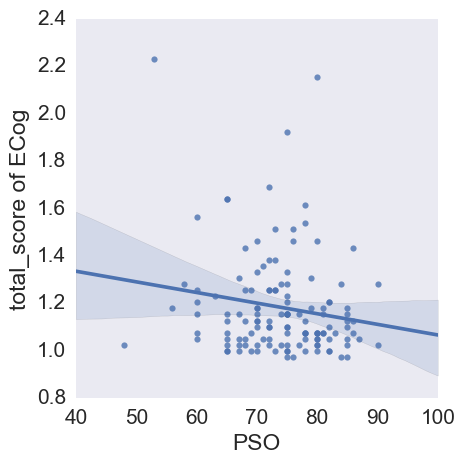

In [1716]:
plt.close()
sns.lmplot('PSO','total_score of ECog',data=scdf)
plt.show()

In [1720]:
stats.f_oneway(scdf[scdf.Worse_mem_coded==0]['PSO'],
               scdf[scdf.Worse_mem_coded==1]['PSO']
               ,scdf[scdf.Worse_mem_coded==2]['PSO'])

F_onewayResult(statistic=2.6604126483968908, pvalue=0.073846059616136689)

In [1730]:
#from statsmodels.stats.multicomp import pairwise_tukeyhsd
#from statsmodels.stats.libqsturng import psturng
res = pairwise_tukeyhsd(scdf.PSO, scdf.Worse_mem_coded)
print(res)
print(psturng(np.abs(res.meandiffs / res.std_pairs), len(res.groupsunique), res.df_total))

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
 0.0    1.0   -1.1261  -5.1748 2.9226 False 
 0.0    2.0   -3.8905  -7.8912 0.1102 False 
 1.0    2.0   -2.7644  -7.5387  2.01  False 
--------------------------------------------
[ 0.76742347  0.0585703   0.35890355]


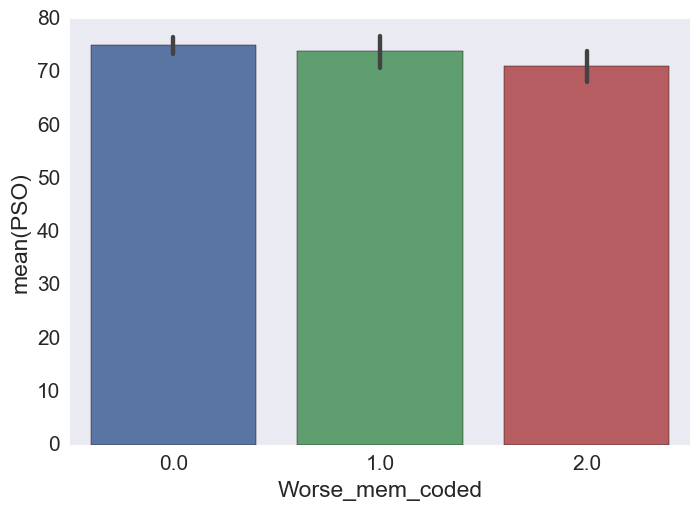

In [1718]:
plt.close()
sns.barplot(x='Worse_mem_coded', y='PSO', data=scdf)
plt.show()

In [1723]:
scdf.columns = ['ID', 'ECog', 'GAI', 'Worse_mem_coded', 'Age', 'tPSO', 'PSO']
smf.ols('PSO ~ ECog + GAI', data = scdf).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    PSO   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     1.921
Date:                Fri, 01 Dec 2017   Prob (F-statistic):              0.151
Time:                        17:10:00   Log-Likelihood:                -446.07
No. Observations:                 129   AIC:                             898.1
Df Residuals:                     126   BIC:                             906.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     80.3916      3.936     20.426      0.000      72.603      88.180
ECog          -5.2206      3.390     -1.540      0.126     -11.929       1.487
GAI           -0.0958      0.153     -0.624      0.533      -0.399       0.208
==============================================================================
Omnibus:                        4.325   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.115   Jarque-Bera (JB):                3.986
Skew:                          -0.428   Prob(JB):                        0.136
Kurtosis:                       3.100   Cond. No.                         43.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## REAL ANALYSIS IN ADNI! ...

In [132]:
xmm_weights = kmxoutput[1]
xmm_int = kmxoutput[-1]

In [133]:
adni_mm_s1 = pandas.DataFrame(preprocessing.StandardScaler().fit_transform(adni_mm),
                              index=adni_mm.index,columns = adni_mm.columns)
jnk = preprocessing.StandardScaler().fit(xmm_train[xmm_train.columns[:888]])
adni_xmm_s2 = pandas.DataFrame(jnk.transform(adni_mm), index=adni_mm.index, 
                                                      columns=adni_mm.columns)

In [134]:
adni_predicted_xmm = (xmm_weights[:888] * adni_mm).sum(axis=1) + xmm_int
adni_predicted_xmm_s1 = (xmm_weights[:888] * adni_mm_s1).sum(axis=1) + xmm_int
adni_predicted_xmm_s2 = (xmm_weights[:888] * adni_xmm_s2).sum(axis=1) + xmm_int

In [135]:
adni_bl['adni_predicted_xmm'] = adni_predicted_xmm
adni_bl['adni_predicted_xmm_s1'] = adni_predicted_xmm_s1
adni_bl['adni_predicted_xmm_s2'] = adni_predicted_xmm_s2

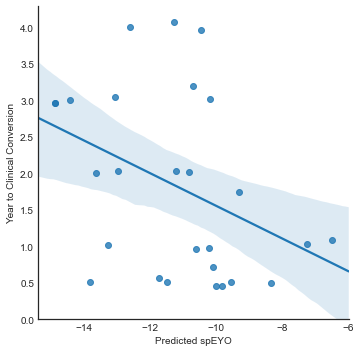

In [137]:
plt.close()
sns.set_style('white')
fig = sns.lmplot('adni_predicted_xmm_s1','conv_time2',data=adni_bl[adni_bl.converter==1])
plt.ylim(0,)
plt.xlabel('Predicted spEYO')
plt.ylabel('Year to Clinical Conversion')
#sns.plt.xticks([-4, 0, 4, 8])
#fig.savefig('/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/adni_conversion.pdf')
plt.show()

In [2561]:
r, p = stats.pearsonr(adni_bl[adni_bl.converter==1]['adni_predicted_xmm_s1'],
              adni_bl[adni_bl.converter==1]['conv_time2'])
print(r,p)
print('r square is',r**2)


-0.392221039684 0.0430208528685
r square is 0.15383734397


In [2565]:
adni_mm_cx = pandas.DataFrame(adni_mm_cov,copy=True).dropna()

In [130]:
adni_mm_cx = pandas.DataFrame(adni_mm_cov,copy=True).dropna()
xmm_train.drop(xmm_train.columns[888],axis=1,inplace=True)

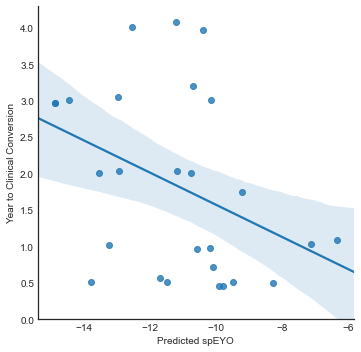

-0.391027297242 0.0437158146206
r square is 0.152902347189


In [146]:
adni_xmmc_s1 = pandas.DataFrame(preprocessing.StandardScaler().fit_transform(adni_mm_cx),
                              index=adni_mm_cx.index,columns = adni_mm_cx.columns)
jnk = preprocessing.StandardScaler().fit(xmm_train)
adni_xmmc_s2 = pandas.DataFrame(jnk.transform(adni_mm_cx), index=adni_mm_cx.index, 
                                                      columns=adni_mm_cx.columns)

adni_predicted_xmmc = (xmm_weights * adni_mm_cx).sum(axis=1) + xmm_int
adni_predicted_xmmc_s1 = (xmm_weights * adni_xmmc_s1).sum(axis=1) + xmm_int
adni_predicted_xmmc_s2 = (xmm_weights * adni_xmmc_s2).sum(axis=1) + xmm_int

adni_bl['adni_predicted_xmmc'] = adni_predicted_xmmc
adni_bl['adni_predicted_xmmc_s1'] = adni_predicted_xmmc_s1
adni_bl['adni_predicted_xmmc_s2'] = adni_predicted_xmmc_s2

plt.close()
sns.set_style('white')
fig = sns.lmplot('adni_predicted_xmmc_s1','conv_time2',data=adni_bl[adni_bl.converter==1])
plt.ylim(0,)
plt.xlabel('Predicted spEYO')
plt.ylabel('Year to Clinical Conversion')
#sns.plt.xticks([-4, 0, 4, 8])
#fig.savefig('/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/adni_conversion.pdf')
plt.show()

r, p = stats.pearsonr(adni_bl[adni_bl.converter==1]['adni_predicted_xmmc_s1'],
              adni_bl[adni_bl.converter==1]['conv_time2'])
print(r,p)
print('r square is',r**2)



In [2868]:
ci = 0.05
distr = []
for c in range(1000):
    rsamp = np.random.choice(adni_bl[adni_bl.converter==1].index, len(adni_bl[adni_bl.converter==1].index))
    distr.append(stats.pearsonr(adni_bl.loc[rsamp]['adni_predicted_xmmc_s1'], adni_bl.loc[rsamp]['conv_time2'])[0]**2)
nci = int(ci*1000)
ci_u = sorted(distr)[1000 - nci]
cim = np.mean(distr)
ci_l = sorted(distr)[(nci)]

In [2869]:
print(cim, ci_u, ci_l)

0.176399119958 0.360206706151 0.0244632652092


In [149]:
stats.pearsonr(adni_bl[adni_bl.converter==1]['adni_predicted_xmmc_s1'],
              adni_bl[adni_bl.converter==1]['AGE'])[0]**2

0.17751912399888792

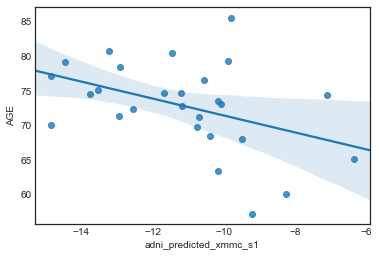

In [148]:
plt.close()
sns.regplot(adni_bl[adni_bl.converter==1]['adni_predicted_xmmc_s1'],
              adni_bl[adni_bl.converter==1]['AGE'])
plt.show()

In [2882]:
0.449**2

0.201601

In [2884]:
ci = 0.05
distr = []
for c in range(1000):
    rsamp = np.random.choice(adni_bl[adni_bl.converter==1].index, len(adni_bl[adni_bl.converter==1].index))
    distr.append(smf.ols('conv_time2 ~ AGE + adni_predicted_xmmc_s1',data=adni_bl.loc[rsamp]).fit().tvalues[-1])
nci = int(ci*1000)
ci_u = sorted(distr)[1000 - nci]
cim = np.mean(distr)
ci_l = sorted(distr)[(nci)]
print(ci_l,ci_u)

-4.32627693347 -1.17049425465


In [2885]:
print(0.2279**2)
print(0.6544**2)

0.05193841
0.42823935999999996


In [2753]:
jnk = adni_bl[adni_bl.converter==1]['adni_predicted_xmmc_s1']
zs = (jnk - jnk.mean()) / jnk.std()
adni_bl = adni_bl.reindex_axis(adni_bl.columns.tolist()+['z_pred'],axis=1)

In [2764]:
adni_bl.ix[adni_bl[adni_bl.converter==1].index,'z_pred'] = zs
#adni_bl.loc[adni_bl[adni_bl.converter==1].index]['z_pred'] = zs
adni_bl.loc[adni_bl[adni_bl.converter==1].index]['z_pred']

0729    2.191574
0778   -0.624699
2403   -1.491080
4042    0.889312
4094    1.317983
4188   -1.678509
4189    0.487984
4203    1.844135
4218   -0.932736
4250   -0.793281
4262   -0.000342
4270   -0.010580
4293    0.182902
4346   -0.809486
4363    0.462002
4415   -1.073048
4474    0.624767
4512    0.762442
4515   -0.230932
4521   -1.679204
4542    0.581023
4595    0.271687
4597    0.352853
4680    0.457722
4746    0.214186
4947   -1.179542
5096   -0.137132
Name: z_pred, dtype: float64

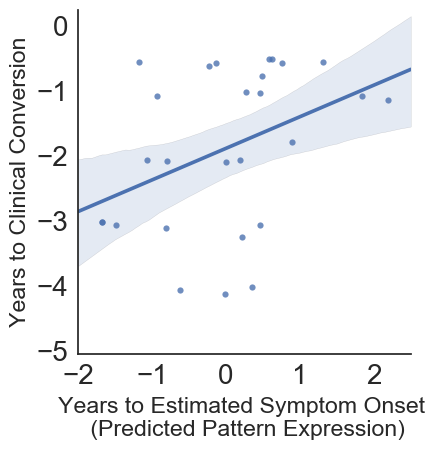

In [2783]:
plt.close()
sns.set_style('white')
sns.lmplot('z_pred','inverted_conv2',data=adni_bl[adni_bl.converter==1])
sns.plt.ylim(-5,0.3)
sns.plt.xlabel('Years to Estimated Symptom Onset \n (Predicted Pattern Expression)', fontsize='x-small')
sns.plt.ylabel('Years to Clinical Conversion', fontsize='x-small')
sns.plt.xticks([-2.0, -1.0, 0, 1.0, 2.0])
#fig.savefig('/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/tPSO_Manuscript/Prediction/Revisions/data/adni_conversion.pdf')
plt.show()





In [128]:
smf.ols('conv_time2 ~ AGE + adni_predicted_xmmc_s1', data=adni_bl[adni_bl.converter==1]
       ).fit().summary()

PatsyError: Error evaluating factor: NameError: name 'adni_predicted_xmmc_s1' is not defined
    conv_time2 ~ AGE + adni_predicted_xmmc_s1
                       ^^^^^^^^^^^^^^^^^^^^^^

In [150]:
distr = []
for i in range(10000):
    newx = np.random.permutation(adni_bl[adni_bl.converter==1
                                 ]['adni_predicted_xmmc_s1'])
    distr.append(stats.pearsonr(newx,adni_bl[adni_bl.converter==1
                                             ]['conv_time2'])[0])


In [158]:
orig_r, p = stats.pearsonr(adni_bl[adni_bl.converter==1]['adni_predicted_xmmc_s1'],
              adni_bl[adni_bl.converter==1]['inverted_conv2'])

In [162]:
jnk=np.array(distr)
(len(jnk[jnk>orig_r])/10001)

0.022497750224977502

In [2786]:
sorted(distr)[9500]

0.32134571305918092

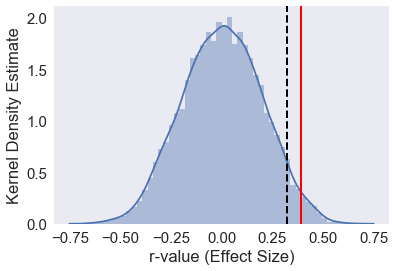

In [161]:
plt.close()
sns.set(font_scale=1.5)
sns.set_style('dark')
sns.distplot(np.array(distr))
plt.plot([orig_r, orig_r], [0, 2.5], 'r', linewidth=2)
plt.plot([sorted(distr)[9500], sorted(distr)[9500]], [0, 2.5], 'k--', linewidth=2)
#plt.plot([sorted(distr)[9750], sorted(distr)[9750]], [0, 2.5], 'b--', linewidth=2)
plt.xlabel('r-value (Effect Size)')
plt.ylabel('Kernel Density Estimate')
plt.show()

In [90]:
adni_mm_cx = pandas.DataFrame(adni_mm_cov,copy=True).dropna()
#xamm_train2.drop(xamm_train2.columns[888],axis=1,inplace=True)

In [63]:
xammc_weights = kmaxoutput[1]
xammc_int = kmaxoutput[-1]

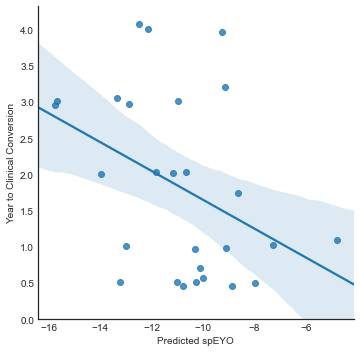

-0.396868969348 0.0403979994762
r square is 0.157504978831


In [93]:
adni_xammc_s1 = pandas.DataFrame(preprocessing.StandardScaler().fit_transform(adni_mm_cx),
                              index=adni_mm_cx.index,columns = adni_mm_cx.columns)
jnk = preprocessing.StandardScaler().fit(xamm_train2)
adni_xammc_s2 = pandas.DataFrame(jnk.transform(adni_mm_cx), index=adni_mm_cx.index, 
                                                      columns=adni_mm_cx.columns)

adni_predicted_xammc = (xammc_weights * adni_mm_cx).sum(axis=1) + xammc_int
adni_predicted_xammc_s1 = (xammc_weights * adni_xammc_s1).sum(axis=1) + xammc_int
adni_predicted_xammc_s2 = (xammc_weights * adni_xammc_s2).sum(axis=1) + xammc_int

adni_bl['adni_predicted_xammc'] = adni_predicted_xammc
adni_bl['adni_predicted_xammc_s1'] = adni_predicted_xammc_s1
adni_bl['adni_predicted_xammc_s2'] = adni_predicted_xammc_s2

plt.close()
sns.set_style('white')
fig = sns.lmplot('adni_predicted_xammc_s1','conv_time2',data=adni_bl[adni_bl.converter==1])
plt.ylim(0,)
plt.xlabel('Predicted spEYO')
plt.ylabel('Year to Clinical Conversion')
#sns.plt.xticks([-4, 0, 4, 8])
#fig.savefig('/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/adni_conversion.pdf')
plt.show()

r, p = stats.pearsonr(adni_bl[adni_bl.converter==1]['adni_predicted_xammc_s1'],
              adni_bl[adni_bl.converter==1]['conv_time2'])
print(r,p)
print('r square is',r**2)




In [97]:
distr = []
for i in range(10000):
    newx = np.random.permutation(adni_bl[adni_bl.converter==1
                                 ]['adni_predicted_xammc_s1'])
    distr.append(stats.pearsonr(newx,adni_bl[adni_bl.converter==1
                                             ]['conv_time2'])[0])
jnk=np.array(distr)
(len(jnk[jnk<r])/10001)

0.0197980201979802

In [98]:
ci = 0.05
distr = []
for c in range(1000):
    rsamp = np.random.choice(adni_bl[adni_bl.converter==1].index, len(adni_bl[adni_bl.converter==1].index))
    distr.append(smf.ols('conv_time2 ~ AGE + adni_predicted_xammc_s1',data=adni_bl.loc[rsamp]).fit().tvalues[-1])
nci = int(ci*1000)
ci_u = sorted(distr)[1000 - nci]
cim = np.mean(distr)
ci_l = sorted(distr)[(nci)]
print(ci_l,ci_u)

-4.1777584026 -1.25998574681


In [99]:
print(0.2443**2, 0.641**2)

0.05968249 0.410881


In [3086]:
axamm = pandas.DataFrame(adni_mm_cx, copy=True)
axamm.columns = ['col_%s'%x for x in axamm.columns[:-2]] + ['Age', 'Gender']
for col in axamm.columns[:-2]:
    mod = smf.ols('%s ~ Age + Gender'%col,data=axamm).fit()
    axamm.loc[:,col] = mod.resid.values


In [3088]:
axamm.drop(['Age','Gender',axamm.columns[443]], axis=1, inplace=True)
nxmm_train = xmm_train.drop(['Age','Gender',xmm_train.columns[443]], axis=1)

In [3089]:
xamm_weights = xamm_output[1]
xamm_int = xamm_output[-1]

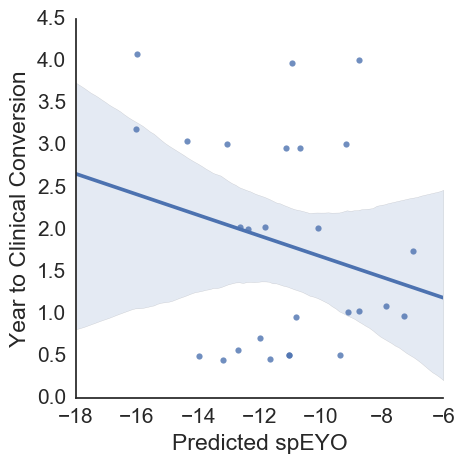

-0.234833284768 0.238371393832
r square is 0.0551466716349


In [3090]:
adni_xamm_s1 = pandas.DataFrame(preprocessing.StandardScaler().fit_transform(axamm),
                              index=axamm.index,columns = axamm.columns)
jnk = preprocessing.StandardScaler().fit(nxmm_train)
adni_xamm_s2 = pandas.DataFrame(jnk.transform(axamm), index=axamm.index, 
                                                      columns=axamm.columns)

adni_predicted_xamm = (np.array(xamm_weights[:-1]) * axamm).sum(axis=1) + xmm_int
adni_predicted_xamm_s1 = (np.array(xamm_weights[:-1]) * adni_xamm_s1).sum(axis=1) + xmm_int
adni_predicted_xamm_s2 = (np.array(xamm_weights[:-1]) * adni_xamm_s2).sum(axis=1) + xmm_int

adni_bl['adni_predicted_xamm'] = adni_predicted_xamm
adni_bl['adni_predicted_xamm_s1'] = adni_predicted_xamm_s1
adni_bl['adni_predicted_xamm_s2'] = adni_predicted_xamm_s2

plt.close()
sns.set_style('white')
fig = sns.lmplot('adni_predicted_xamm_s1','conv_time2',data=adni_bl[adni_bl.converter==1])
sns.plt.ylim(0,)
sns.plt.xlabel('Predicted spEYO')
sns.plt.ylabel('Year to Clinical Conversion')
#sns.plt.xticks([-4, 0, 4, 8])
#fig.savefig('/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/adni_conversion.pdf')
plt.show()

r, p = stats.pearsonr(adni_bl[adni_bl.converter==1]['adni_predicted_xamm_s1'],
              adni_bl[adni_bl.converter==1]['conv_time2'])
print(r,p)
print('r square is',r**2)




In [2641]:
tiv_weights = nixtiv_output[1]
tiv_int = nixtiv_output[-1]

In [2644]:
adni_tiv = pandas.DataFrame(adni_mm_cov,copy=True)
for col in ['Age','Gender']:
    adni_tiv.drop(col,axis=1,inplace=True)
adni_tiv.loc[:,'TIV'] = new_adni_cov.loc[adni_tiv.index].ICV.values
adni_tiv.dropna(inplace=True)

In [2650]:
adni_tiv.drop(adni_tiv.columns[887],axis=1,inplace=True)

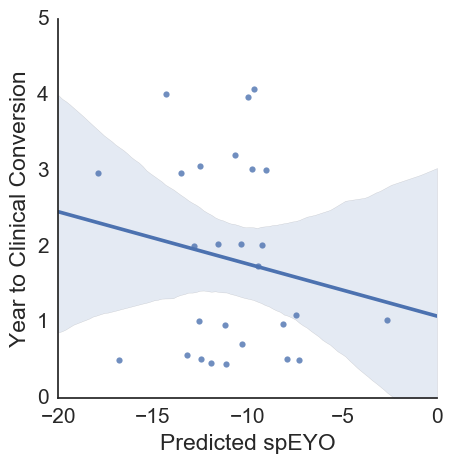

-0.169130955017 0.399035312324
r square is 0.0286052799451


In [2656]:
adni_tiv_s1 = pandas.DataFrame(preprocessing.StandardScaler().fit_transform(adni_tiv),
                              index=adni_tiv.index,columns = adni_tiv.columns)
jnk = preprocessing.StandardScaler().fit(nixtiv_train)
adni_tiv_s2 = pandas.DataFrame(jnk.transform(adni_tiv), index=adni_tiv.index, 
                                                      columns=adni_tiv.columns)

adni_predicted_tiv = (tiv_weights * adni_tiv).sum(axis=1) + tiv_int
adni_predicted_tiv_s1 = (tiv_weights * adni_tiv_s1).sum(axis=1) + tiv_int
adni_predicted_tiv_s2 = (tiv_weights * adni_tiv_s2).sum(axis=1) + tiv_int

adni_bl['adni_predicted_tiv'] = adni_predicted_tiv
adni_bl['adni_predicted_tiv_s1'] = adni_predicted_tiv_s1
adni_bl['adni_predicted_tiv_s2'] = adni_predicted_tiv_s2

plt.close()
sns.set_style('white')
fig = sns.lmplot('adni_predicted_tiv_s1','conv_time2',data=adni_bl[adni_bl.converter==1])
sns.plt.ylim(0,)
sns.plt.xlabel('Predicted spEYO')
sns.plt.ylabel('Year to Clinical Conversion')
#sns.plt.xticks([-4, 0, 4, 8])
#fig.savefig('/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/adni_conversion.pdf')
plt.show()

r, p = stats.pearsonr(adni_bl[adni_bl.converter==1]['adni_predicted_tiv_s1'],
              adni_bl[adni_bl.converter==1]['conv_time2'])
print(r,p)
print('r square is',r**2)




# REVISION IN ADNI

In [ ]:
## FIRST WITHOUT COVARIATES

In [1323]:
var_adni_train = pandas.DataFrame(super_train, copy=True)
var_adni_test = pandas.DataFrame(super_test, copy=True)

In [1324]:
for col in cog_cols + ['lhipp','rhipp']:
    var_adni_test.drop(col, axis=1, inplace=True)
    var_adni_train.drop(col, axis=1, inplace=True)

var_adni_train.loc[:,'hippocampus'] = ((super_train.lhipp + super_train.rhipp)/2).values
var_adni_test.loc[:,'hippocampus'] = ((super_test.lhipp + super_test.rhipp)/2).values

In [1325]:

var_adni_train.columns[-8:]

Index(['Age', 'Gender', 'Education', 'TIV', 'FD', 'ApoE4', 'MoCA',
       'hippocampus'],
      dtype='object')

In [2305]:
# First, run a model that can be actually used in ADNI
ldy = ld_05.loc[super_train.index].tPSO
ldt_y = ld_05.loc[super_test.index].tPSO
p_cutoff = 0.05
folds = 3
a_output = kfl.kfold_feature_learning(var_adni_train, var_adni_test, ldy, ldt_y, folds = folds,
                                    clf = linear_model.LassoCV(max_iter=10000, cv=10), 
                                    p_cutoff = p_cutoff, output='light', scale=True, 
                                    keep_cols = var_adni_train.columns[-8:])

running correlation for fold 1 of 3
running model for fold 1 of 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


running correlation for fold 2 of 3
running model for fold 2 of 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


running correlation for fold 3 of 3
running model for fold 3 of 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


66 features selected
validation prediction accuracy is 24.3387322364 percent 
 p = 9.06633689764e-10 
 r = -0.493343006806
testing prediction accuracy2 is 50.5639076864 percent 
 p = 2.13295134473e-22 
 r = 0.711083030921
testing prediction accuracy is 29.4452281123 percent 
 p = 2.09913607515e-06 
 r = 0.542634574205


In [2130]:
# Now get the CIs
ldy = ld_05.loc[super_train.index].tPSO
ldt_y = ld_05.loc[super_test.index].tPSO
p_cutoff = 0.05
folds = 3
adni_output = kfl.kfold_feature_learning(var_adni_train, var_adni_test, ldy, ldt_y, folds = folds,
                                    clf = linear_model.LassoCV(max_iter=10000, cv=10), 
                                    p_cutoff = p_cutoff, ci = 0.05, output='ci', scale=True, 
                                    keep_cols = var_adni_train.columns[-8:])

running correlation for fold 1 of 3
running model for fold 1 of 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


running correlation for fold 2 of 3
running model for fold 2 of 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


running correlation for fold 3 of 3
running model for fold 3 of 3


/Users/jakevogel/git/hack_projects/kfold_learning.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sig_mtx[col] = tmp_mtx.ix[:,col]


66 features selected
validation prediction accuracy is 24.3387322364 percent 
 p = 9.06633689764e-10 
 r = -0.493343006806
testing prediction accuracy2 is 50.5639076864 percent 
 p = 2.13295134473e-22 
 r = 0.711083030921
testing prediction accuracy is 29.4452281123 percent (0.132160591536, 0.450171910191, mean=0.293540149497) 
 p = 2.09913607515e-06 
 r = 0.542634574205


In [2145]:
new_adni_cov = pandas.DataFrame(adni_mm_cov,copy=True)


In [2147]:
big_adni = pandas.read_csv('/Users/jakevogel/Science/TADPOLE/TADPOLE_D1_D2.csv', na_values=' ')

//anaconda/envs/py3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1413,1656,1657,1659,1665,1666,1895,1902,1903,1904,1905) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2148]:
jk = ['%0.4d'%x for x in big_adni.RID.unique()]
missing = [x for x in adni_mm.index.tolist() if x not in jk]

In [2149]:
big_bl_ix = []
for rid in big_adni.RID.unique():
    ridf = big_adni[big_adni.RID==rid]
    bl_min = min(ridf.Years_bl.values)
    big_bl_ix.append(ridf[ridf.Years_bl==bl_min].index[0])

In [2150]:
big_bl = big_adni.loc[big_bl_ix]

In [2151]:
new_adni_cov['PTEDUCAT'] = adni_bl.loc[new_adni_cov.index].PTEDUCAT
new_adni_cov['ICV'] = adni_bl.loc[new_adni_cov.index].ICV
# FD is hard to come by, and its not selected anyway.
new_adni_cov['FD'] = np.zeros(new_adni_cov.shape[0])
new_adni_cov['APOE4'] = adni_bl.loc[new_adni_cov.index].APOE4
new_adni_cov['MOCA'] = adni_bl.loc[new_adni_cov.index].MOCA
new_adni_cov['Hippocampus'] = adni_bl.loc[new_adni_cov.index].Hippocampus


In [775]:
'%s'%int('0729')

'729'

In [2152]:
# View to see missing data...
new_adni_cov.loc[adni_bl[(adni_bl.converter_anal==1) & (adni_bl.converter==1)].index
                ][new_adni_cov.columns[-6:]]

PTEDUCAT          ICV   FD  APOE4  MOCA  Hippocampus
0729      16.0  1291136.475  0.0    1.0   NaN       6107.0
0778      13.0  1599889.879  0.0    1.0   NaN          NaN
2403      15.0  1539934.378  0.0    0.0  24.0       5943.0
4042      18.0  1386743.186  0.0    0.0  22.0       8449.0
4094      12.0  1174863.231  0.0    0.0  15.0       6935.0
4188      14.0  1739396.642  0.0    1.0  27.0       6696.0
4189      15.0  1534959.103  0.0    1.0  21.0       5960.0
4203      17.0  1466932.597  0.0    1.0  25.0       5715.0
4218      16.0  1697452.629  0.0    0.0  27.0       7573.0
4250      20.0  1835119.156  0.0    1.0  22.0       7668.0
4262      16.0  1552877.076  0.0    0.0  27.0       7135.0
4270      16.0  1501943.484  0.0    1.0  24.0       6604.0
4293      12.0  1590609.754  0.0    0.0  20.0       8545.0
4346      18.0  1808216.291  0.0    2.0  27.0       6021.0
4363      13.0  1490086.067  0.0    0.0  19.0       6796.0
4415      13.0  1276355.762  0.0    2.0  26.0       5883.0
4474      18.0  1761427.153  0.0    0.0  23.0       6951.0
4512      16.0  1403437.660  0.0    0.0  26.0       6981.0
4515      19.0  1910617.965  0.0    1.0  21.0       5522.0
4521      18.0  1602078.654  0.0    1.0  23.0       7027.0
4542      16.0  1276023.590  0.0    2.0  21.0       5549.0
4595      16.0  1699323.997  0.0    0.0  20.0       7433.0
4597      18.0  1465630.917  0.0    0.0  25.0       7535.0
4680      19.0  1280794.080  0.0    2.0  24.0       6436.0
4746      16.0  1603149.576  0.0    0.0  25.0          NaN
4947      14.0  1590457.891  0.0    1.0  24.0       6756.0
5096      20.0  1685620.570  0.0    1.0  24.0       7193.0

In [2153]:
cols = new_adni_cov.columns[-6:].tolist()
cols.remove('FD')
for rid,row in new_adni_cov.iterrows():
    arid = int(rid)
    if arid not in big_adni.RID.unique():
        print(rid,'not found.....')
    else:
        sdf = big_adni[big_adni.RID==arid][cols + ['Years_bl']]
        for col in new_adni_cov.columns[-6:]:
            if not pandas.notnull(row[col]):
                vals = sdf[pandas.notnull(sdf[col])].sort_values('Years_bl')[col]
                if len(vals) > 0:
                    new_adni_cov.ix[rid,col] = vals.values[0]

4726 not found.....
4727 not found.....
4731 not found.....
4761 not found.....
4836 not found.....
4848 not found.....
4932 not found.....
4956 not found.....
4993 not found.....
5074 not found.....
5163 not found.....


In [2154]:
# Check again...
new_adni_cov.loc[adni_bl[(adni_bl.converter_anal==1) & (adni_bl.converter==1)].index
                ][new_adni_cov.columns[-6:]]

PTEDUCAT          ICV   FD  APOE4  MOCA  Hippocampus
0729      16.0  1291136.475  0.0    1.0  20.0       6107.0
0778      13.0  1599889.879  0.0    1.0  25.0       7171.0
2403      15.0  1539934.378  0.0    0.0  24.0       5943.0
4042      18.0  1386743.186  0.0    0.0  22.0       8449.0
4094      12.0  1174863.231  0.0    0.0  15.0       6935.0
4188      14.0  1739396.642  0.0    1.0  27.0       6696.0
4189      15.0  1534959.103  0.0    1.0  21.0       5960.0
4203      17.0  1466932.597  0.0    1.0  25.0       5715.0
4218      16.0  1697452.629  0.0    0.0  27.0       7573.0
4250      20.0  1835119.156  0.0    1.0  22.0       7668.0
4262      16.0  1552877.076  0.0    0.0  27.0       7135.0
4270      16.0  1501943.484  0.0    1.0  24.0       6604.0
4293      12.0  1590609.754  0.0    0.0  20.0       8545.0
4346      18.0  1808216.291  0.0    2.0  27.0       6021.0
4363      13.0  1490086.067  0.0    0.0  19.0       6796.0
4415      13.0  1276355.762  0.0    2.0  26.0       5883.0
4474      18.0  1761427.153  0.0    0.0  23.0       6951.0
4512      16.0  1403437.660  0.0    0.0  26.0       6981.0
4515      19.0  1910617.965  0.0    1.0  21.0       5522.0
4521      18.0  1602078.654  0.0    1.0  23.0       7027.0
4542      16.0  1276023.590  0.0    2.0  21.0       5549.0
4595      16.0  1699323.997  0.0    0.0  20.0       7433.0
4597      18.0  1465630.917  0.0    0.0  25.0       7535.0
4680      19.0  1280794.080  0.0    2.0  24.0       6436.0
4746      16.0  1603149.576  0.0    0.0  25.0       7011.0
4947      14.0  1590457.891  0.0    1.0  24.0       6756.0
5096      20.0  1685620.570  0.0    1.0  24.0       7193.0

In [2158]:
print(new_adni_cov.shape)
print(new_adni_cov.dropna().shape)
new_adni_cov.dropna(inplace=True)

(148, 895)
(136, 895)


In [2159]:
len(var_adni_train.columns)

895

In [2160]:
new_adni_cov.columns[887]

'Age'

In [2163]:
cols = new_adni_cov.columns[:887].tolist() + new_adni_cov.columns[887:].tolist()
new_adni_cov = new_adni_cov[cols]

In [2615]:
#new_adni_cov

In [2165]:
new_adni_cov_s1 = pandas.DataFrame(preprocessing.StandardScaler().fit_transform(new_adni_cov),
                              index=new_adni_cov.index,columns = new_adni_cov.columns)
jnk = preprocessing.StandardScaler().fit(var_adni_train)
new_adni_cov_s2 = pandas.DataFrame(jnk.transform(new_adni_cov), index=new_adni_cov.index, 
                                                      columns=cols)

In [2166]:
new_weights = output[1]
new_int = output[-1]

In [2167]:
adni_predicted_new = (new_weights * new_adni_cov).sum(axis=1) + new_int
adni_predicted_new_s1 = (new_weights * new_adni_cov_s1).sum(axis=1) + new_int
adni_predicted_new_s2 = (new_weights * new_adni_cov_s2).sum(axis=1) + new_int

In [2168]:
adni_bl['adni_predicted_new'] = adni_predicted_new
adni_bl['adni_predicted_new_s1'] = adni_predicted_new_s1
adni_bl['adni_predicted_new_s2'] = adni_predicted_new_s2

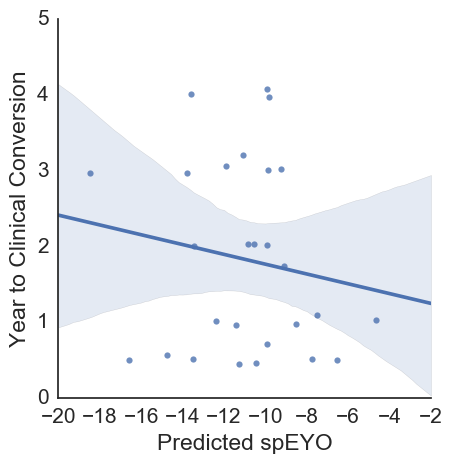

In [2169]:
plt.close()
sns.set_style('white')
fig = sns.lmplot('adni_predicted_new_s1','conv_time2',data=adni_bl[adni_bl.converter==1])
sns.plt.ylim(0,)
sns.plt.xlabel('Predicted spEYO')
sns.plt.ylabel('Year to Clinical Conversion')
#sns.plt.xticks([-4, 0, 4, 8])
#fig.savefig('/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/adni_conversion.pdf')
plt.show()

In [2745]:
new_adni_cov2 = pandas.DataFrame(new_adni_cov,copy=True)
#new_adni_cov2.loc[new_adni_cov.index,new_adni_cov2.columns[445:887]]

In [2750]:
# And with the fmri shift
new_adni_cov2 = pandas.DataFrame(new_adni_cov,copy=True)
new_adni_cov2.loc[new_adni_cov.index,new_adni_cov2.columns[445:887]] = new_adni_cov[
                                                        new_adni_cov.columns[444:886]
                                                                    ].values

In [2751]:
new_adni_cov2_s1 = pandas.DataFrame(preprocessing.StandardScaler().fit_transform(new_adni_cov2),
                              index=new_adni_cov2.index,columns = new_adni_cov2.columns)
jnk = preprocessing.StandardScaler().fit(var_adni_train)
new_adni_cov2_s2 = pandas.DataFrame(jnk.transform(new_adni_cov2), index=new_adni_cov2.index, 
                                                      columns=new_adni_cov.columns) # guessing here

adni_predicted_new2 = (new_weights * new_adni_cov2).sum(axis=1) + new_int
adni_predicted_new2_s1 = (new_weights * new_adni_cov2_s1).sum(axis=1) + new_int
adni_predicted_new2_s2 = (new_weights * new_adni_cov2_s2).sum(axis=1) + new_int

adni_bl['adni_predicted_new2'] = adni_predicted_new2
adni_bl['adni_predicted_new2_s1'] = adni_predicted_new2_s1
adni_bl['adni_predicted_new2_s2'] = adni_predicted_new2_s2

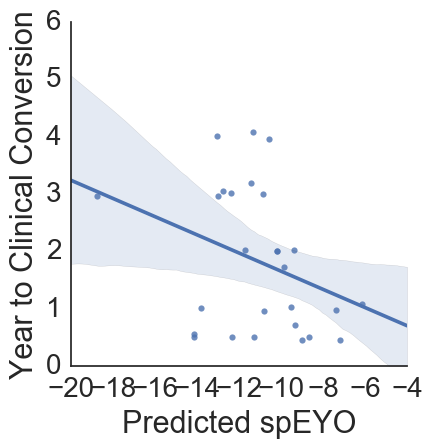

In [2752]:
plt.close()
sns.set_style('white')
fig = sns.lmplot('adni_predicted_new2_s1','conv_time2',data=adni_bl[adni_bl.converter==1])
sns.plt.ylim(0,)
sns.plt.xlabel('Predicted spEYO')
sns.plt.ylabel('Year to Clinical Conversion')
#sns.plt.xticks([-4, 0, 4, 8])
#fig.savefig('/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/adni_conversion.pdf')
plt.show()

In [2175]:
r, p = stats.pearsonr(adni_bl[adni_bl.converter==1]['adni_predicted_new2_s1'],
              adni_bl[adni_bl.converter==1]['conv_time2'])
print(r,p)
print('r square is',r**2)


-0.330382354943 0.0923511856249
r square is 0.109152500458


In [ ]:
### ONE MORE TIME WITH THE CORRECT FMRI DATA

In [2176]:
correct_ld = pandas.read_csv(
    '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/tPSO_Manuscript/Prediction/Revisions/data/adni/masked_link_density443_2')

In [1744]:
#correct_ld = pandas.read_csv(
#    '/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/tPSO_Manuscript/Prediction/Revisions/data/adni/zlink_density443_2')

In [2177]:
correct_ld.index = [x[-4:] for x in correct_ld[correct_ld.columns[0]]]

In [2178]:
correct_ld.drop(correct_ld.columns[0],axis=1,inplace=True)

In [2179]:
correct_ld = correct_ld.loc[new_adni_cov.index]

In [2180]:
new_adni_cov3 = pandas.DataFrame(new_adni_cov,copy=True)
new_adni_cov3.loc[new_adni_cov.index,new_adni_cov3.columns[445:887]] = correct_ld[
                                                        correct_ld.columns[0:442]
                                                                    ].values

In [2181]:
new_adni_cov3_s1 = pandas.DataFrame(preprocessing.StandardScaler().fit_transform(new_adni_cov3),
                              index=new_adni_cov3.index,columns = new_adni_cov3.columns)
jnk = preprocessing.StandardScaler().fit(var_adni_train)
new_adni_cov3_s2 = pandas.DataFrame(jnk.transform(new_adni_cov3), index=new_adni_cov3.index, 
                                                      columns=new_adni_cov3.columns)

adni_predicted_new3 = (new_weights * new_adni_cov3).sum(axis=1) + new_int
adni_predicted_new3_s1 = (new_weights * new_adni_cov3_s1).sum(axis=1) + new_int
adni_predicted_new3_s2 = (new_weights * new_adni_cov3_s2).sum(axis=1) + new_int

adni_bl['adni_predicted_new3'] = adni_predicted_new3
adni_bl['adni_predicted_new3_s1'] = adni_predicted_new3_s1
adni_bl['adni_predicted_new3_s2'] = adni_predicted_new3_s2

In [2182]:
adni_bl['conv_time2_inv'] = (adni_bl.conv_time2 * -1)

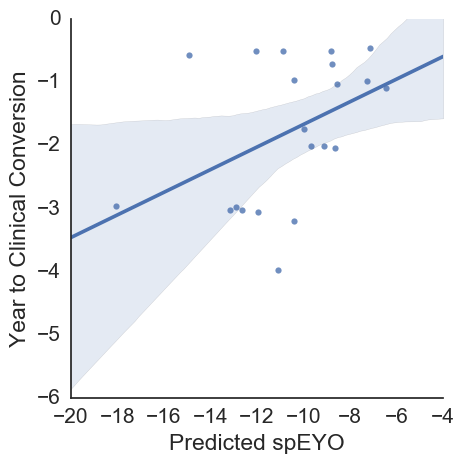

In [2183]:
plt.close()
sns.set_style('white')
fig = sns.lmplot('adni_predicted_new3_s1','conv_time2_inv',data=adni_bl[(adni_bl.converter==1) & (adni_bl.DX == 'MCI')])
sns.plt.ylim(-6,0)
sns.plt.xlabel('Predicted spEYO')
sns.plt.ylabel('Year to Clinical Conversion')
#sns.plt.xticks([-4, 0, 4, 8])
#fig.savefig('/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/adni_conversion.pdf')
plt.show()

In [2184]:
orig_r, orig_p = stats.pearsonr(adni_bl[adni_bl.converter==1]['adni_predicted_new3_s1'],
              adni_bl[adni_bl.converter==1]['conv_time2_inv'])
print(orig_r,orig_p)
print('r square is',orig_r**2)



0.361435110686 0.0639698644067
r square is 0.130635339237


In [1778]:
orig_r2, orig_p2 = stats.pearsonr(adni_bl[(adni_bl.converter==1) & (adni_bl.DX == 'MCI')]['adni_predicted_new3_s1'],
              adni_bl[(adni_bl.converter==1) & (adni_bl.DX == 'MCI')]['conv_time2_inv'])
print(orig_r2,orig_p2)
print('r square is',orig_r2**2)

0.433389524402 0.0496877133794
r square is 0.187826479861


In [2191]:
orig_r, orig_p = stats.pearsonr(adni_bl[adni_bl.converter==1]['adni_predicted_new3_s1'],
              adni_bl[adni_bl.converter==1]['conv_time2_inv'])
print(orig_r,orig_p)
print('r square is',orig_r**2)


0.361435110686 0.0639698644067
r square is 0.130635339237


In [2189]:
distr = []
for i in range(10000):
    newx = np.random.permutation(adni_bl[adni_bl.converter==1
                                 ]['adni_predicted_new3_s1'])
    distr.append(stats.pearsonr(newx,adni_bl[adni_bl.converter==1
                                             ]['conv_time2'])[0])


In [2192]:
jnk=np.array(distr)
(len(jnk[jnk>orig_r])/10001)

0.030396960303969604

In [1671]:
sorted(distr)[9500]

0.30858224350503272

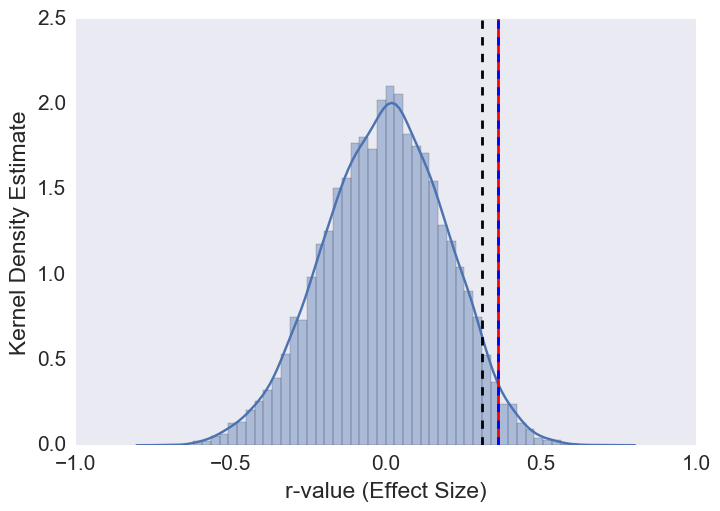

In [1675]:
plt.close()
sns.set(font_scale=1.5)
sns.set_style('dark')
sns.distplot(np.array(distr))
plt.plot([orig_r, orig_r], [0, 2.5], 'r', linewidth=2)
plt.plot([sorted(distr)[9500], sorted(distr)[9500]], [0, 2.5], 'k--', linewidth=2)
plt.plot([sorted(distr)[9750], sorted(distr)[9750]], [0, 2.5], 'b--', linewidth=2)
plt.xlabel('r-value (Effect Size)')
plt.ylabel('Kernel Density Estimate')
plt.show()

In [946]:
adni_bl.drop(adni_bl.columns[220],axis=1,inplace=True)

In [944]:
adni_bl.columns.tolist().index('z_pred')

220

In [947]:
adni_bl.columns[220]

'inverted_conv2'

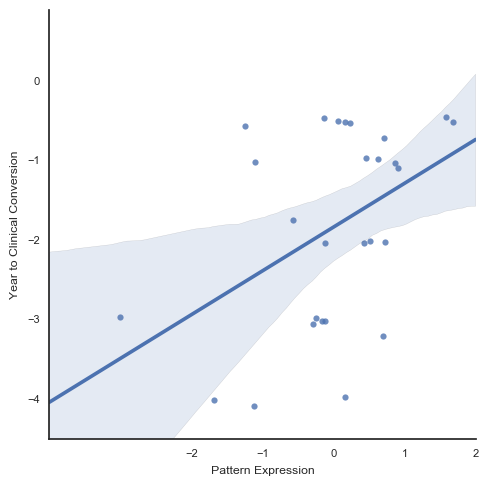

In [949]:
jnk = adni_bl[adni_bl.converter==1]['adni_predicted_new3_s1']
zs = (jnk - jnk.mean()) / jnk.std()
adni_bl = adni_bl.reindex_axis(adni_bl.columns.tolist()+['z_pred'],axis=1)

adni_bl.ix[adni_bl[adni_bl.converter==1].index,'z_pred'] = zs
#adni_bl.loc[adni_bl[adni_bl.converter==1].index]['z_pred'] = zs
#adni_bl.loc[adni_bl[adni_bl.converter==1].index]['z_pred']

adni_bl['inverted_conv2'] = adni_bl.conv_time2 * -1



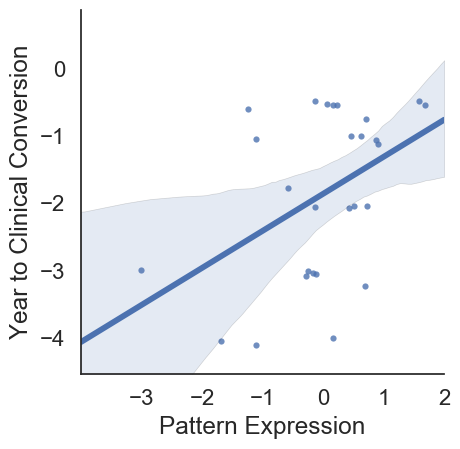

In [950]:
plt.close()
sns.set_style('white')
sns.set_context('poster')
fig = sns.lmplot('z_pred','inverted_conv2',data=adni_bl[adni_bl.converter==1])
sns.plt.ylim(-4.5,0.9)
sns.plt.xlabel('Pattern Expression')
sns.plt.ylabel('Year to Clinical Conversion')
sns.plt.xticks([-3.0, -2.0, -1.0, 0.0, 1.0,2.0])
#fig.savefig('/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/adni_pattern_expression.pdf')
plt.show()

## Now lets look at some other basic variables in relation to time to conversion in ADNI

In [ ]:
smf.ols('conv_time2 ~ TIV', data=new_adni)

In [1355]:
cols = new_adni_cov.columns[-8:].tolist()
cols.remove('FD')
for col in cols:
    slp, intr, rv, pv, se = stats.linregress(new_adni_cov.loc[adni_bl[adni_bl.converter==1].index][col],
                  adni_bl[adni_bl.converter==1]['conv_time2'])
    print(col)
    print('beta = %s (%s), r = %s, p = %s \n'%(slp, se, rv,pv))



Age
beta = -0.0119775915357 (0.0387358778962), r = -0.0617244459391, p = 0.759722796706 

Gender
beta = -0.144790179016 (0.487831882887), r = -0.0592563784121, p = 0.769068554903 

PTEDUCAT
beta = -0.0806969917762 (0.106067760405), r = -0.150429718983, p = 0.453889538049 

ICV
beta = 8.37855875899e-07 (1.30452188715e-06), r = 0.12740725441, p = 0.526544043643 

APOE4
beta = -0.0961595640897 (0.343134760295), r = -0.0559598705599, p = 0.781600421289 

MOCA
beta = 0.138631701852 (0.0803800487094), r = 0.326086145075, p = 0.0969255537145 

Hippocampus
beta = 0.000263300606828 (0.000307331715671), r = 0.168884943376, p = 0.399731600089 



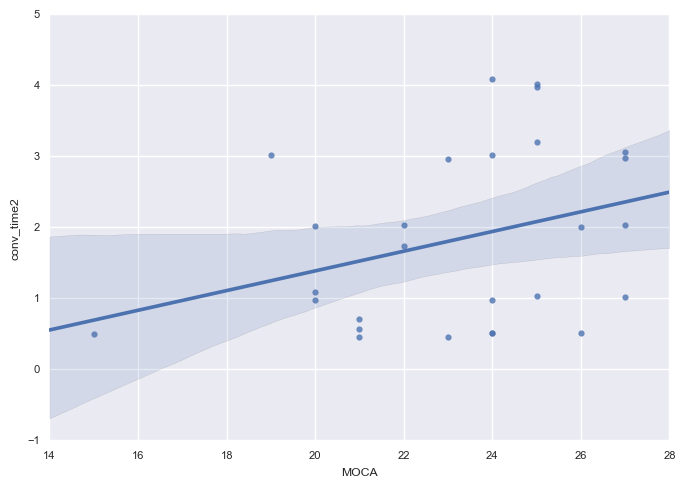

In [1466]:
plt.close()
sns.regplot(new_adni_cov.loc[adni_bl[adni_bl.converter==1].index]['MOCA'],
           adni_bl[adni_bl.converter==1]['conv_time2'])
plt.show()

In [1362]:
for col in ['Gender', 'APOE4']:
    tv, pv = stats.ttest_ind(adni_bl[(adni_bl.converter==1) & (new_adni_cov[col]==0)]['conv_time2'],
                            adni_bl[(adni_bl.converter==1) & (new_adni_cov[col]==1)]['conv_time2'])
    print(col)
    print('t = %s, p = %s \n'%(tv, pv))

Gender
t = 0.29680343597, p = 0.769068554903 

APOE4
t = 0.0151677034369, p = 0.988041568462 



In [1365]:
cols = ['Ventricles', 'AV45', 'FDG', 'MMSE']
for rid in new_adni_cov.index:
    arid = int(rid)
    if arid not in big_adni.RID.unique():
        print(rid,'not found.....')
    else:
        sdf = big_adni[big_adni.RID==arid][cols + ['Years_bl']]
        for col in cols:
            if not pandas.notnull(adni_bl.loc[rid, col]):
                vals = sdf[pandas.notnull(sdf[col])].sort_values('Years_bl')[col]
                if len(vals) > 0:
                    adni_bl.ix[rid,col] = vals.values[0]

NameError: name 'big_adni' is not defined

In [1366]:
cols = ['Ventricles', 'AV45', 'FDG', 'MMSE']
for col in cols:
    slp, intr, rv, pv, se = stats.linregress(adni_bl[adni_bl.converter==1][col],
                  adni_bl[adni_bl.converter==1]['conv_time2'])
    print(col)
    print('beta = %s (%s), r = %s, p = %s \n'%(slp, se, rv,pv))


Ventricles
beta = -1.24483317718e-05 (1.20768263992e-05), r = -0.201906613764, p = 0.312522077388 

AV45
beta = 2.0860905508 (1.13179166214), r = 0.34588216993, p = 0.0771913051092 

FDG
beta = 3.87178827884 (1.86324831427), r = 0.383772419847, p = 0.0481327763922 

MMSE
beta = 0.265947309065 (0.159935480606), r = 0.315574295801, p = 0.108832795676 



# Identify missing PAD subjects

In [1134]:
cog_cols

['immediate_memory_index_score',
 'visuospatial_constructional_index_score',
 'lang',
 'attention_index_score',
 'delayed_memory_index_score']

In [1123]:
# Education
[x for x in ld_05.index if not pandas.notnull(pad.loc[x,'@4_education'])]

['MTL0317', 'MTL0397', 'MTL0414', 'MTL0401']

In [1126]:
# tiv
[x for x in ld_05.index if not pandas.notnull(pad.loc[x,'total_s'])]

['MTL0317', 'MTL0397', 'MTL0414', 'MTL0401']

In [1129]:
# cog 
[x for x in ld_05.index if not pandas.notnull(pad.loc[x,cog_cols[0]])]

['MTL0449',
 'MTL0317',
 'MTL0407',
 'MTL0405',
 'MTL0384',
 'MTL0381',
 'MTL0397',
 'MTL0423',
 'MTL0436',
 'MTL0443',
 'MTL0442',
 'MTL0427',
 'MTL0414',
 'MTL0448',
 'MTL0447',
 'MTL0223',
 'MTL0450',
 'MTL0401']

In [1130]:
# hippocampus
[x for x in ld_05.index if not pandas.notnull(pad.loc[x,'LeftHippocampus'])]

['MTL0008',
 'MTL0449',
 'MTL0381',
 'MTL0436',
 'MTL0443',
 'MTL0427',
 'MTL0448',
 'MTL0347',
 'MTL0447',
 'MTL0223',
 'MTL0450']

In [1132]:
# ApoE
[x for x in ld_05.index if not pandas.notnull(ld_05.loc[x,'ApoE4_status'])]

[]

In [1131]:
# scd
ld_05.index.tolist()

['MTL0392',
 'MTL0415',
 'MTL0380',
 'MTL0008',
 'MTL0449',
 'MTL0074',
 'MTL0140',
 'MTL0254',
 'MTL0279',
 'MTL0263',
 'MTL0013',
 'MTL0317',
 'MTL0244',
 'MTL0327',
 'MTL0385',
 'MTL0353',
 'MTL0407',
 'MTL0333',
 'MTL0412',
 'MTL0150',
 'MTL0194',
 'MTL0092',
 'MTL0393',
 'MTL0104',
 'MTL0101',
 'MTL0249',
 'MTL0405',
 'MTL0201',
 'MTL0069',
 'MTL0102',
 'MTL0064',
 'MTL0039',
 'MTL0094',
 'MTL0403',
 'MTL0384',
 'MTL0261',
 'MTL0283',
 'MTL0326',
 'MTL0204',
 'MTL0199',
 'MTL0409',
 'MTL0246',
 'MTL0161',
 'MTL0381',
 'MTL0172',
 'MTL0026',
 'MTL0196',
 'MTL0300',
 'MTL0397',
 'MTL0179',
 'MTL0234',
 'MTL0240',
 'MTL0187',
 'MTL0345',
 'MTL0282',
 'MTL0012',
 'MTL0298',
 'MTL0382',
 'MTL0040',
 'MTL0386',
 'MTL0124',
 'MTL0097',
 'MTL0371',
 'MTL0339',
 'MTL0225',
 'MTL0373',
 'MTL0184',
 'MTL0297',
 'MTL0423',
 'MTL0037',
 'MTL0181',
 'MTL0250',
 'MTL0085',
 'MTL0274',
 'MTL0005',
 'MTL0292',
 'MTL0285',
 'MTL0436',
 'MTL0080',
 'MTL0443',
 'MTL0287',
 'MTL0334',
 'MTL0293',
 'MT

## LD missing feature experiment

In [2241]:
ldjnk = linear_model.LassoLarsCV(cv=10).fit(super_train[super_train.columns[445:886]], ldy)
print('lasso lars:', ldjnk.score(super_test[super_test.columns[445:886]], ldt_y))
ldjnk = linear_model.ElasticNetCV(cv=10).fit(super_train[super_train.columns[445:886]], ldy)
print('Elastic Net:', ldjnk.score(super_test[super_test.columns[445:886]], ldt_y))
ldjnk = linear_model.LassoCV(cv=10).fit(super_train[super_train.columns[445:886]], ldy)
print('Lasso:',ldjnk.score(super_test[super_test.columns[445:886]], ldt_y))
ldjnk = linear_model.RidgeClassifierCV(cv=10).fit(super_train[super_train.columns[445:886]], ldy)
print('Ridge:',ldjnk.score(super_test[super_test.columns[445:886]], ldt_y))

lasso lars: 0.372939244947
Elastic Net: 0.386673721128
Lasso: 0.373897568139
Ridge: 0.0597014925373


In [2279]:
ldy = super_train[super_train.columns[444]]
ldt_y = super_test[super_test.columns[444]]
p_cutoff = None
folds = 2
clf = linear_model.ElasticNetCV(cv=10)
missing_ld = kfl.kfold_feature_learning(super_train[super_train.columns[445:886]], 
                                    super_test[super_test.columns[445:886]], 
                                    ldy, ldt_y, clf = clf, folds = folds, shuffle_k = True,
                                    p_cutoff = p_cutoff, output='light', scale=False)


running model for fold 1 of 2
running model for fold 2 of 2
32 features selected
validation prediction accuracy is 49.8702337825 percent 
 p = 5.50016320593e-22 
 r = 0.706188599331
testing prediction accuracy2 is 69.7580474858 percent 
 p = 7.14449180342e-37 
 r = 0.835212832072
testing prediction accuracy is 41.2879481326 percent 
 p = 4.57879326003e-09 
 r = 0.642556986831


In [2259]:
#new_adni_cov3[new_adni_cov3.columns[444:447]]

In [2293]:
new_adni_cov4 = pandas.DataFrame(new_adni_cov3,copy=True)
ntest = check_array(new_adni_cov3[new_adni_cov3.columns[445:886]],accept_sparse='csr')
nld_predicted = pandas.Series(safe_sparse_dot(ntest,np.array(missing_ld[1]),dense_output=True
                                             ),index=new_adni_cov3.index) + missing_ld[-1]
new_adni_cov4.loc[:,new_adni_cov.columns[444]] = nld_predicted

new_adni_cov4_s1 = pandas.DataFrame(preprocessing.StandardScaler().fit_transform(new_adni_cov4),
                              index=new_adni_cov4.index,columns = new_adni_cov4.columns)

jnk = preprocessing.StandardScaler().fit(var_adni_train)
new_adni_cov4_s2 = pandas.DataFrame(jnk.transform(new_adni_cov4), index=new_adni_cov4.index, 
                                                      columns=new_adni_cov4.columns)



In [2308]:
a_output[1][abs(a_output[1])>0]

18    -0.242562
45    -0.043019
69    -0.089037
75    -0.072390
96    -0.307642
131   -0.078892
137   -0.026638
142   -0.438499
226   -0.021662
242   -0.432135
249   -0.014046
292   -0.081270
294   -0.092119
321   -0.259906
330   -0.288531
348   -0.019584
376   -0.131778
390   -0.180039
477   -0.058280
508    0.184651
512   -0.207570
520   -0.162724
525   -0.008580
529    0.295646
531    0.109137
538    0.446292
549    0.042314
582   -0.315228
588   -0.140092
600   -0.055250
         ...   
655    0.253208
664    0.165095
665    0.177744
668   -0.508477
691    0.527967
693   -0.309965
726   -0.491988
745    0.064544
748    0.034211
771    0.014664
776   -0.147751
777   -0.002776
795    0.348682
802    0.045352
811    0.161434
820    0.319691
838   -0.304719
845   -0.036563
848    0.336659
855   -0.210285
867    0.129185
879   -0.616094
880    0.030771
887    0.548318
888    0.051094
889    0.216750
890    0.793572
891    0.032812
892    0.555296
893   -0.024837
dtype: float64

In [2294]:
adni_predicted_new4 = (new_weights * new_adni_cov4).sum(axis=1) + new_int
adni_predicted_new4_s1 = (new_weights * new_adni_cov4_s1).sum(axis=1) + new_int
adni_predicted_new4_s2 = (new_weights * new_adni_cov4_s2).sum(axis=1) + new_int

adni_bl['adni_predicted_new4'] = adni_predicted_new4
adni_bl['adni_predicted_new4_s1'] = adni_predicted_new4_s1
adni_bl['adni_predicted_new4_s2'] = adni_predicted_new4_s2

In [2310]:
adni_bl.columns[-30:]

Index(['ADNI_EF', 'DX.conv', 'DX.final', 'adni_predicted_kmm',
       'adni_predicted_kmm_s1', 'adni_predicted_kmm_s2', 'adni_predicted_kamm',
       'adni_predicted_kamm_s1', 'adni_predicted_kamm_s2',
       'adni_predicted_kmmp', 'adni_predicted_kmmp_s1',
       'adni_predicted_kmmp_s2', 'converter_anal', 'converter', 'conv_time2',
       'inverted_conv2', 'adni_predicted_new', 'adni_predicted_new_s1',
       'adni_predicted_new_s2', 'adni_predicted_new2',
       'adni_predicted_new2_s1', 'adni_predicted_new2_s2',
       'adni_predicted_new3', 'adni_predicted_new3_s1',
       'adni_predicted_new3_s2', 'z_pred', 'conv_time2_inv',
       'adni_predicted_new4', 'adni_predicted_new4_s1',
       'adni_predicted_new4_s2'],
      dtype='object')

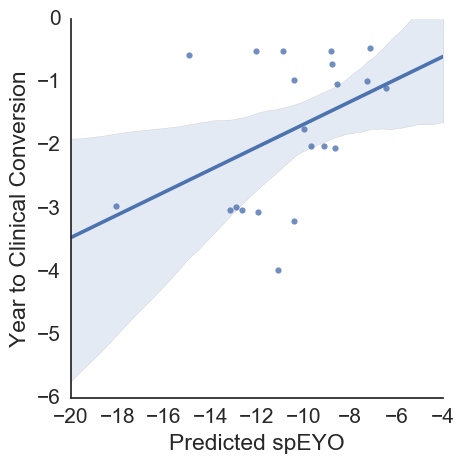

In [2295]:
plt.close()
sns.set_style('white')
fig = sns.lmplot('adni_predicted_new4_s1','conv_time2_inv',data=adni_bl[(adni_bl.converter==1) & (adni_bl.DX == 'MCI')])
sns.plt.ylim(-6,0)
sns.plt.xlabel('Predicted spEYO')
sns.plt.ylabel('Year to Clinical Conversion')
#sns.plt.xticks([-4, 0, 4, 8])
#fig.savefig('/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/adni_conversion.pdf')
plt.show()

In [2312]:
orig_r, orig_p = stats.pearsonr(adni_bl[adni_bl.converter==1]['adni_predicted_kmm_s1'],
              adni_bl[adni_bl.converter==1]['conv_time2_inv'])
print(orig_r,orig_p)
print('r square is',orig_r**2)



0.404886838089 0.0361737149286
r square is 0.163933351658


In [2494]:
tstld = pandas.read_csv('/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/tPSO_Manuscript/Prediction/Revisions/data/proper_ld_444_2',
                       index_col = 0)
tstld.index = [str(x[7:]) for x in tstld.index]

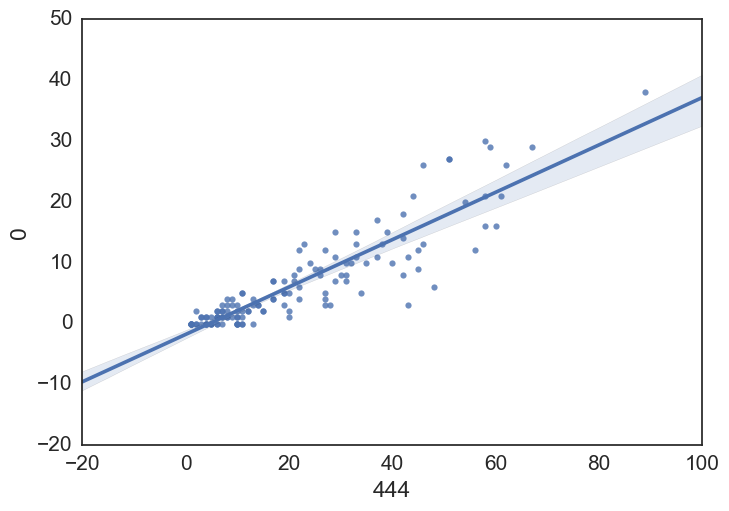

In [2495]:
plt.close()
sns.regplot(new_adni_cov[new_adni_cov.columns[444]],tstld.loc[new_adni_cov4.index][tstld.columns[0]])
plt.show()


In [2496]:
rs = []
for i in range(444):
    rs.append(stats.pearsonr(new_adni_cov[new_adni_cov.columns[444+i]], 
                        tstld.loc[new_adni_cov4.index][tstld.columns[i]])[0])

In [2490]:
type(rs)

list

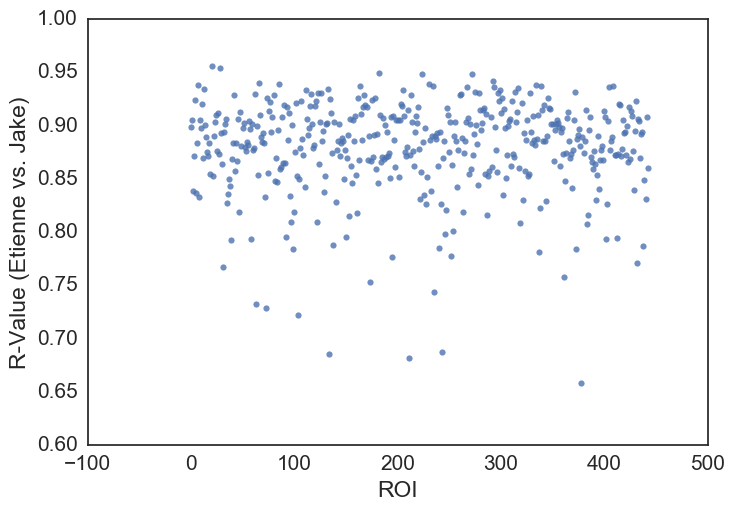

In [2497]:
plt.close()
sns.regplot(np.arange(443),np.array(rs[:-1]), fit_reg=False)
plt.ylabel('R-Value (Etienne vs. Jake)')
plt.xlabel('ROI')
plt.show()

In [2371]:
#new_adni_cov[new_adni_cov.columns[445]]

In [2498]:
new_adni_cov5.loc[new_adni_cov.index,new_adni_cov4.columns[444:887]].shape

(136, 443)

In [2507]:
new_adni_cov5 = pandas.DataFrame(new_adni_cov4,copy=True)
new_adni_cov5.loc[new_adni_cov4.index,new_adni_cov4.columns[444:887]] = tstld.loc[new_adni_cov4.index,
                                                                                 tstld.columns[:-1]].values

In [2508]:
new_adni_cov5_s1 = pandas.DataFrame(preprocessing.StandardScaler().fit_transform(new_adni_cov5),
                              index=new_adni_cov5.index,columns = new_adni_cov5.columns)
jnk = preprocessing.StandardScaler().fit(var_adni_train)
new_adni_cov5_s2 = pandas.DataFrame(jnk.transform(new_adni_cov5), index=new_adni_cov5.index, 
                                                      columns=new_adni_cov.columns) # guessing here

adni_predicted_new5 = (new_weights * new_adni_cov5).sum(axis=1) + new_int
adni_predicted_new5_s1 = (new_weights * new_adni_cov5_s1).sum(axis=1) + new_int
adni_predicted_new5_s2 = (new_weights * new_adni_cov5_s2).sum(axis=1) + new_int

adni_bl['adni_predicted_new5'] = adni_predicted_new5
adni_bl['adni_predicted_new5_s1'] = adni_predicted_new5_s1
adni_bl['adni_predicted_new5_s2'] = adni_predicted_new5_s2

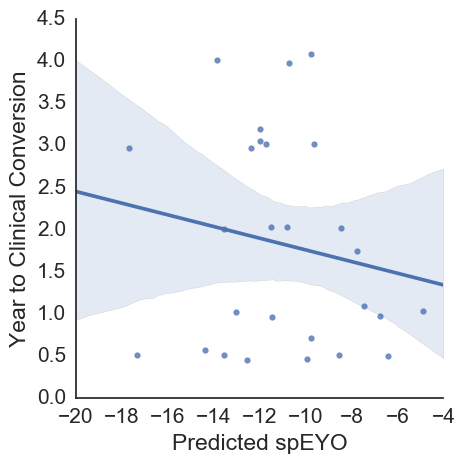

In [2513]:
plt.close()
sns.set_style('white')
fig = sns.lmplot('adni_predicted_new5_s1','conv_time2',data=adni_bl[adni_bl.converter==1])
sns.plt.ylim(0,)
sns.plt.xlabel('Predicted spEYO')
sns.plt.ylabel('Year to Clinical Conversion')
#sns.plt.xticks([-4, 0, 4, 8])
#fig.savefig('/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/adni_conversion.pdf')
plt.show()

In [2510]:
r, p = stats.pearsonr(adni_bl[adni_bl.converter==1]['adni_predicted_new5_s1'],
              adni_bl[adni_bl.converter==1]['conv_time2'])
print(r,p)
print('r square is',r**2)


-0.171530495729 0.392279897206
r square is 0.0294227109652


In [2464]:
adni_predicted_new6 = (ni_weights * new_adni_cov2[new_adni_cov.columns[:887]]).sum(axis=1) + new_int
adni_predicted_new6_s1 = (ni_weights * new_adni_cov2_s1[new_adni_cov.columns[:887]]).sum(axis=1) + new_int
adni_predicted_new6_s2 = (ni_weights * new_adni_cov2_s2[new_adni_cov.columns[:887]]).sum(axis=1) + new_int
adni_bl['adni_predicted_new6'] = adni_predicted_new6
adni_bl['adni_predicted_new6_s1'] = adni_predicted_new6_s1
adni_bl['adni_predicted_new6_s2'] = adni_predicted_new6_s2

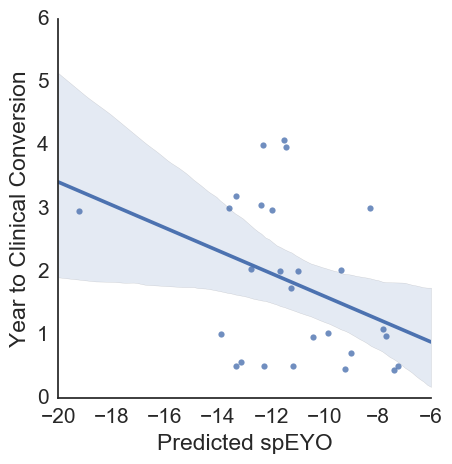

In [2465]:
plt.close()
sns.set_style('white')
fig = sns.lmplot('adni_predicted_new6_s1','conv_time2',data=adni_bl[adni_bl.converter==1])
sns.plt.ylim(0,)
sns.plt.xlabel('Predicted spEYO')
sns.plt.ylabel('Year to Clinical Conversion')
#sns.plt.xticks([-4, 0, 4, 8])
#fig.savefig('/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/adni_conversion.pdf')
plt.show()

In [2468]:
r, p = stats.pearsonr(adni_bl[adni_bl.converter==1]['adni_predicted_new6_s1'],
              adni_bl[adni_bl.converter==1]['conv_time2'])
print(r,p)
print('r square is',r**2, r)



-0.375923324833 0.0532999448603
r square is 0.141318346153 -0.375923324833


In [ ]:
## AFTER SOLVING WEIGHT DILEMMA

In [2612]:
nix_weights = nix_output[1]
nix_int = nix_output[-1]

In [2621]:
new_adni_cx = pandas.DataFrame(new_adni_cov,copy=True)
new_adni_cx.drop(new_adni_cx.columns[-6:],axis=1,inplace=True)

In [2624]:
nxmm_train = pandas.DataFrame(xmm_train,copy=True)
nxmm_train.drop(nxmm_train.columns[887],axis=1,inplace=True)

In [2626]:
nix_weights[abs(nix_weights)>0]

18    -0.202263
31    -0.112941
45    -0.014770
75    -0.096338
96    -0.115200
131   -0.091329
142   -0.239853
226   -0.092700
242   -0.405805
294   -0.145927
321   -0.146194
330   -0.223493
348   -0.057587
351   -0.008869
390   -0.171075
458    0.209364
477   -0.091916
512   -0.223405
520   -0.077061
525    0.085425
529    0.278855
538    0.362747
549    0.058855
574    0.120828
582   -0.168879
588   -0.107312
590    0.029471
600   -0.209009
645    0.142013
650   -0.158286
651    0.056578
652   -0.147130
653    0.039294
655    0.322066
665    0.122732
668   -0.496536
677   -0.067991
691    0.800540
693   -0.529333
726   -0.368041
745    0.092685
748    0.097682
771    0.005429
795    0.247326
802    0.062443
811    0.270632
816   -0.112048
820    0.413123
834   -0.113359
838   -0.388860
843    0.230962
845   -0.096724
848    0.440773
855   -0.251483
864    0.434428
867    0.030209
879   -0.260450
887    0.828054
dtype: float64

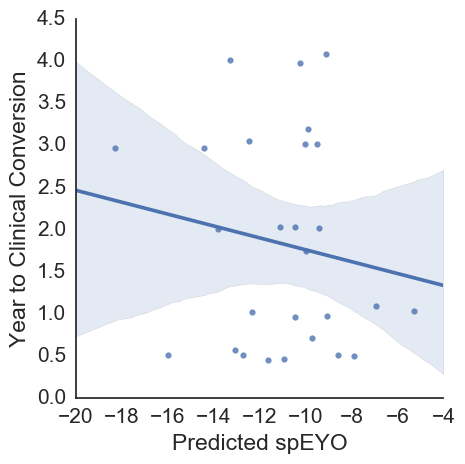

-0.156458486916 0.435784918273
r square is 0.024479258128


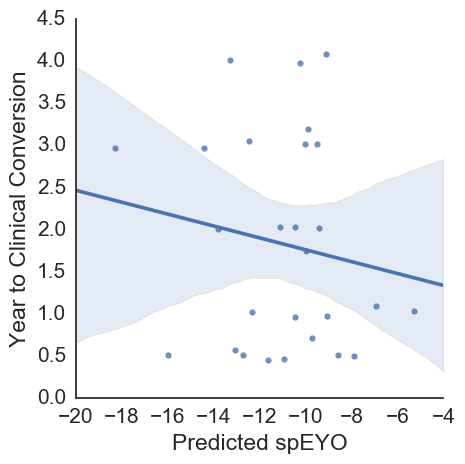

-0.156458486916 0.435784918273
r square is 0.024479258128


In [2625]:
new_adni_cx_s1 = pandas.DataFrame(preprocessing.StandardScaler().fit_transform(new_adni_cx),
                              index=new_adni_cx.index,columns = new_adni_cx.columns)
jnk = preprocessing.StandardScaler().fit(nxmm_train)
new_adni_cx_s2 = pandas.DataFrame(jnk.transform(new_adni_cx), index=new_adni_cx.index, 
                                                      columns=new_adni_cx.columns)

new_adni_predicted_xmmc = (nix_weights * new_adni_cx).sum(axis=1) + nix_int
new_adni_predicted_xmmc_s1 = (nix_weights * new_adni_cx_s1).sum(axis=1) + nix_int
new_adni_predicted_xmmc_s2 = (nix_weights * new_adni_cx_s2).sum(axis=1) + nix_int

new_adni_predicted_xmm = (nix_weights[:888] * new_adni_cx[new_adni_cx.columns[:888]]).sum(axis=1) + nix_int
new_adni_predicted_xmm_s1 = (nix_weights[:888] * new_adni_cx_s1[new_adni_cx.columns[:888]]).sum(axis=1) + nix_int
new_adni_predicted_xmm_s2 = (nix_weights[:888] * new_adni_cx_s2[new_adni_cx.columns[:888]]).sum(axis=1) + nix_int

adni_bl['new_adni_predicted_xmmc'] = new_adni_predicted_xmmc
adni_bl['new_adni_predicted_xmmc_s1'] = new_adni_predicted_xmmc_s1
adni_bl['new_adni_predicted_xmmc_s2'] = new_adni_predicted_xmmc_s2

adni_bl['new_adni_predicted_xmm'] = new_adni_predicted_xmm
adni_bl['new_adni_predicted_xmm_s1'] = new_adni_predicted_xmm_s1
adni_bl['new_adni_predicted_xmm_s2'] = new_adni_predicted_xmm_s2

plt.close()
sns.set_style('white')
fig = sns.lmplot('new_adni_predicted_xmmc_s1','conv_time2',data=adni_bl[adni_bl.converter==1])
sns.plt.ylim(0,)
sns.plt.xlabel('Predicted spEYO')
sns.plt.ylabel('Year to Clinical Conversion')
#sns.plt.xticks([-4, 0, 4, 8])
#fig.savefig('/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/adni_conversion.pdf')
plt.show()

r, p = stats.pearsonr(adni_bl[adni_bl.converter==1]['new_adni_predicted_xmmc_s1'],
              adni_bl[adni_bl.converter==1]['conv_time2'])
print(r,p)
print('r square is',r**2)

plt.close()
sns.set_style('white')
fig = sns.lmplot('new_adni_predicted_xmm_s1','conv_time2',data=adni_bl[adni_bl.converter==1])
sns.plt.ylim(0,)
sns.plt.xlabel('Predicted spEYO')
sns.plt.ylabel('Year to Clinical Conversion')
#sns.plt.xticks([-4, 0, 4, 8])
#fig.savefig('/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/feature_selection/adni_conversion.pdf')
plt.show()

r, p = stats.pearsonr(adni_bl[adni_bl.converter==1]['new_adni_predicted_xmm_s1'],
              adni_bl[adni_bl.converter==1]['conv_time2'])
print(r,p)
print('r square is',r**2)

## Find converter subjects with only MRI...

In [882]:
converter_rids = []
con_labs = ['NL to MCI','MCI to Dementia', 'NL to Dementia']
for rid in big_adni.RID.unique():
    sdf = big_adni[big_adni.RID==rid]['DX']
    if any([x for x in sdf.values if x in con_labs]):
        converter_rids.append(rid)

In [890]:
conv_ridd = pandas.DataFrame(['%0.4d'%x for x in converter_rids],columns=['RID'])

In [891]:
conv_ridd.to_csv('/Users/jakevogel/Dropbox/Work/Projects/StoP_AD/tPSO_Manuscript/Prediction/Revisions/data/converter_ids.csv')

In [875]:
con_labs = ['NL to MCI','MCI to Dementia', 'NL to Dementia']


KeyError: False

In [983]:
big_adni.columns

Index(['RID', 'PTID', 'VISCODE', 'SITE', 'D1', 'D2', 'COLPROT', 'ORIGPROT',
       'EXAMDATE', 'DX_bl',
       ...
       'PHASE_UPENNBIOMK9_04_19_17', 'BATCH_UPENNBIOMK9_04_19_17',
       'KIT_UPENNBIOMK9_04_19_17', 'STDS_UPENNBIOMK9_04_19_17',
       'RUNDATE_UPENNBIOMK9_04_19_17', 'ABETA_UPENNBIOMK9_04_19_17',
       'TAU_UPENNBIOMK9_04_19_17', 'PTAU_UPENNBIOMK9_04_19_17',
       'COMMENT_UPENNBIOMK9_04_19_17', 'update_stamp_UPENNBIOMK9_04_19_17'],
      dtype='object', length=1907)

In [1001]:
dd = pandas.read_csv('/Users/jakevogel/Science/TADPOLE/TADPOLE_D1_D2_Dict.csv', na_values=' ')

In [1061]:
dd.loc[1400]

ID                                                          NaN
FLDNAME         RIGHT_INF_LAT_VENT_SIZE_UCBERKELEYAV45_10_17_16
TBLNAME                                          UCBERKELEYAV45
CRFNAME                             UC Berkeley - AV45 analysis
QUESTION                                                     -4
TEXT                        right-inf-lat-vent ROI size in mm^3
STATUS                                                       -4
DEPRULE                                                      -4
TYPE                                                          N
LENGTH                                                      NaN
DECIML                                                        0
RANGEVAL                                                     -4
RANGESQL                                                     -4
RANGEPRL                                                     -4
UNITS                                                      mm^3
CODE                                    

In [1067]:
dd.loc[1688]

ID                                                    -4
FLDNAME                        FA_PLIC_L_DTIROI_04_30_14
TBLNAME                                           DTIROI
CRFNAME                         DTI ROI summary measures
QUESTION                                              -4
TEXT            Posterior limb of internal capsule left 
STATUS                                                -4
DEPRULE                                               -4
TYPE                                                  -4
LENGTH                                                -4
DECIML                                                -4
RANGEVAL                                              -4
RANGESQL                                              -4
RANGEPRL                                              -4
UNITS                                                 FA
CODE                                                 NaN
NOTES                                                NaN
OBJID                          

In [1065]:
[x for x in dd.index if type(dd.ix[x,'CRFNAME']) == str and 'DTI' in dd.ix[x,'CRFNAME']]

[1663,
 1664,
 1665,
 1666,
 1667,
 1668,
 1669,
 1670,
 1671,
 1672,
 1673,
 1674,
 1675,
 1676,
 1677,
 1678,
 1679,
 1680,
 1681,
 1682,
 1683,
 1684,
 1685,
 1686,
 1687,
 1688,
 1689,
 1690,
 1691,
 1692,
 1693,
 1694,
 1695,
 1696,
 1697,
 1698,
 1699,
 1700,
 1701,
 1702,
 1703,
 1704,
 1705,
 1706,
 1707,
 1708,
 1709,
 1710,
 1711,
 1712,
 1713,
 1714,
 1715,
 1716,
 1717,
 1718,
 1719,
 1720,
 1721,
 1722,
 1723,
 1724,
 1725,
 1726,
 1727,
 1728,
 1729,
 1730,
 1731,
 1732,
 1733,
 1734,
 1735,
 1736,
 1737,
 1738,
 1739,
 1740,
 1741,
 1742,
 1743,
 1744,
 1745,
 1746,
 1747,
 1748,
 1749,
 1750,
 1751,
 1752,
 1753,
 1754,
 1755,
 1756,
 1757,
 1758,
 1759,
 1760,
 1761,
 1762,
 1763,
 1764,
 1765,
 1766,
 1767,
 1768,
 1769,
 1770,
 1771,
 1772,
 1773,
 1774,
 1775,
 1776,
 1777,
 1778,
 1779,
 1780,
 1781,
 1782,
 1783,
 1784,
 1785,
 1786,
 1787,
 1788,
 1789,
 1790,
 1791,
 1792,
 1793,
 1794,
 1795,
 1796,
 1797,
 1798,
 1799,
 1800,
 1801,
 1802,
 1803,
 1804,
 1805,

In [1005]:
big_adni[big_adni.RID==4029]['BRAAK1_UCBERKELEYAV1451_10_17_16'].values

array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan])

In [1028]:
[x for x in big_adni.RID.unique() if any([pandas.notnull(x) for x in big_adni[big_adni.RID==rid][
            'FDG'].values])]


[]

In [1008]:
tau_RIDs = big_adni.loc[[x for x in range(big_adni.shape[0]) if pandas.notnull(big_adni['BRAAK1_UCBERKELEYAV1451_10_17_16'].values[x])
             ],'RID'].values

In [1031]:
FDG_RIDs = big_adni.loc[[x for x in range(big_adni.shape[0]) if pandas.notnull(big_adni['FDG'].values[x])
             ],'RID'].unique()

In [1033]:
len(set(FDG_RIDs) - set(tau_RIDs))

1320

In [1009]:
len(tau_RIDs)

89

In [1068]:
dti_RIDs = big_adni.loc[[x for x in range(big_adni.shape[0]) if pandas.notnull(big_adni['FA_PLIC_L_DTIROI_04_30_14'].values[x])
             ],'RID'].values


In [1069]:
len(set(dti_RIDs) - set(tau_RIDs))

227

In [1073]:
len(set(dti_RIDs))

249

In [1077]:
fmri_RIDs = [int(x) for x in adni_mm.index]

In [1078]:
len(set(fmri_RIDs) - set(tau_RIDs))

138

In [1079]:
len(fmri_RIDs)

148

In [1106]:
bldx = []
for rid in list(set(fmri_RIDs) - set(tau_RIDs)):
    sdf = big_adni[big_adni.RID==rid][['DX','Years_bl']]
    vals = sdf[pandas.notnull(sdf['DX'])].sort_values('Years_bl')['DX']
    if len(vals) > 0:
        bldx.append(vals.values[0])
bldx = np.array(bldx)

In [1107]:
len(bldx[bldx=='NL'])

35

In [1493]:
from statsmodels.nonparametric.smoothers_lowess import lowess

In [1505]:
stats.pearsonr(ld_05.p220_dens, ld_05.tPSO)

(0.22707101436876426, 0.0010298893649120832)

In [1640]:
tmp = lowess(ld_05.p220_dens, ld_05.tPSO, it = 3, frac=0.3)

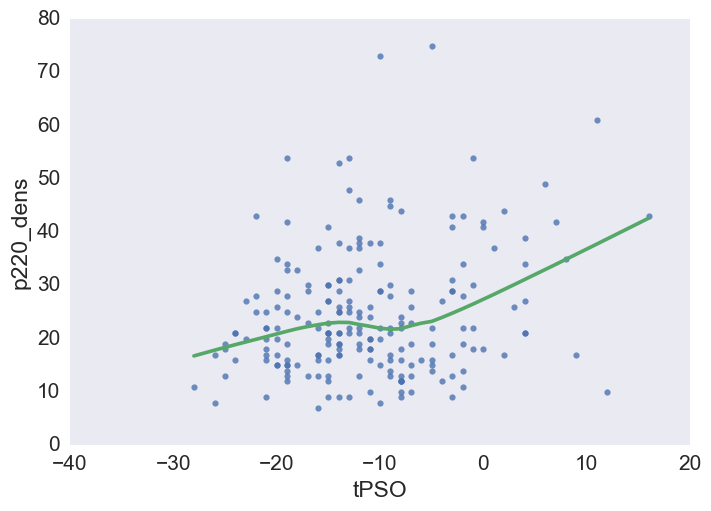

In [1641]:
plt.close()
sns.regplot(ld_05.tPSO, ld_05.p220_dens, fit_reg=False)
sns.regplot(tmp[:,0], tmp[:,1], marker=None, lowess=True)
plt.show()

In [1648]:
niter = 100
alliters = np.zeros((len(ld_05.index)*2,niter))
for i in range(niter):
    find = [np.random.choice(ld_05.index) for _ in range(len(ld_05.index))]
    fsamp = ld_05.loc[find]
    alliters[:,i] = lowess(fsamp.p220_dens, fsamp.tPSO, frac=0.3).flatten()


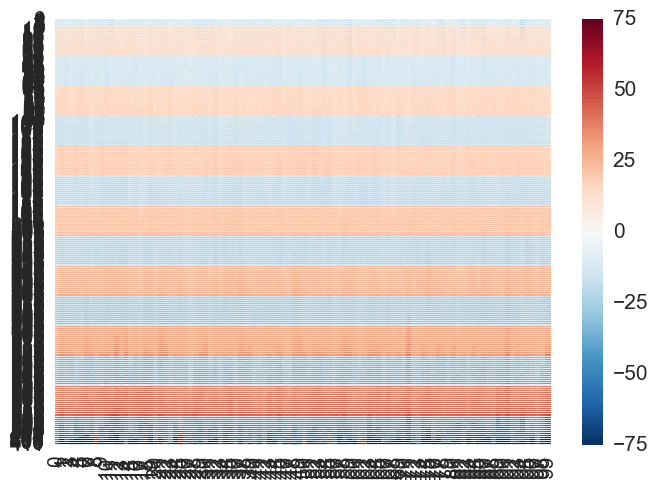

In [1632]:
plt.close()
sns.heatmap(alliters)
plt.show()

In [1554]:
sys.path.insert(0,'/Users/jakevogel/git/data_driven_pathology/')
import vogel_basc as vb

In [1649]:
alliters = alliters.transpose()

running cluster analyses
working on iteration 0
working on iteration 10
working on iteration 20
working on iteration 30
working on iteration 40
working on iteration 50
working on iteration 60
working on iteration 70
working on iteration 80
working on iteration 90
creating stability matrix
working on iteration 0
working on iteration 10
working on iteration 20
working on iteration 30
working on iteration 40
working on iteration 50
working on iteration 60
working on iteration 70
working on iteration 80
working on iteration 90


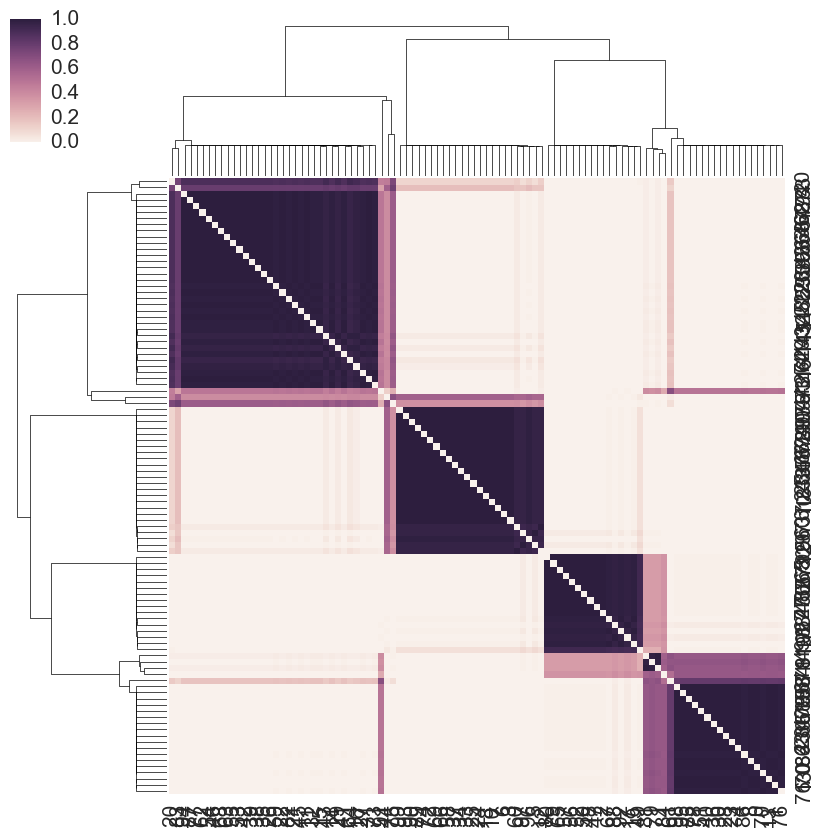

In [1650]:
clusters = vb.poormans_basc(pandas.DataFrame(alliters), 4, 100, 10, return_mtx=True)

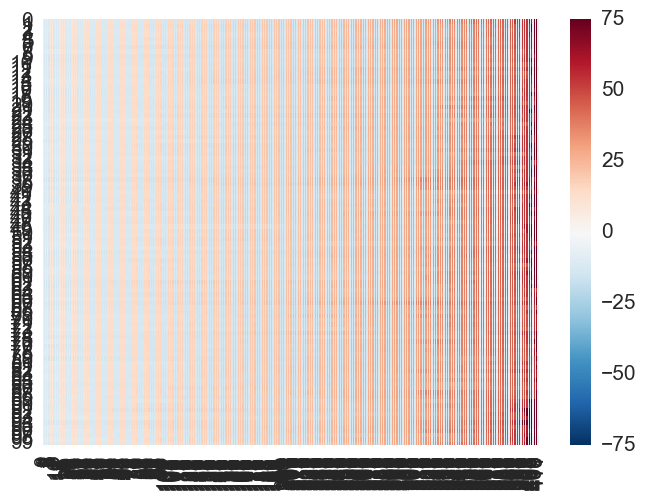

In [1591]:
plt.close()
sns.heatmap(pandas.DataFrame(alliters).loc[clusters[1].sort_values('order').index].values)
plt.show()

In [1651]:
jnkdf = clusters[1]

In [1652]:
avg0 = jnkdf[jnkdf.order==0][jnkdf.columns[:-1]].mean().reshape(206,2)
avg1 = jnkdf[jnkdf.order==1][jnkdf.columns[:-1]].mean().reshape(206,2)
avg2 = jnkdf[jnkdf.order==2][jnkdf.columns[:-1]].mean().reshape(206,2)
avg3 = jnkdf[jnkdf.order==3][jnkdf.columns[:-1]].mean().reshape(206,2)

//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':
//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app
//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  app.launch_new_instance()
//anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


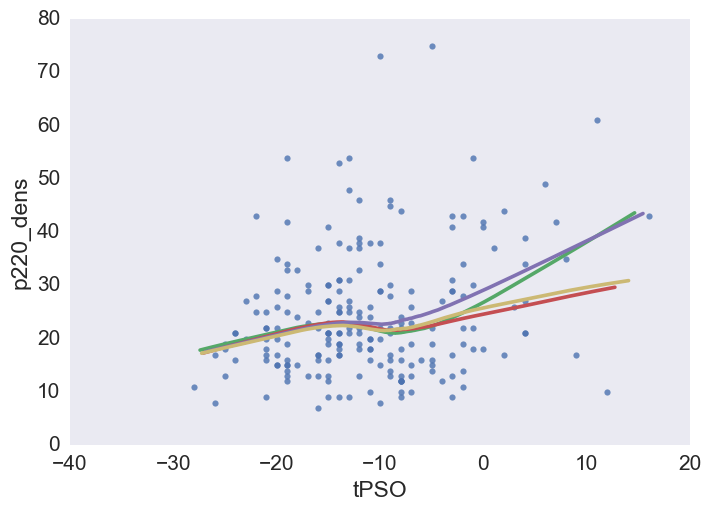

In [1653]:
plt.close()
sns.regplot(ld_05.tPSO, ld_05.p220_dens, fit_reg=False)
sns.regplot(avg0[:,0], avg0[:,1], marker=None, lowess=True)
sns.regplot(avg1[:,0], avg1[:,1], marker=None, lowess=True)
sns.regplot(avg2[:,0], avg2[:,1], marker=None, lowess=True)
sns.regplot(avg3[:,0], avg3[:,1], marker=None, lowess=True)
plt.show()

In [ ]:
# NEXT: CREATE A MODEL PROBABILITY SCORE
# CREATE TWO METRICS
# AN INDEX OF DISTANCE TO EACH MODEL
# AND AN INDEX OF RATIO BETWEEN INDEX OF EACH MODEL

In [ ]:
jnkdf[jnkdf.order==0][jnkdf.columns[:-1]].values.mean

In [1571]:
jnkdf[jnkdf.order==0][jnkdf.columns[:-1]].shape

(49, 412)